# Summarize models fit to natural populations from Luksza and Lassig 2014

This notebook summarizes all metrics required for model comparison including the following:

  1. Standardized predictor distributions
  1. Model residuals by predictor
  1. Forecast errors overall and by timepoint
  1. Model coefficients averages and by timepoint
  
## Table of contents

 1. [Import and define functions](#Import-and-define-functions)
 1. [Define configuration settings](#Define-configuration-settings)
 1. [Load data](#Load-data)
 1. [Summarize predictors](#Summarize-predictors)
 1. [Summarize model residuals](#Summarize-model-residuals)
 1. [Summarize observed and predicted distances](#Summarize-observed-and-predicted-distances)
 1. [Summarize model forecasting error](#Summarize-model-forecasting-error)

## Import and define functions
[back to top](#Summarize-models)

In [1]:
import Bio.SeqIO
from collections import defaultdict
import glob
import json
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def mean_absolute_error(observed, estimated, **kwargs):
    """
    Calculates the mean absolute error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean absolute error between observed and estimated values
    """
    return np.mean(np.abs(observed - estimated))

def root_mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the root mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        root mean square error between observed and estimated values
    """
    return np.sqrt(np.mean((observed - estimated) ** 2))

def mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean square error between observed and estimated values
    """
    return np.mean((observed - estimated) ** 2)

def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors", hue=None,
                    height=4, aspect=1, col_order=None, col_wrap=4, markersize=15, grid_kwargs=None):
    if grid_kwargs is None:
        grid_kwargs = {}
        
    g = sns.FacetGrid(data, col=predictors_column, col_order=col_order, col_wrap=col_wrap, hue=hue, height=height, aspect=aspect, **grid_kwargs)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column, markersize=markersize)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc", zorder=-10)

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate()
    return g

## Define configuration settings
[back to top](#Summarize-models)

In [6]:
predictor_names_order = [
    "naive",
    "ep_x",
    "cTiter",
    "ne_star",
    "delta_frequency",
    "lbi",
    "ep_x-ne_star",
    "lbi-ep_x-ne_star"
]

In [7]:
"""predictor_names_order = [
    "naive",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency"
]

predictor_names_order = [
    "naive",
    "ep_x",
    "cTiter",
    "cTiterSub",
    "cTiterSub_star",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency",
    "ep_x-ne_star",
    "lbi-ne_star",
    "lbi-ep_x-ne_star"
]

#predictor_names_order = [
#    "naive",
#    "lbi"
#]"""

'predictor_names_order = [\n    "naive",\n    "ep_x",\n    "cTiterSub_x",\n    "ne_star",\n    "dms_star",\n    "lbi",\n    "delta_frequency"\n]\n\npredictor_names_order = [\n    "naive",\n    "ep_x",\n    "cTiter",\n    "cTiterSub",\n    "cTiterSub_star",\n    "cTiterSub_x",\n    "ne_star",\n    "dms_star",\n    "lbi",\n    "delta_frequency",\n    "ep_x-ne_star",\n    "lbi-ne_star",\n    "lbi-ep_x-ne_star"\n]\n\n#predictor_names_order = [\n#    "naive",\n#    "lbi"\n#]'

In [8]:
best_models = [
    "ep_x",
    "ne_star",
    "lbi",
    "lbi-ep_x-ne_star",
    "cTiterSub_x",
    "dms_star",
    "delta_frequency",
    "lbi-cTiterSub_x-dms_star"
]

best_predictor_names = [
    "epitope mutations",
    "non-epitope mutations",
    "LBI",
    "LBI and mutations",
    "HI phenotypes",
    "DMS phenotypes",
    "delta frequency",
    "LBI, HI, and DMS"
]

In [9]:
data_root = "../results/builds/natural/luksza_lassig/"

## Load data
[back to top](#Summarize-models)

In [10]:
tip_attributes_df = pd.read_table(data_root + "tip_attributes_with_weighted_distances.tsv", parse_dates=["timepoint"])

In [11]:
observed_weighted_distances = tip_attributes_df.loc[:, ["timepoint", "strain", "frequency", "weighted_distance_to_future"]].copy()

In [12]:
observed_weighted_distances["y"] = observed_weighted_distances["weighted_distance_to_future"]

In [13]:
model_jsons = glob.glob(data_root + "models_by_distances/*.json")

In [14]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [15]:
models_by_predictors["lbi"]["cost_function"]

'diffsum'

In [16]:
models_by_predictors["lbi"]["l1_lambda"]

0.01

In [17]:
models_by_predictors["lbi"]["training_window"]

6

In [18]:
models_by_predictors["lbi"]["pseudocount"]

In [19]:
type(models_by_predictors["lbi"])

dict

In [20]:
sorted(models_by_predictors.keys())

['cTiter',
 'delta_frequency',
 'ep_x',
 'ep_x-ne_star',
 'lbi',
 'lbi-ep_x-ne_star',
 'naive',
 'ne_star']

In [21]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'mean_stds_mean', 'mean_stds_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [22]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'mean_stds', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [23]:
models_by_predictors["lbi"]["scores"][0]["training_n"]

497

In [24]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['y', 'y_hat'])

In [25]:
models_by_predictors["lbi"]["scores"][0]["coefficients"]

[0.4730718981663493]

In [26]:
models_by_predictors["lbi"]["scores"][0]["mean_stds"]

[0.17526301406979547]

In [27]:
len(models_by_predictors["lbi"]["scores"])

23

Build data frames for plotting from the model scores.

In [28]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
mean_stds_by_time = []
frequency_dfs = []
residuals_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": pd.to_datetime(scores["validation_timepoint"]),
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        for predictor, coefficient, mean_std in zip(model["predictors"], scores["coefficients"], scores["mean_stds"]):
            coefficients_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "coefficient": coefficient,
                "validation_timepoint": pd.to_datetime(scores["validation_timepoint"])
            })
            
            mean_stds_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "mean_std": mean_std,
                "validation_timepoint": scores["validation_timepoint"]
            })
        
        #X = pd.DataFrame(scores["validation_data"]["X"])
        #X["timepoint"] = pd.to_datetime(X["timepoint"])

        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])
        y["future_timepoint"] = pd.to_datetime(y["future_timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y_hat.merge(
            observed_weighted_distances,
            on=["timepoint", "strain", "frequency"],
            suffixes=["_hat", ""]
        )
        frequency_df["residual"] = frequency_df["y"] - frequency_df["y_hat"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)

        #training_X = pd.DataFrame(scores["training_data"]["X"])
        #training_X["timepoint"] = pd.to_datetime(training_X["timepoint"])

        training_y = pd.DataFrame(scores["training_data"]["y"])
        training_y["timepoint"] = pd.to_datetime(training_y["timepoint"])
        training_y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
        training_y_hat["timepoint"] = pd.to_datetime(training_y_hat["timepoint"])
        residual_df = training_y_hat.merge(
            observed_weighted_distances,
            on=["timepoint", "strain", "frequency"],
            suffixes=["_hat", ""]
        )
        residual_df["residual"] = residual_df["y"] - residual_df["y_hat"]
        residual_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        residual_df["predictors"] = predictors

        residuals_dfs.append(residual_df)
        
overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
coefficients_by_time_df = pd.DataFrame(coefficients_by_time)
mean_stds_by_time_df = pd.DataFrame(mean_stds_by_time)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)
residual_df = pd.concat(residuals_dfs, ignore_index=True)

In [29]:
frequency_df.head()

fitness  frequency  projected_frequency               strain  timepoint  \
0 -0.244386   0.001225             0.001403  A/Auckland/583/2000 2000-10-01   
1 -0.285982   0.012312             0.013526  A/Auckland/588/2000 2000-10-01   
2 -0.280390   0.011459             0.012659  A/Auckland/589/2000 2000-10-01   
3 -0.373630   0.013150             0.013234  A/Auckland/599/2000 2000-10-01   
4 -0.334326   0.019185             0.020082  A/Auckland/600/2000 2000-10-01   

   weighted_distance_to_future_hat  weighted_distance_to_present     y_hat  \
0                        11.072537                      8.429604  8.602049   
1                         8.839685                      6.470370  5.950296   
2                         7.839685                      5.494997  4.977348   
3                         8.839685                      6.468194  5.949811   
4                        11.072537                      8.253836  8.436600   

   weighted_distance_to_future          y  residual validation_timepoint  \
0                    11.072537  11.072537  2.470488           2000-10-01   
1                     8.839685   8.839685  2.889389           2000-10-01   
2                     7.839685   7.839685  2.862337           2000-10-01   
3                     8.839685   8.839685  2.889874           2000-10-01   
4                    11.072537  11.072537  2.635937           2000-10-01   

  predictors  
0        lbi  
1        lbi  
2        lbi  
3        lbi  
4        lbi

In [30]:
residual_df.head()

fitness  frequency  projected_frequency                  strain  \
0 -0.480630   0.008163             0.005155         A/Lyon/672/1993   
1 -0.541083   0.005355             0.003183  A/Netherlands/101/1993   
2 -0.441521   0.006451             0.004236  A/Netherlands/115/1993   
3 -0.479307   0.008639             0.005463  A/Netherlands/126/1993   
4 -0.952733   0.014500             0.005711  A/Netherlands/165/1993   

   timepoint  weighted_distance_to_future_hat  weighted_distance_to_present  \
0 1993-10-01                         6.780350                      3.548080   
1 1993-10-01                        12.635660                      8.944800   
2 1993-10-01                         6.780350                      3.534226   
3 1993-10-01                         7.647099                      4.435373   
4 1993-10-01                        18.101566                     14.530974   

       y_hat  weighted_distance_to_future          y  residual  \
0   3.060232                     6.780350   6.780350  3.720118   
1   8.687120                    12.635660  12.635660  3.948540   
2   3.051144                     6.780350   6.780350  3.729206   
3   3.969418                     7.647099   7.647099  3.677681   
4  14.408289                    18.101566  18.101566  3.693277   

  validation_timepoint predictors  
0           2000-10-01        lbi  
1           2000-10-01        lbi  
2           2000-10-01        lbi  
3           2000-10-01        lbi  
4           2000-10-01        lbi

In [31]:
residual_df.shape

(361688, 13)

In [32]:
overall_errors_df.sort_values("cv_error_mean")

cv_error_mean  cv_error_std        predictors
0       0.165040      0.270075               lbi
1       0.171241      0.243890  lbi-ep_x-ne_star
4       0.258547      0.216111   delta_frequency
3       0.286926      0.230053      ep_x-ne_star
2       0.295540      0.277670           ne_star
7       0.303309      0.187848             naive
5       0.310135      0.188176            cTiter
6       0.319160      0.195528              ep_x

## Summarize predictors
[back to top](#Summarize-models)

In [33]:
individual_predictor_names_order = [
    predictor
    for predictor in predictor_names_order
    if not "-" in predictor and predictor != "naive"
]

In [34]:
individual_predictor_names_order

['ep_x', 'cTiter', 'ne_star', 'delta_frequency', 'lbi']

In [35]:
long_predictors_df = tip_attributes_df.melt(
    id_vars=["strain", "timepoint"],
    value_vars=individual_predictor_names_order,
    var_name="predictor",
    value_name="predictor_value"
)

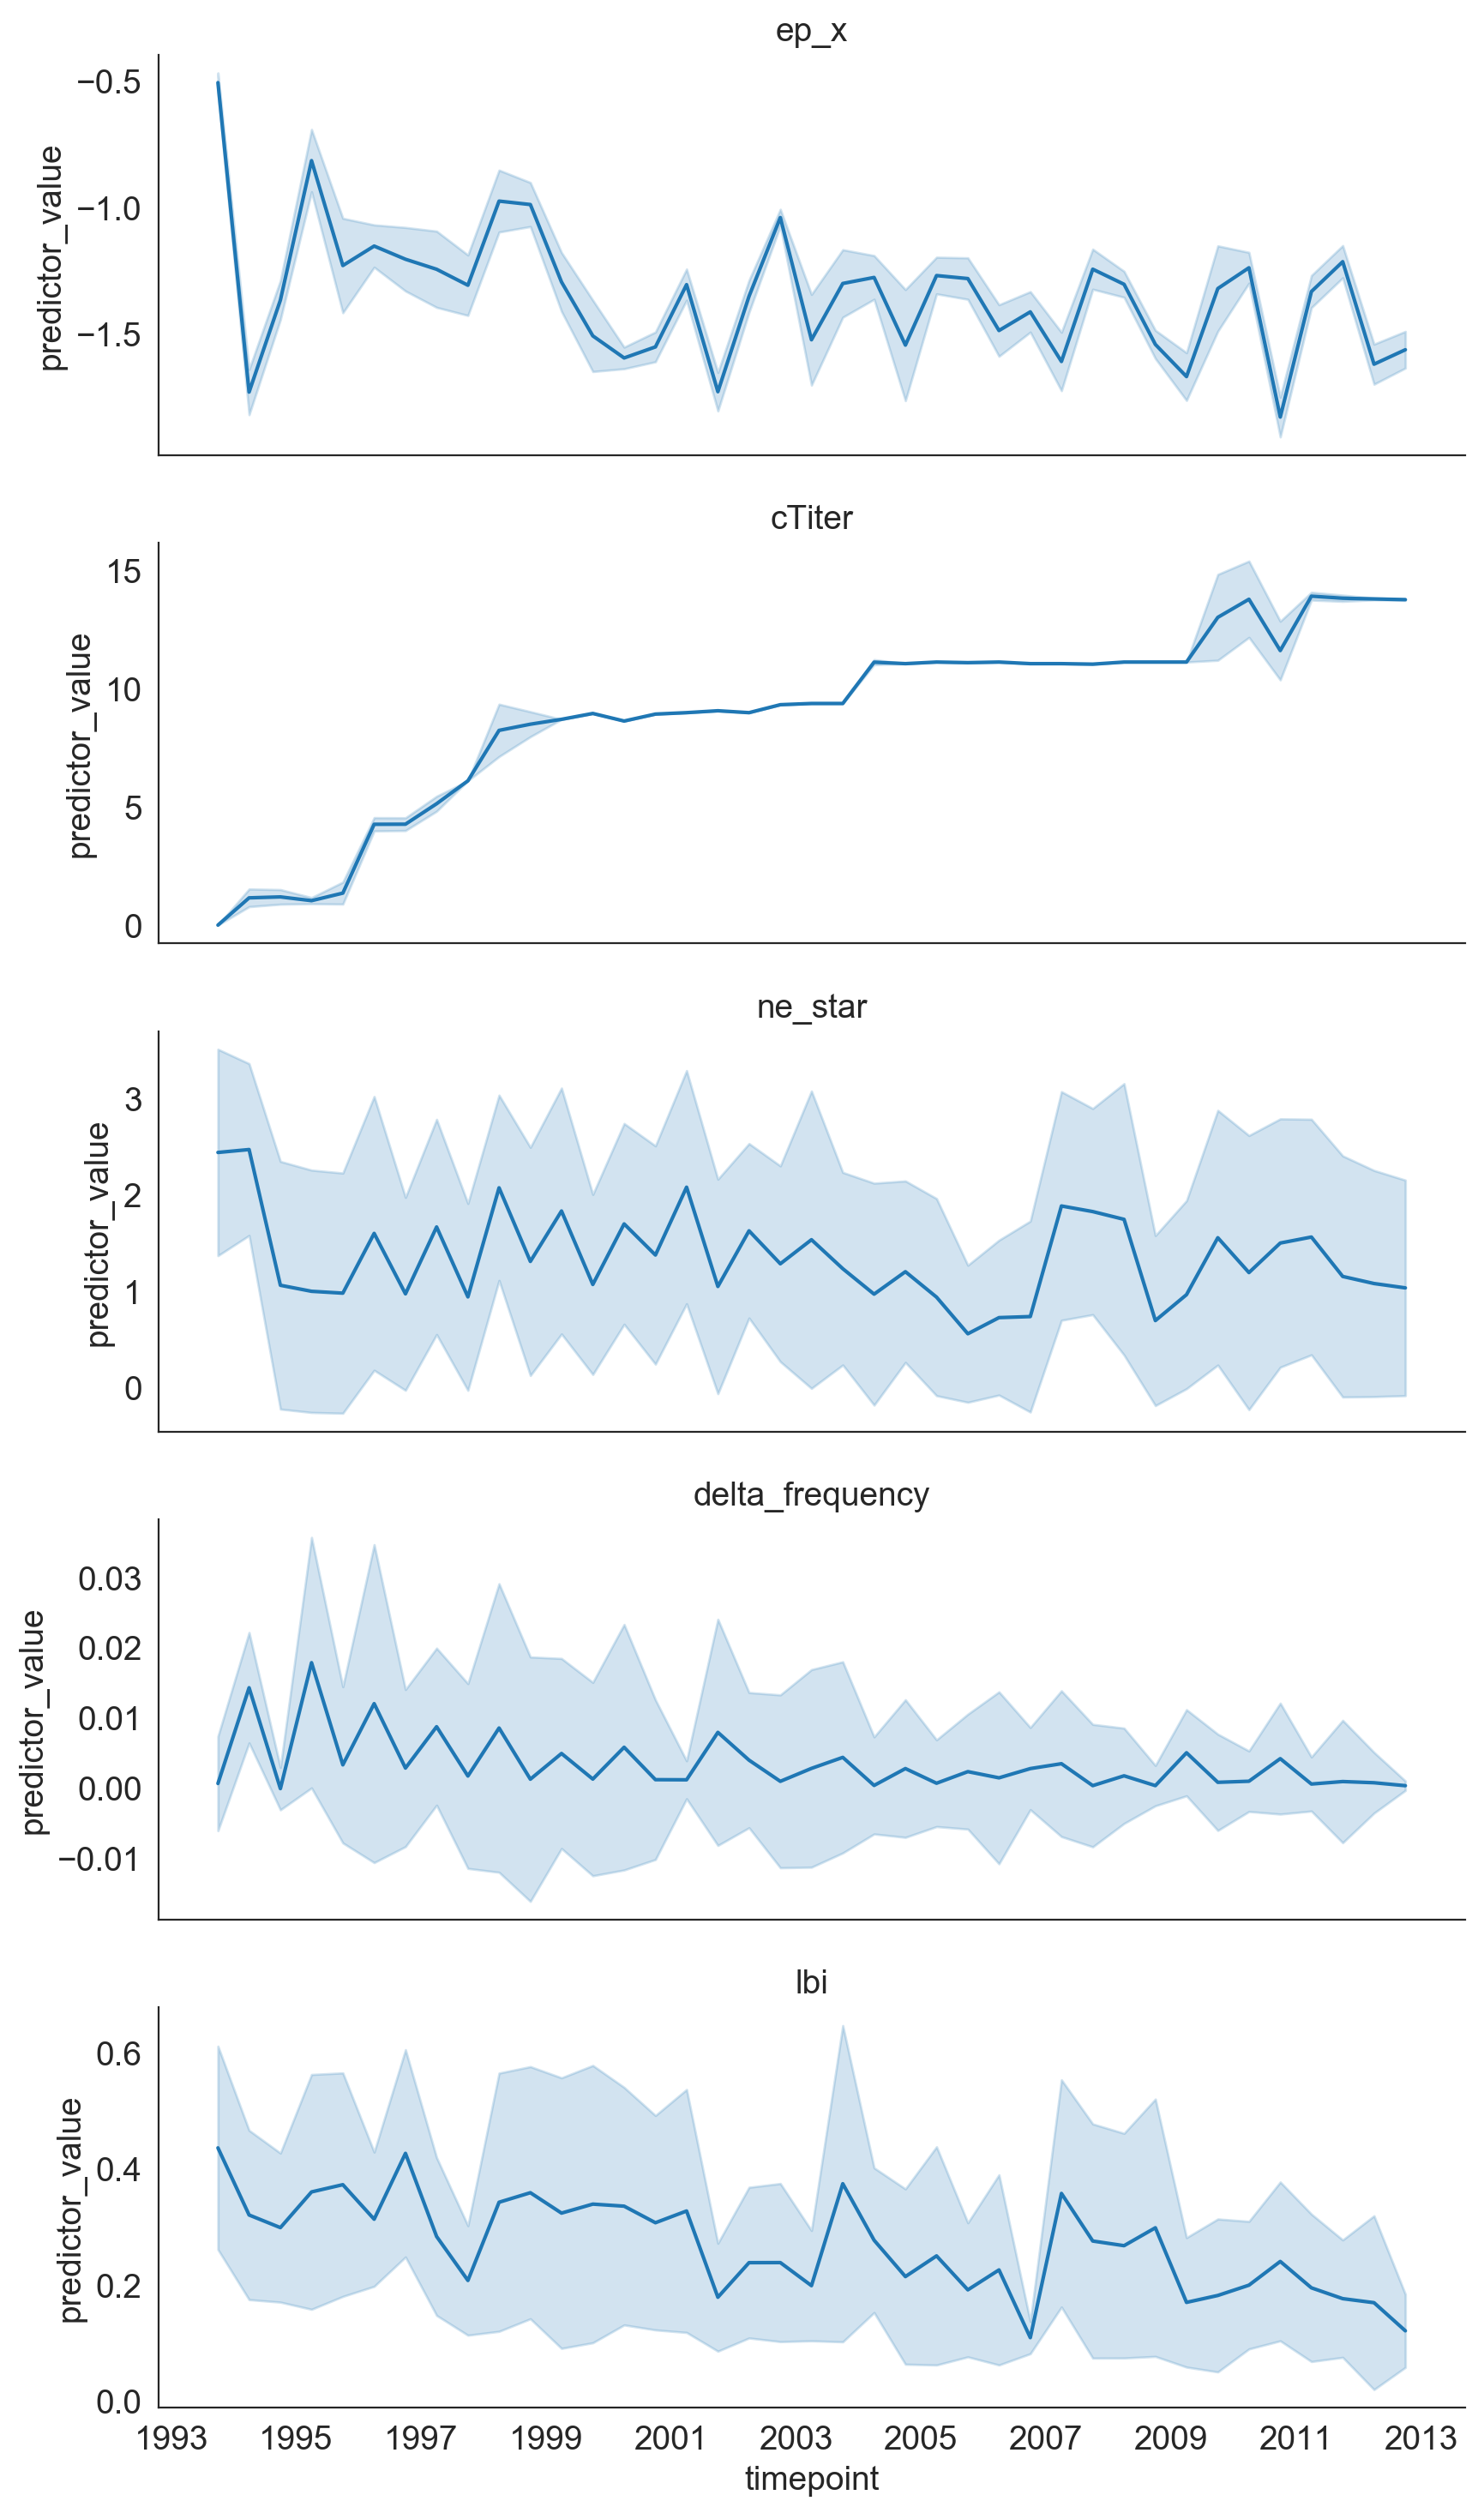

In [36]:
g = sns.FacetGrid(long_predictors_df, row="predictor", aspect=3, sharey=False,
                  row_order=individual_predictor_names_order)
g.map(sns.lineplot, "timepoint", "predictor_value", ci="sd")
g.set_titles("{row_name}")

plt.savefig("../manuscript/figures/predictors_by_timepoint.pdf")

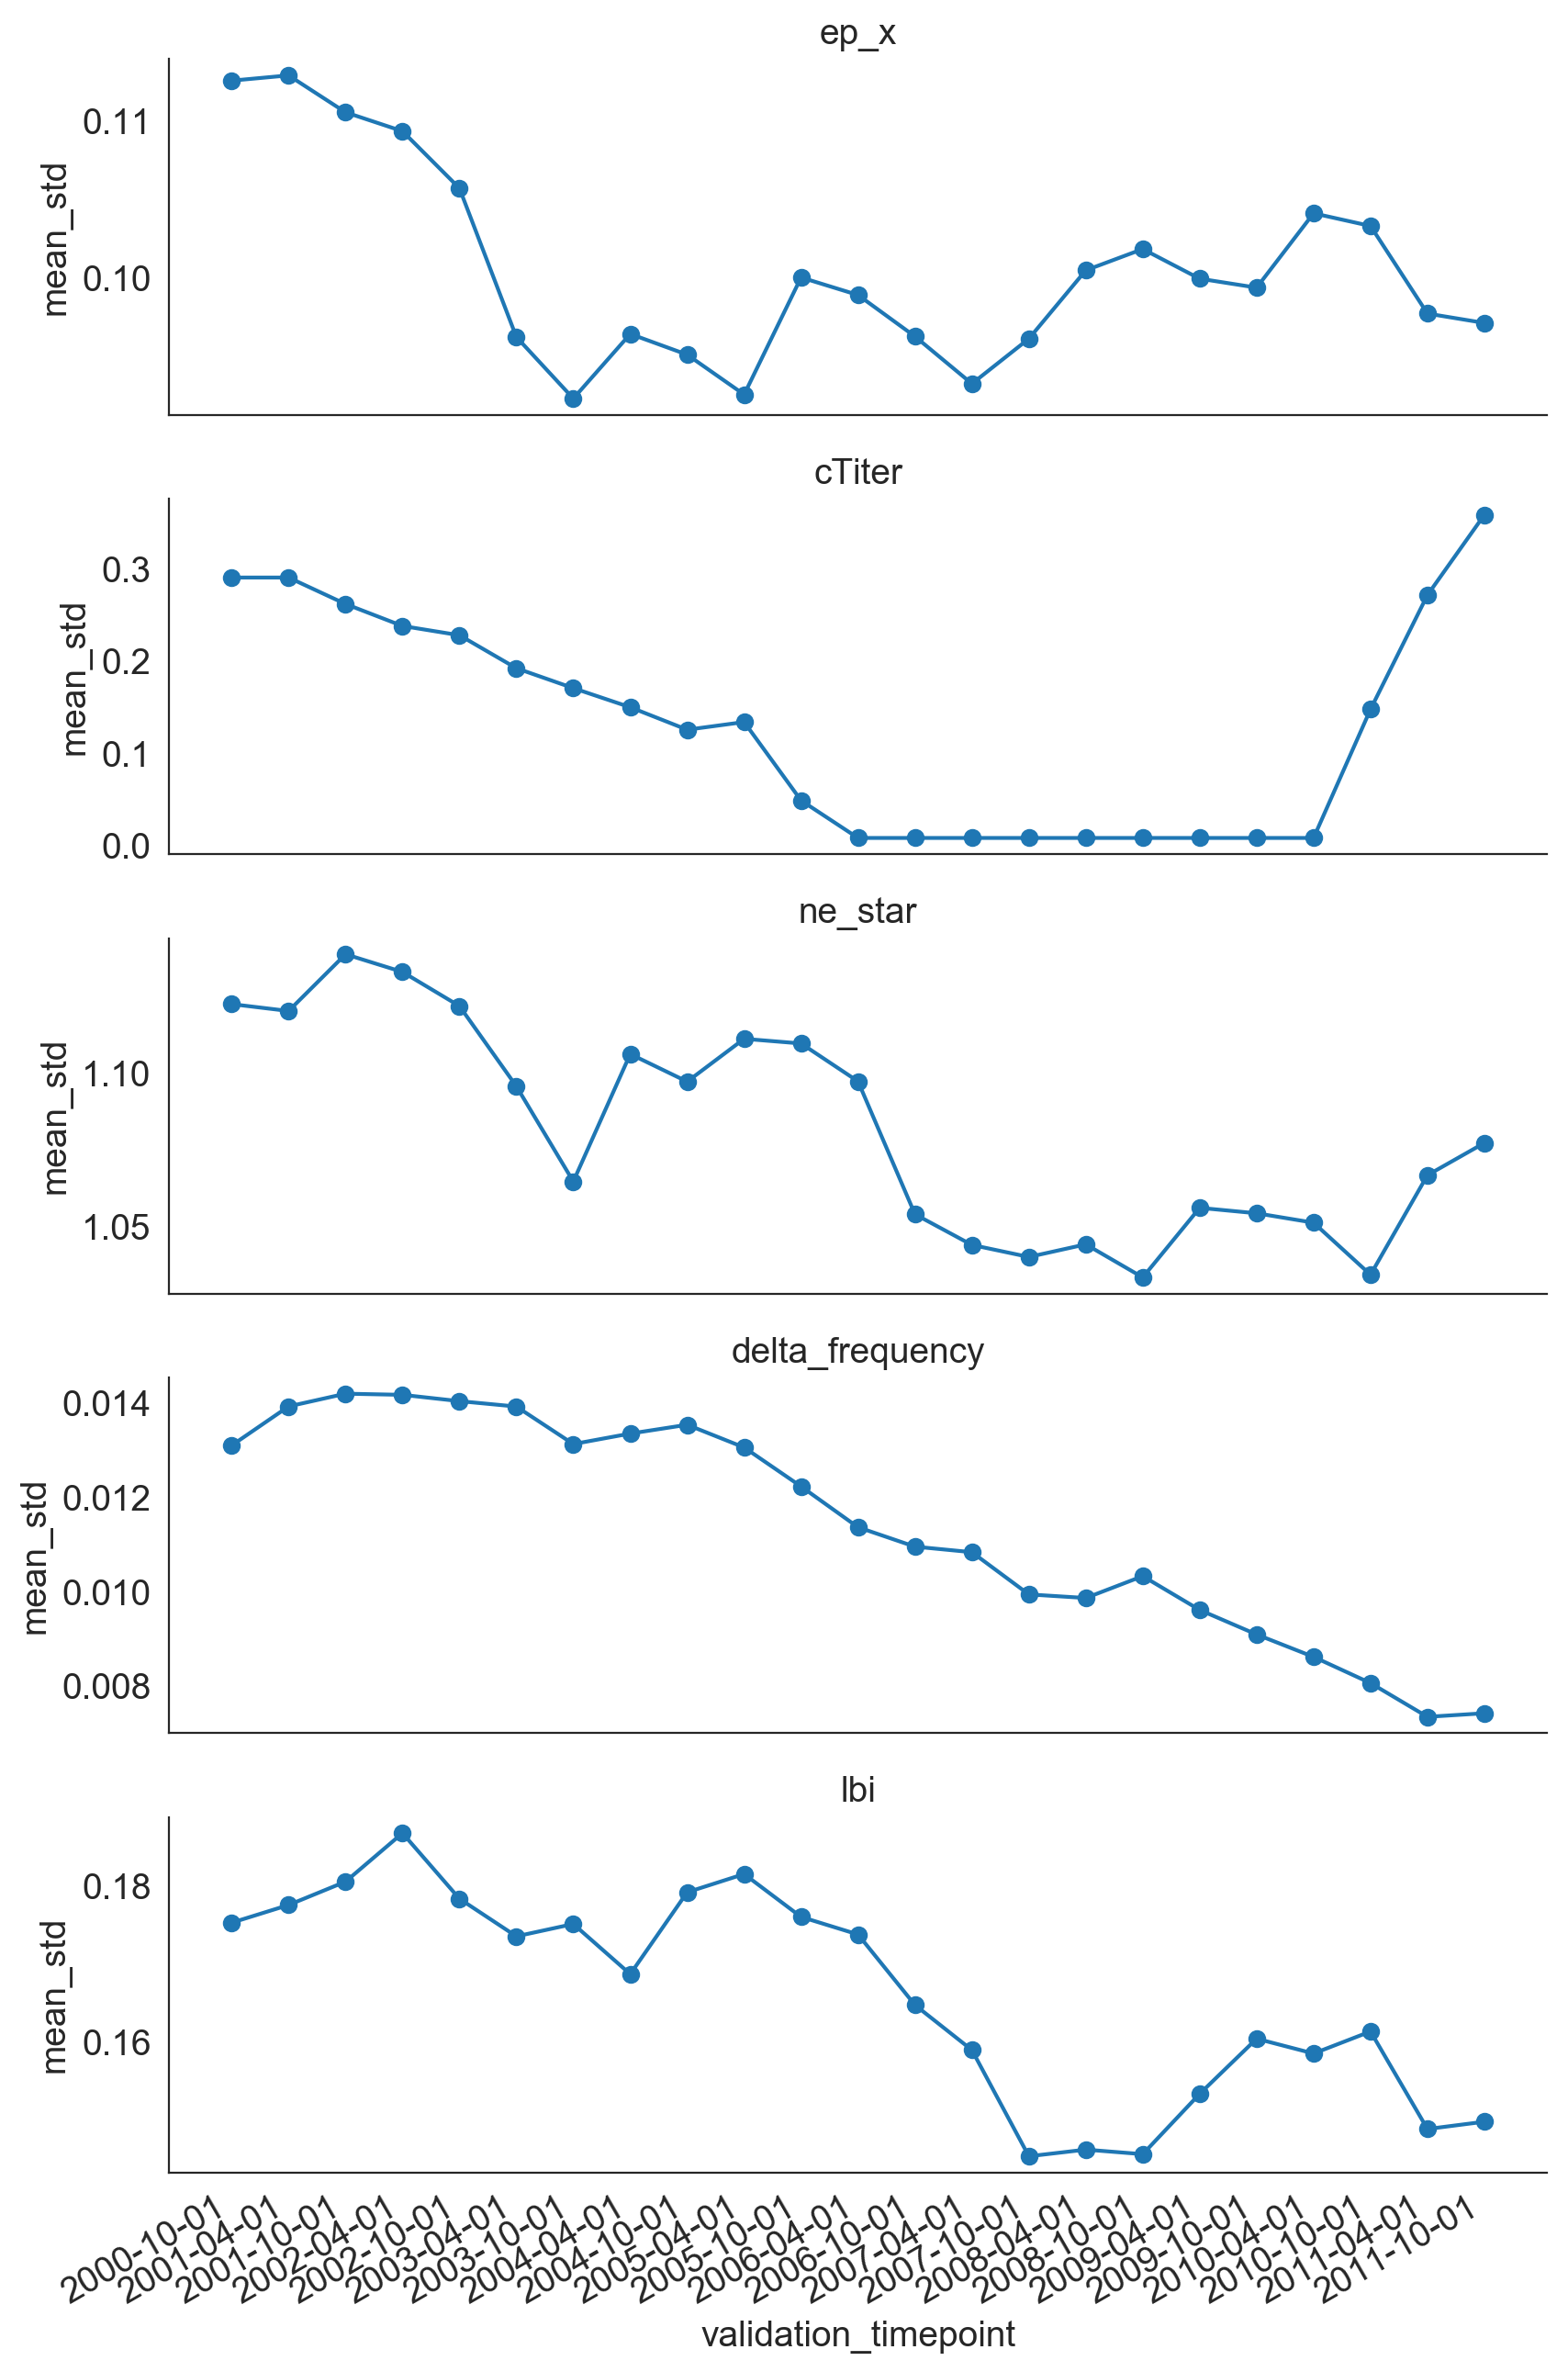

In [37]:
g = sns.FacetGrid(
    mean_stds_by_time_df[mean_stds_by_time_df["predictors"].isin(individual_predictor_names_order)],
    row="predictor",
    row_order=individual_predictor_names_order,
    aspect=3,
    sharey=False
)
g.map(plt.plot, "validation_timepoint", "mean_std", marker="o")
g.set_titles("{row_name}")

plt.gcf().autofmt_xdate()

In [38]:
"""variables_to_plot = [predictor for predictor in predictor_names_order if not "-" in predictor] + ["frequency"]
sns.pairplot(tip_attributes_df.dropna(), vars=variables_to_plot, diag_kind="hist", diag_kws={"bins": 20})"""

'variables_to_plot = [predictor for predictor in predictor_names_order if not "-" in predictor] + ["frequency"]\nsns.pairplot(tip_attributes_df.dropna(), vars=variables_to_plot, diag_kind="hist", diag_kws={"bins": 20})'

In [39]:
tip_attributes_df.loc[pd.isnull(tip_attributes_df["ep_x"]), ["strain", "timepoint", "frequency"]]

Empty DataFrame
Columns: [strain, timepoint, frequency]
Index: []

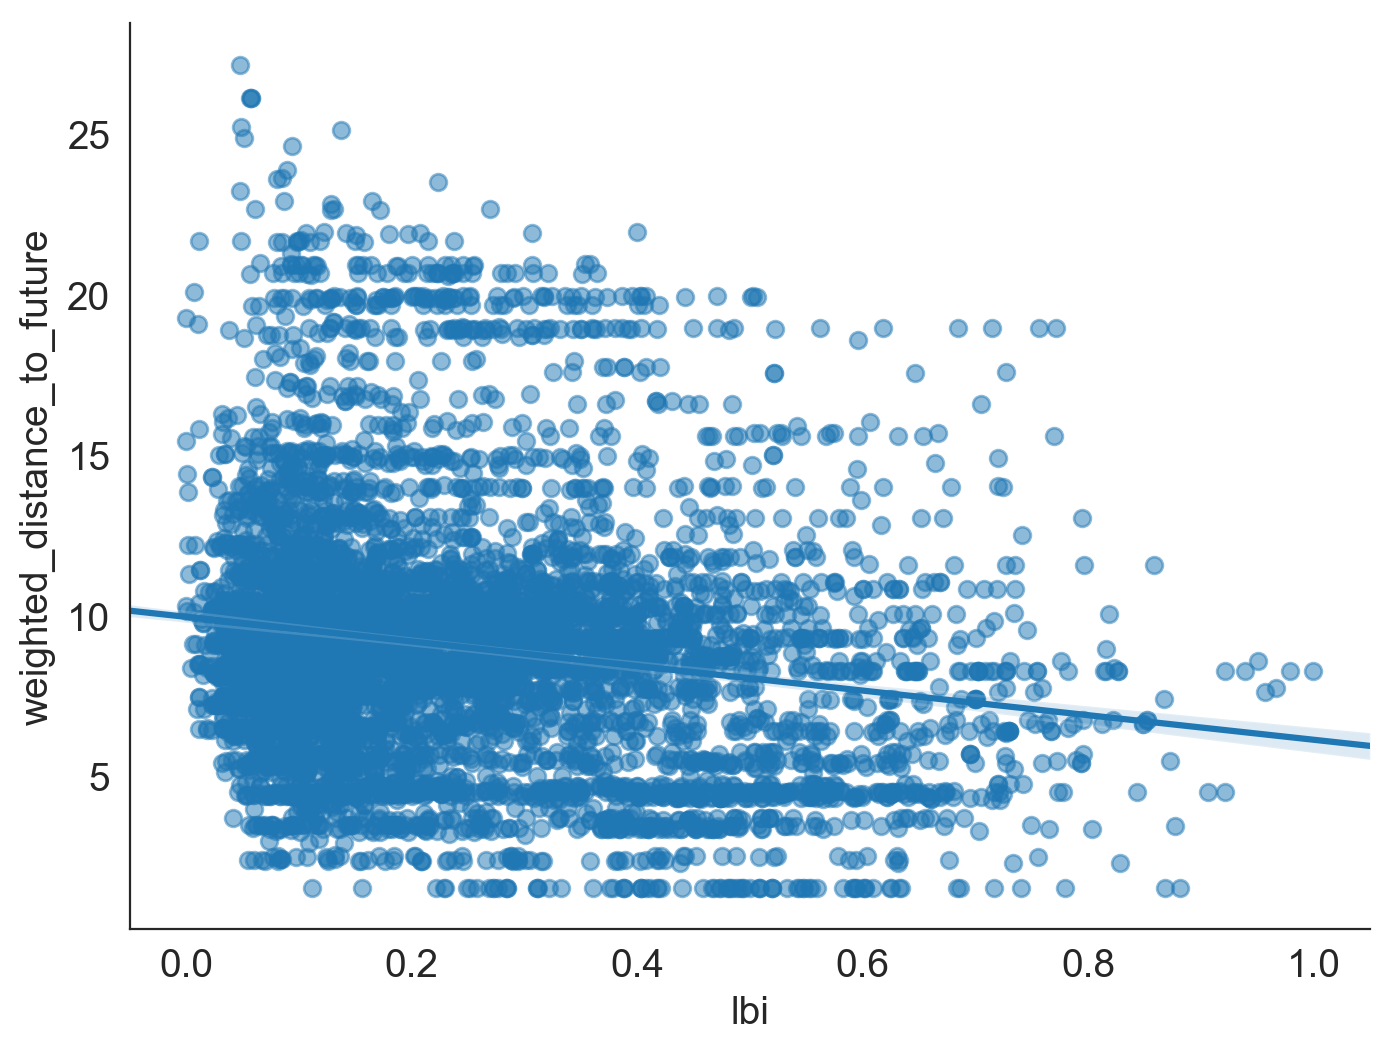

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("lbi", "weighted_distance_to_future", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)

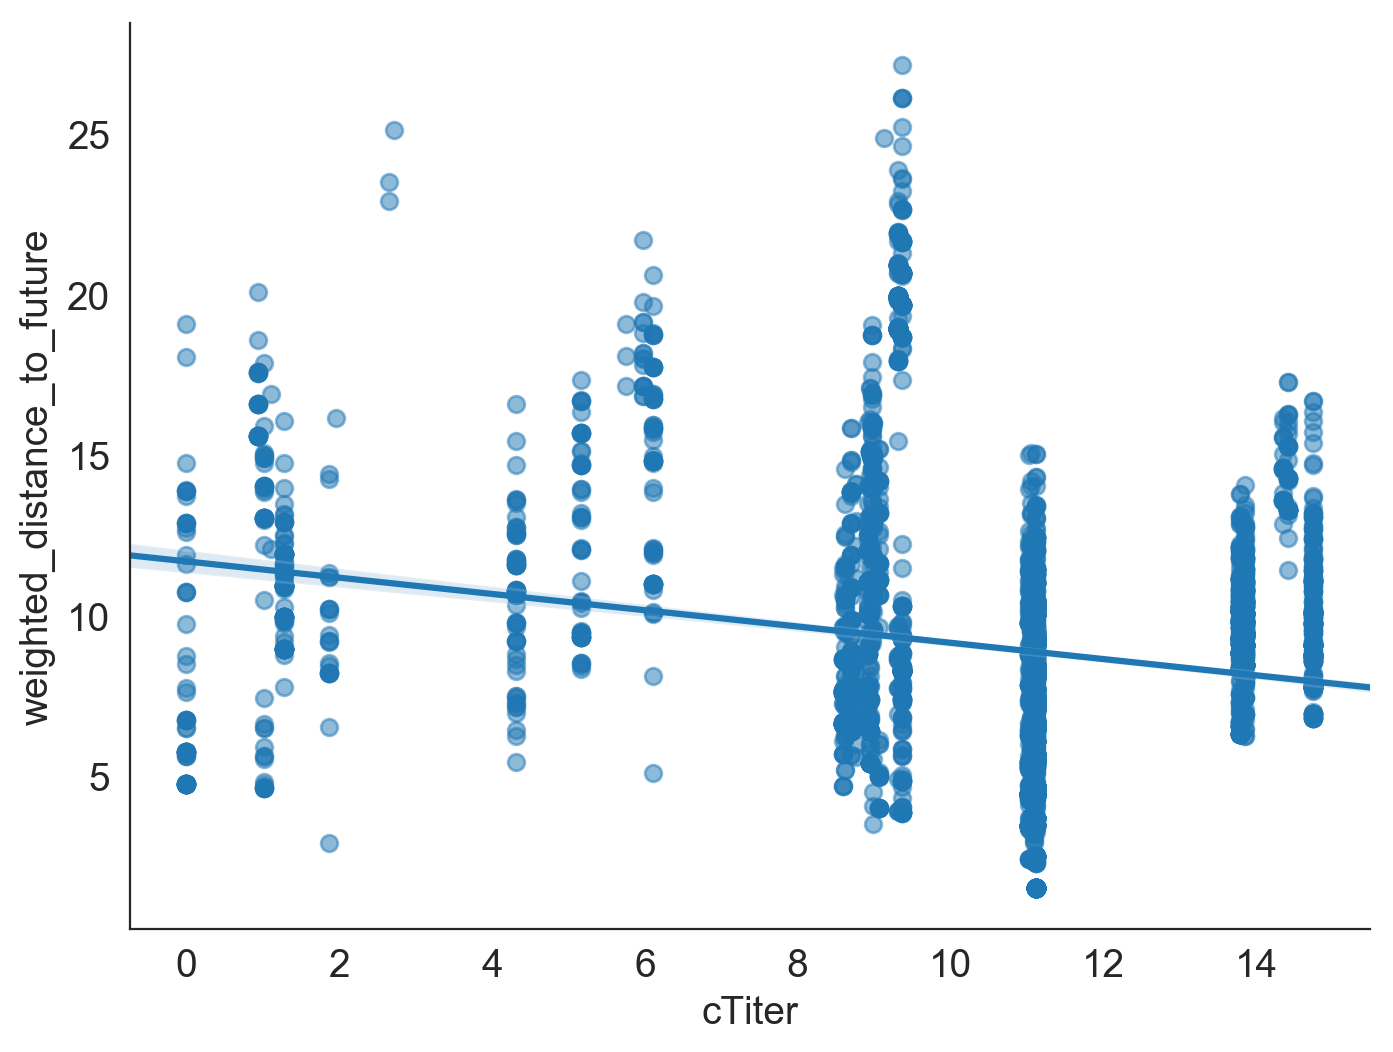

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("cTiter", "weighted_distance_to_future", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)

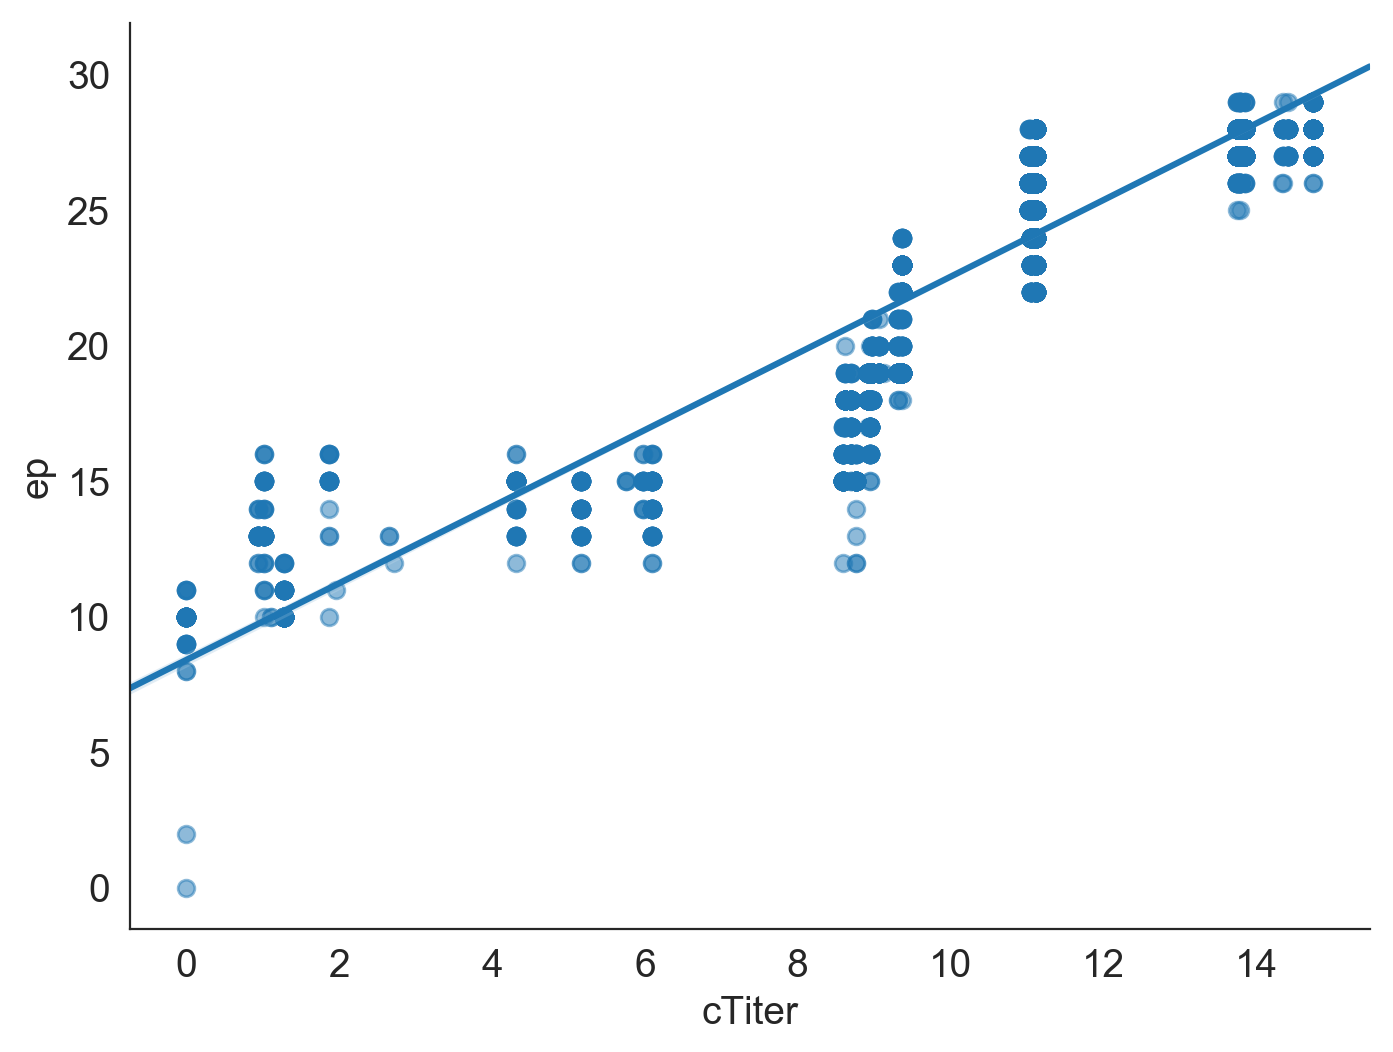

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("cTiter", "ep", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)

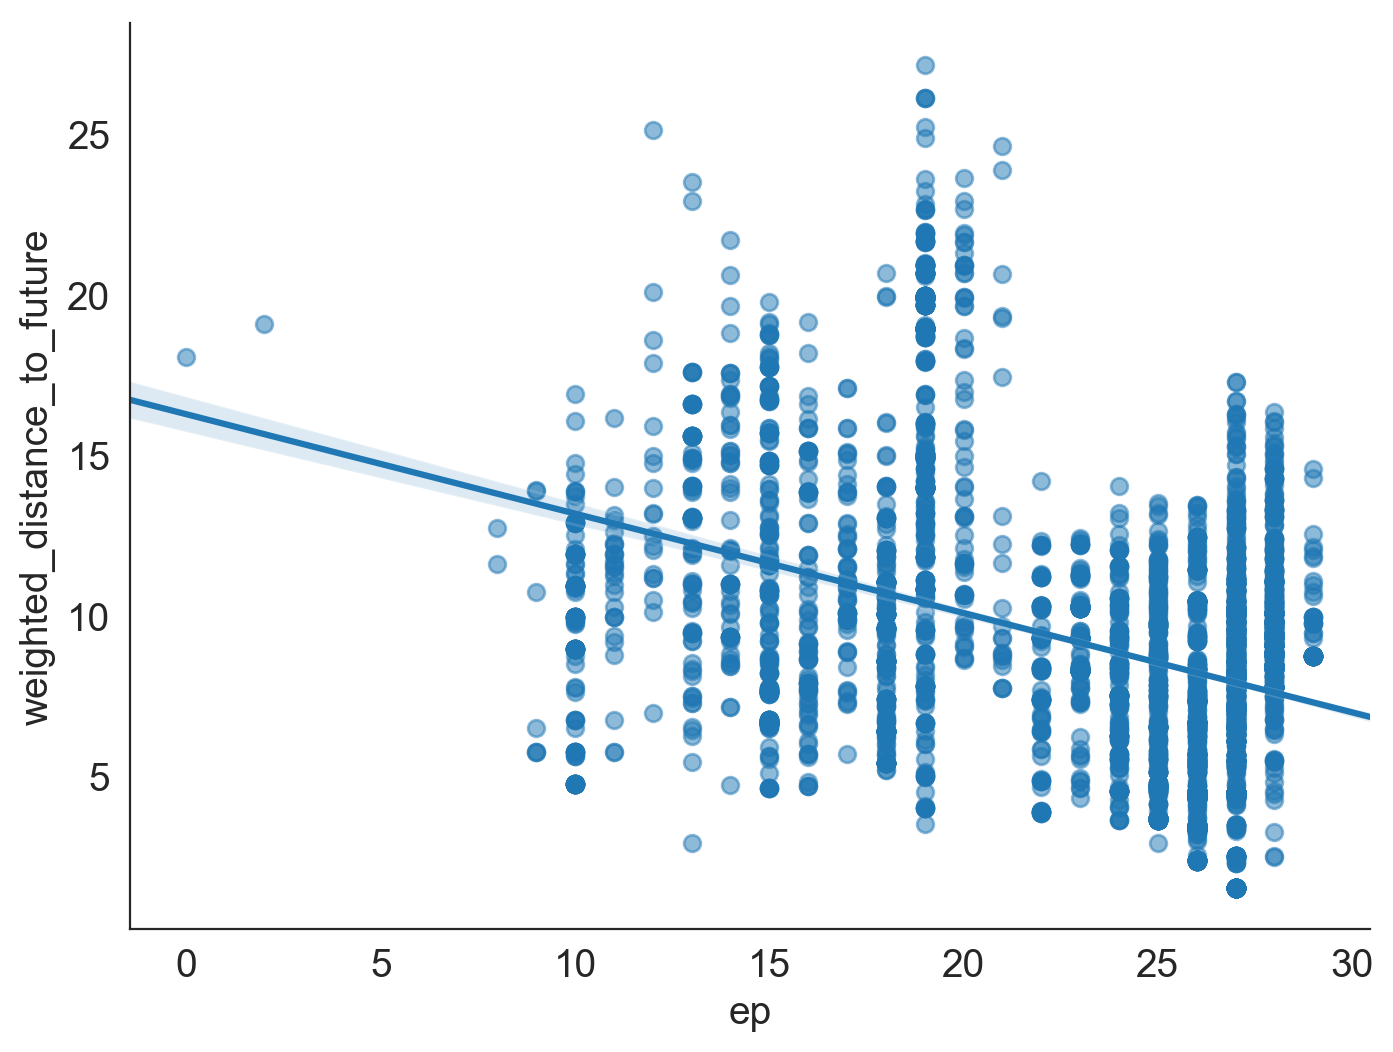

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("ep", "weighted_distance_to_future", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)

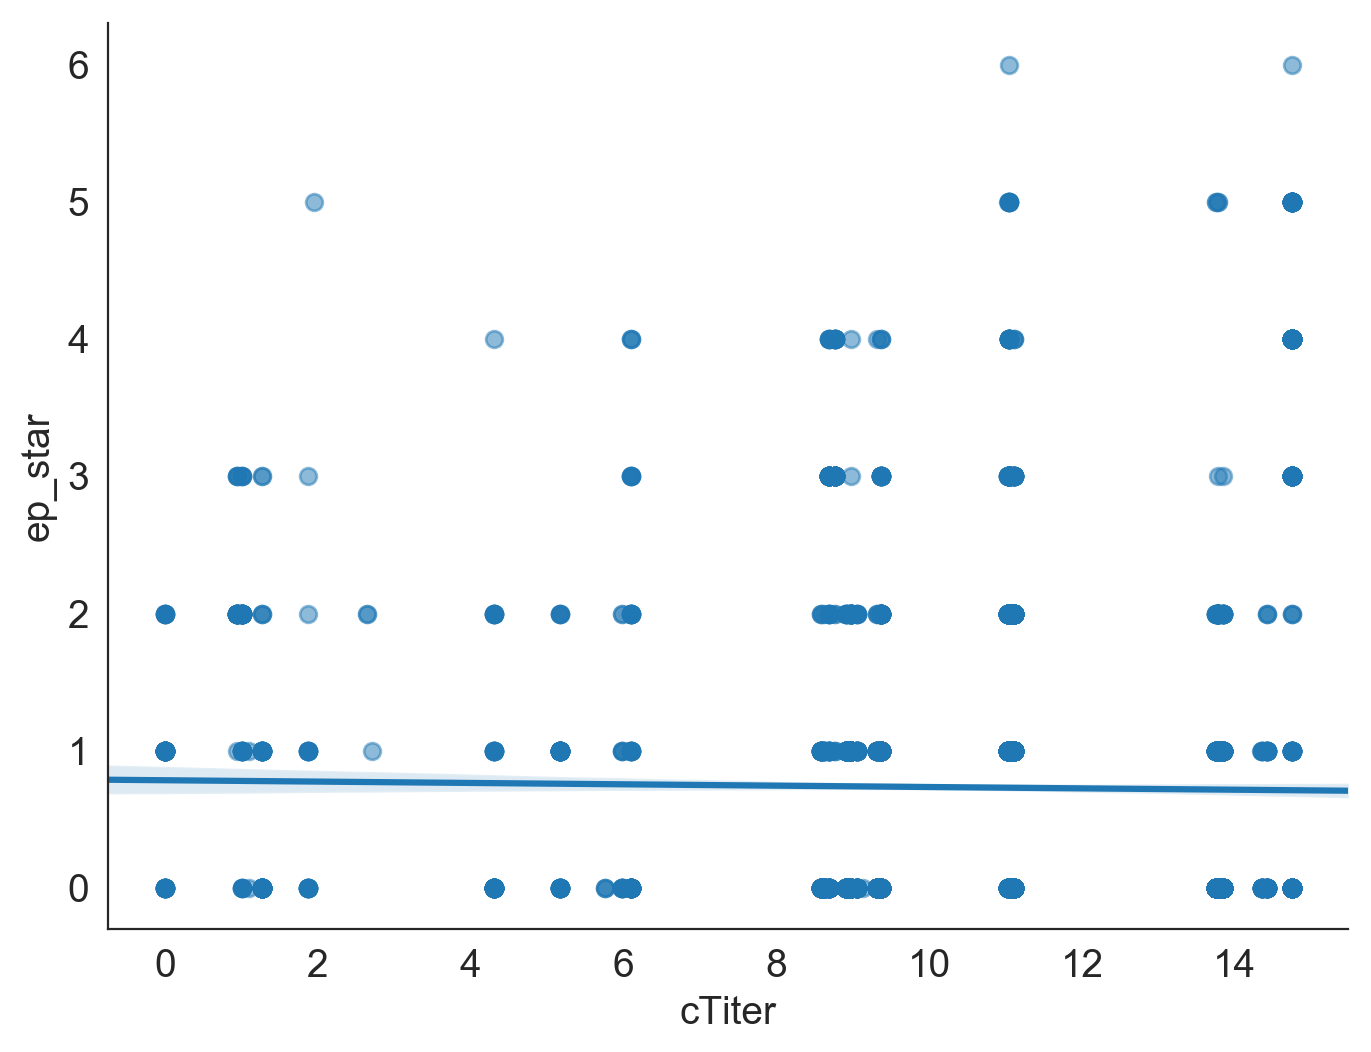

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("cTiter", "ep_star", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)

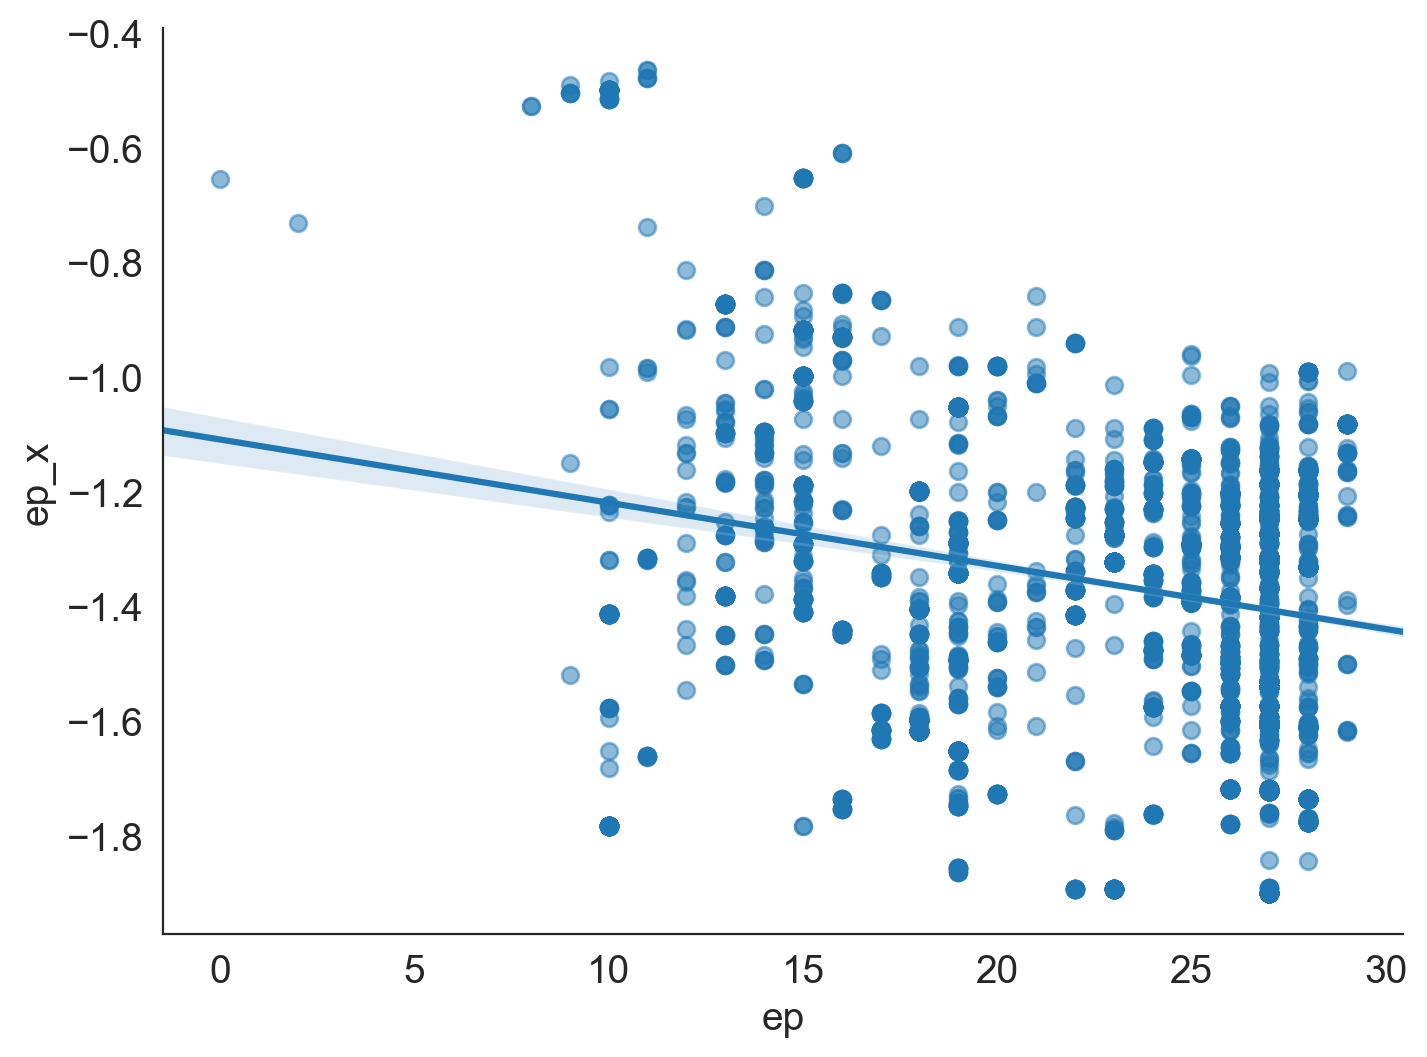

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("ep", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)

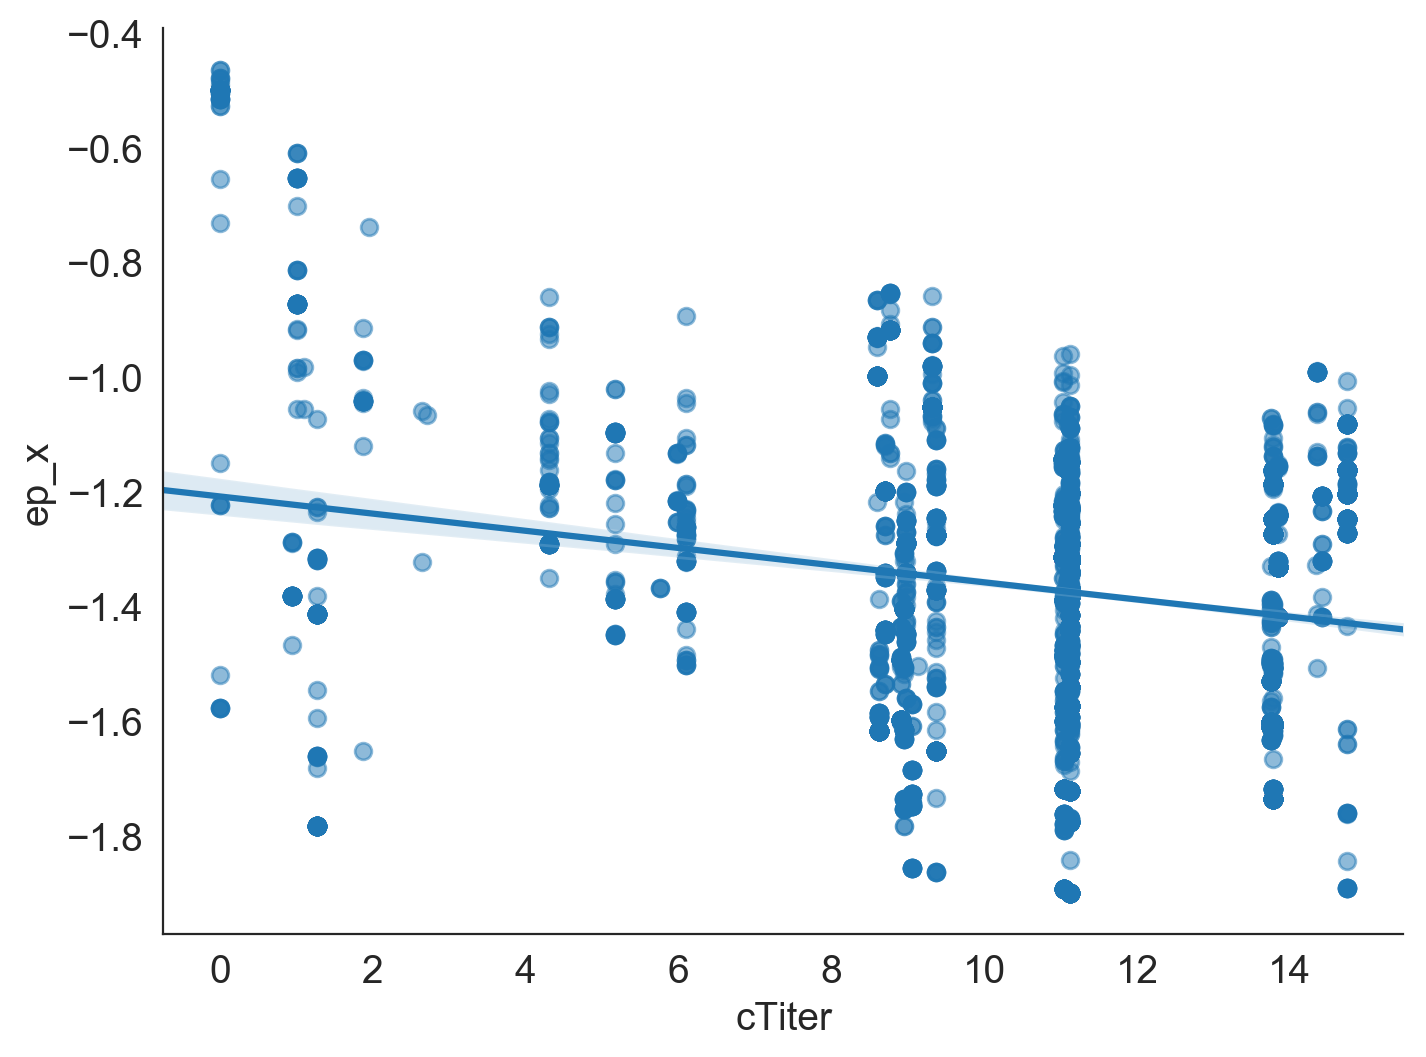

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("cTiter", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)

In [47]:
d_ep = np.arange(0, 21)

In [48]:
d_init = 14.0

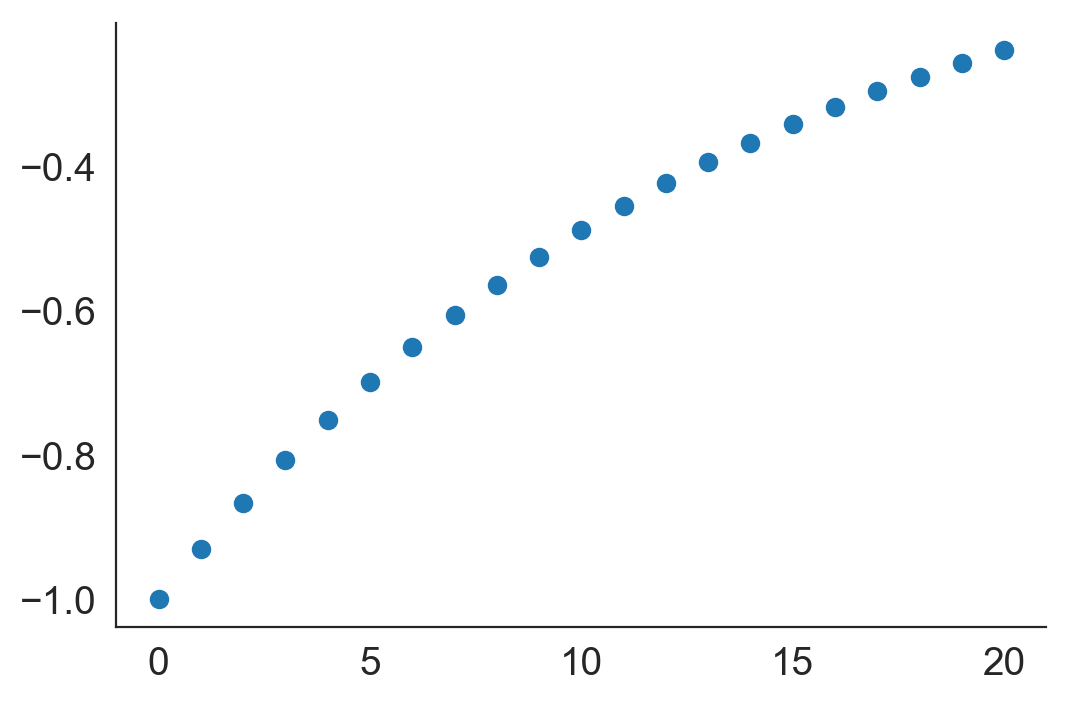

In [49]:
plt.plot(d_ep, -np.exp(-d_ep / float(d_init)), "o")

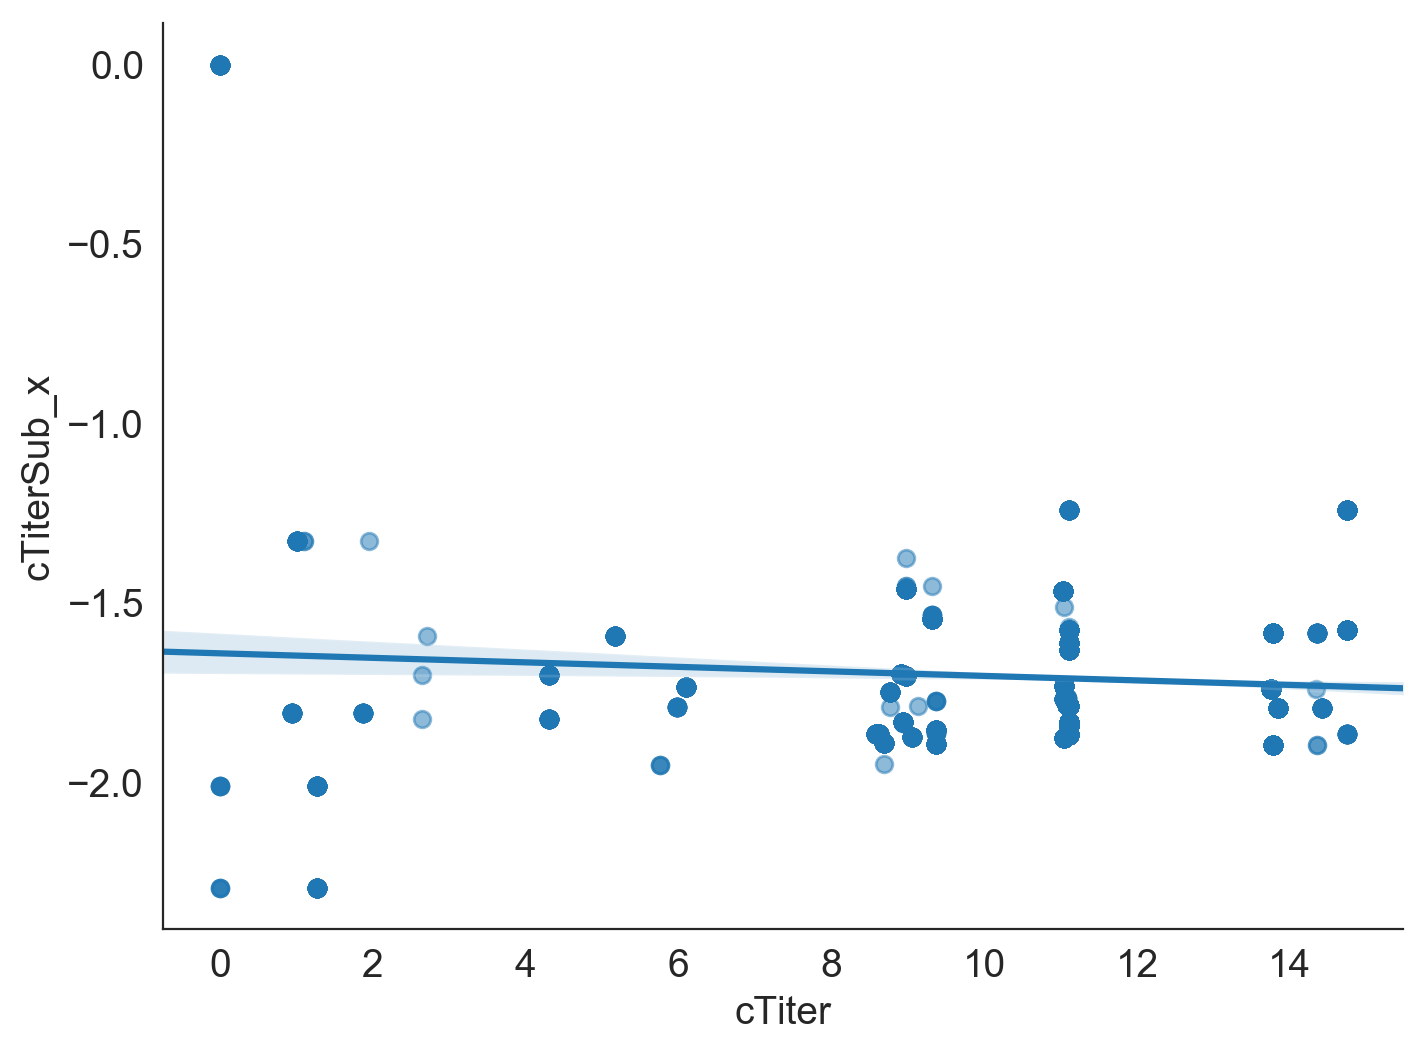

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("cTiter", "cTiterSub_x", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)

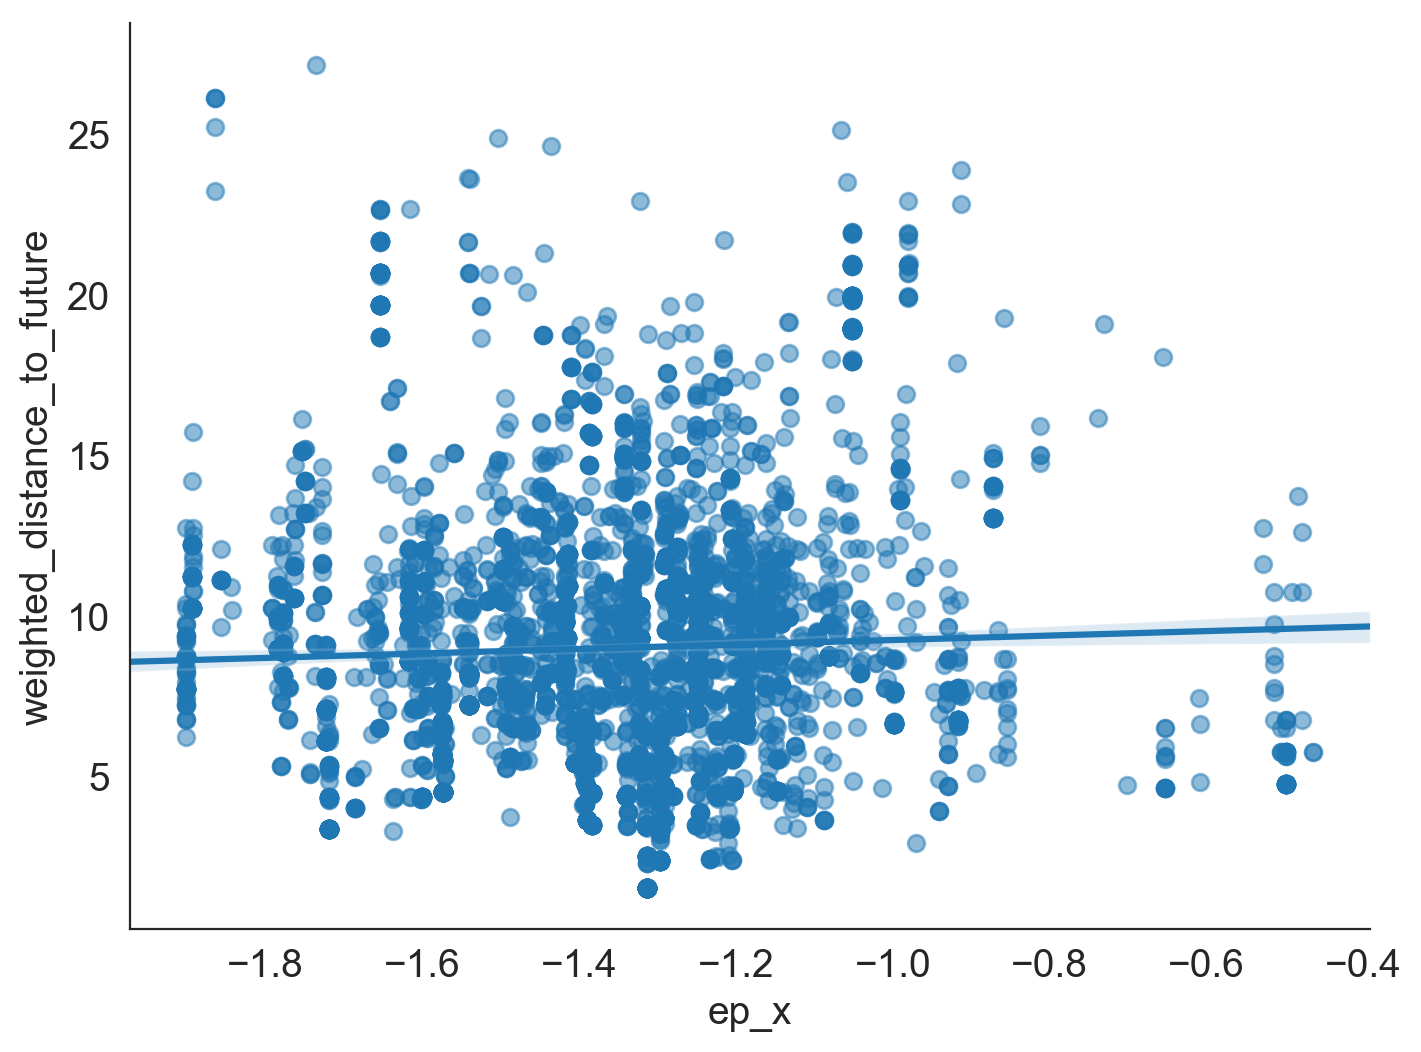

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("ep_x", "weighted_distance_to_future", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)

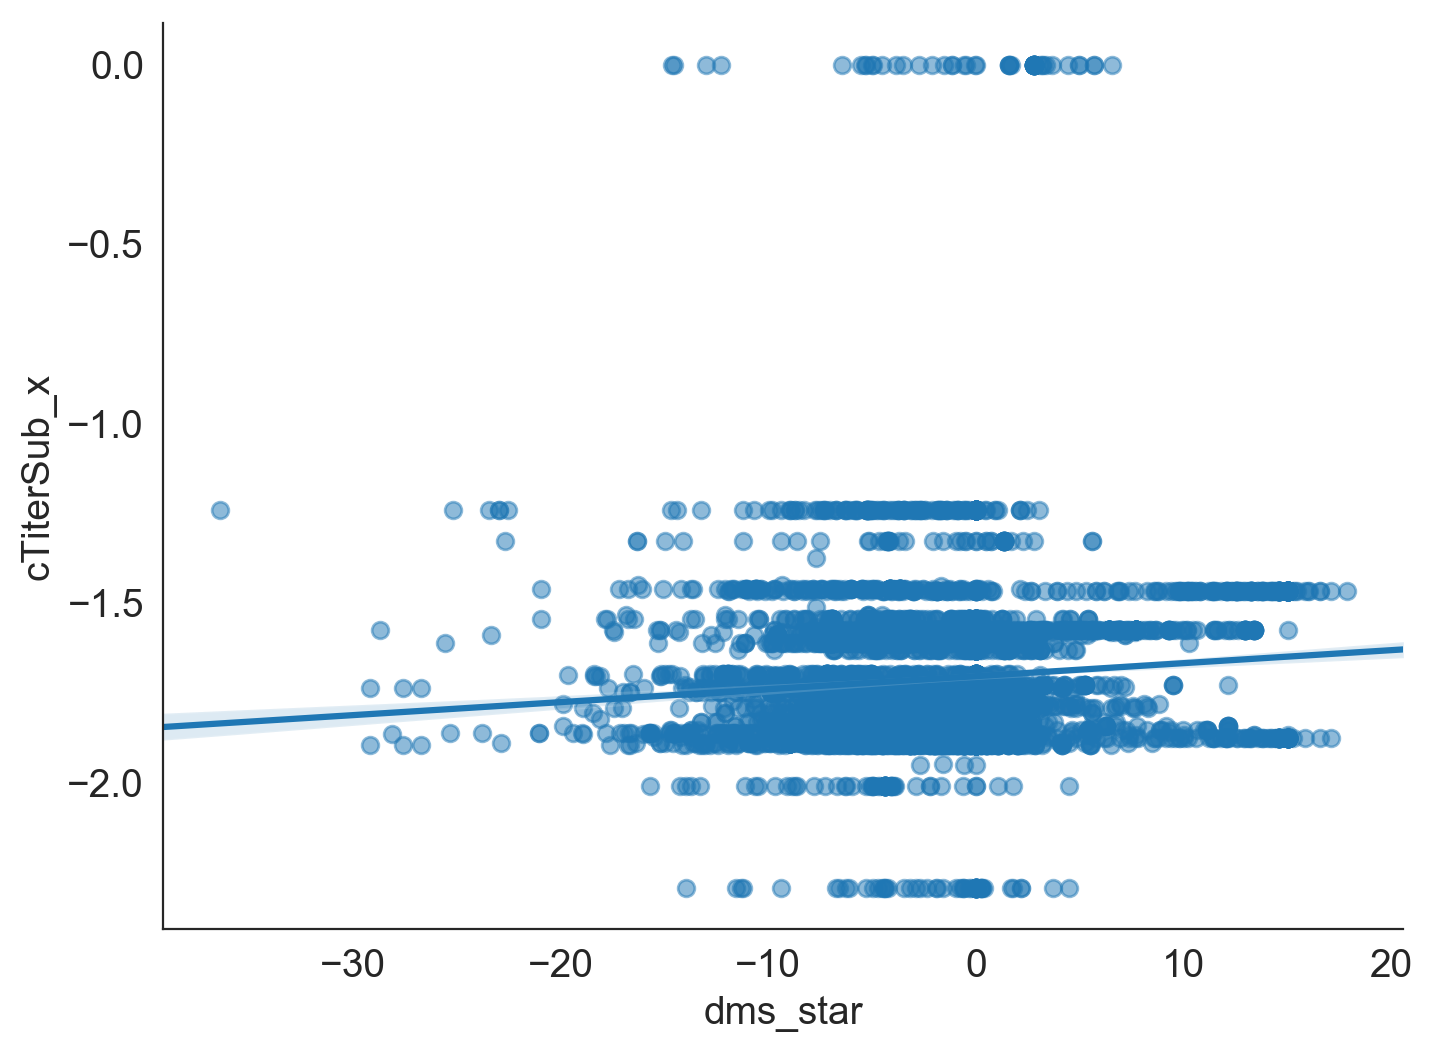

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("dms_star", "cTiterSub_x", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)

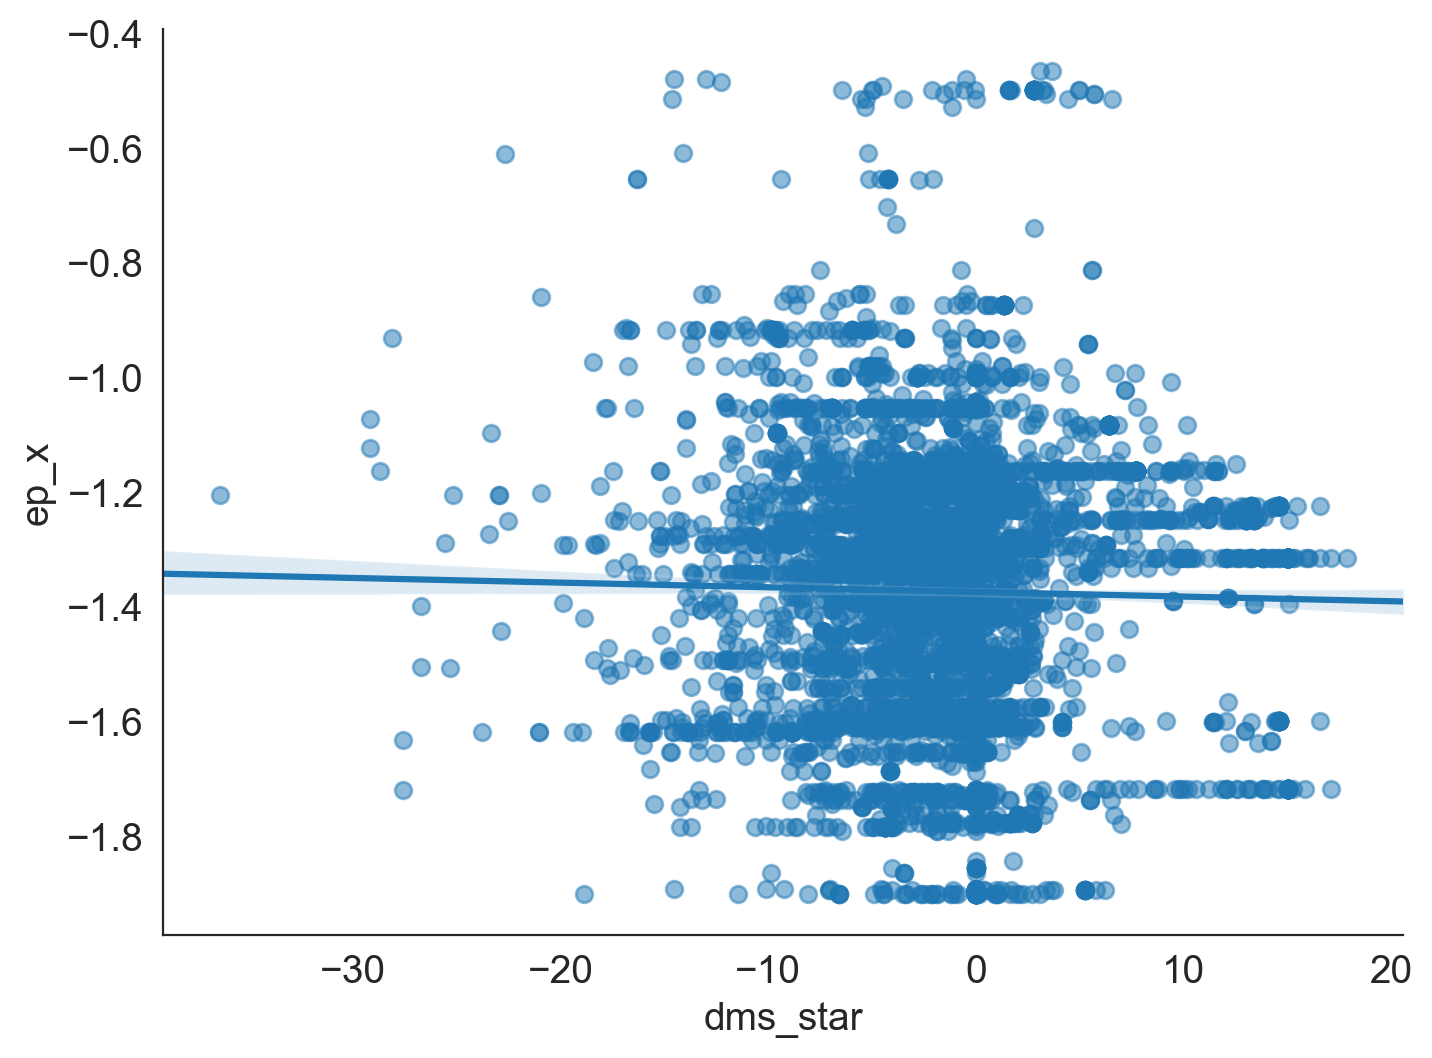

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot("dms_star", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5}, ax=ax)

In [54]:
tip_attributes_df.loc[tip_attributes_df["dms_star"] < -15, ["timepoint", "strain", "cTiterSub_x", "ep_x", "dms_star", "frequency", "raw_date"]].head()

timepoint               strain  cTiterSub_x      ep_x  dms_star  \
115 1994-04-01  A/New_York/753/1994    -2.010709 -1.682085    -15.69   
188 1995-04-01   A/Hong_Kong/3/1995    -1.326139 -0.609348    -22.67   
214 1995-04-01  A/New_York/676/1995    -1.326139 -0.653317    -16.31   
227 1995-04-01  A/New_York/692/1995    -1.326139 -0.653317    -16.31   
239 1995-10-01   A/Hong_Kong/3/1995    -1.807335 -0.971547    -18.44   

     frequency    raw_date  
115   0.015359  1994-02-15  
188   0.022133  1995-01-24  
214   0.022254  1995-01-18  
227   0.022254  1995-01-18  
239   0.001891  1995-01-24

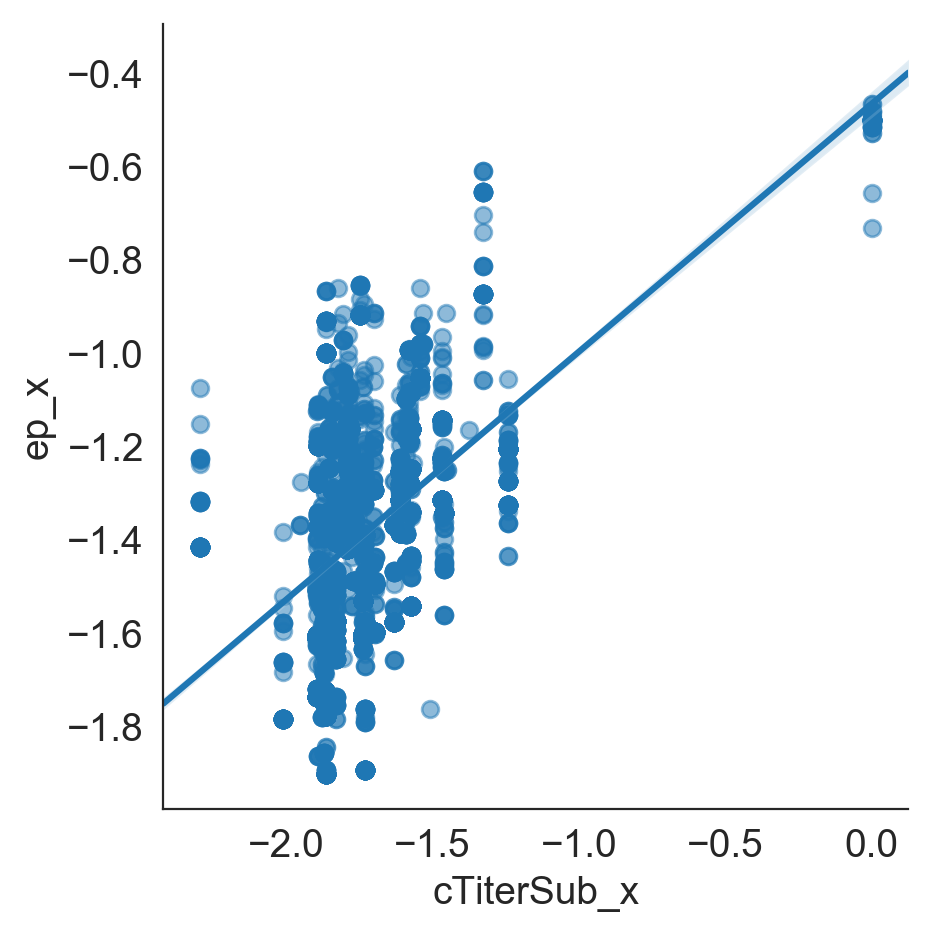

In [55]:
sns.lmplot("cTiterSub_x", "ep_x", tip_attributes_df, scatter_kws={"alpha": 0.5})

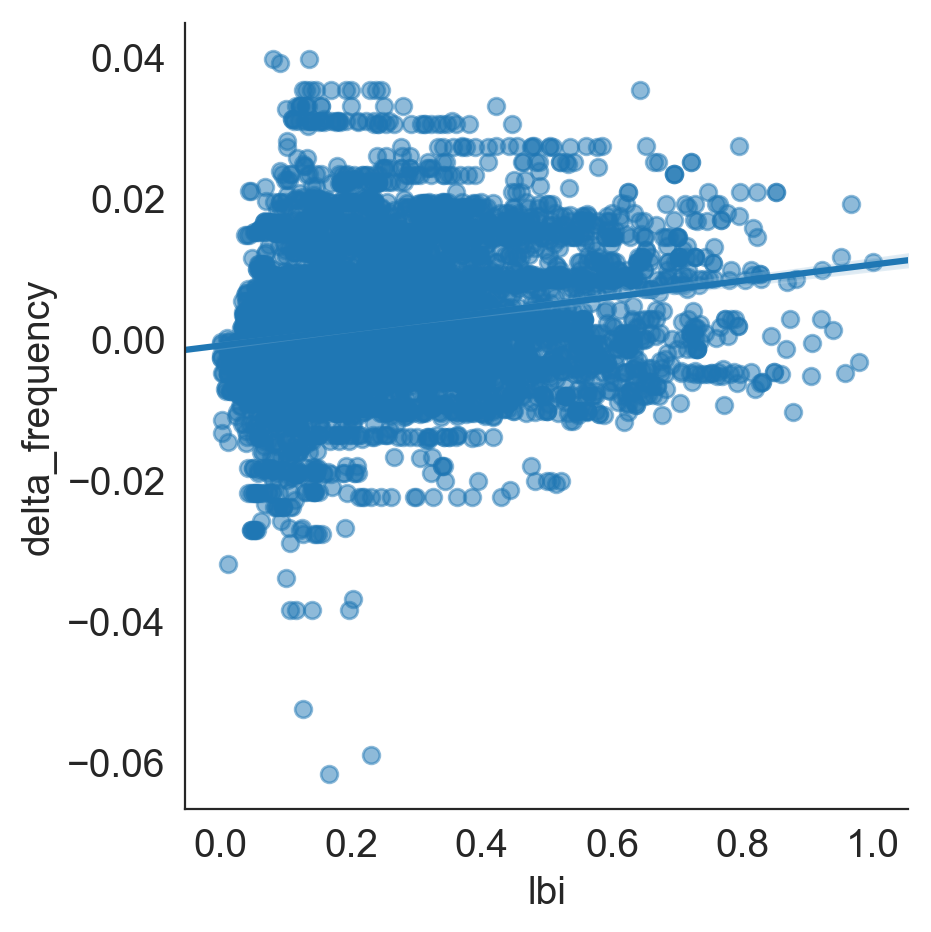

In [56]:
sns.lmplot("lbi", "delta_frequency", tip_attributes_df, scatter_kws={"alpha": 0.5})

## Summarize model residuals
[back to top](#Summarize-models)

In [57]:
residuals_by_timepoint = residual_df.groupby(["predictors", "timepoint"])["residual"].sum().reset_index()

In [58]:
residuals_by_timepoint.head()

predictors  timepoint     residual
0     cTiter 1993-10-01   178.344718
1     cTiter 1994-04-01   887.090574
2     cTiter 1994-10-01  1042.578754
3     cTiter 1995-04-01   716.735155
4     cTiter 1995-10-01   862.587476

In [59]:
residuals_by_timepoint.groupby("predictors")["residual"].sum()

predictors
cTiter              163294.371255
delta_frequency     166368.123568
ep_x                143314.689868
ep_x-ne_star        164153.771440
lbi                 217492.416437
lbi-ep_x-ne_star    202214.977780
naive               163049.480911
ne_star             183257.812901
Name: residual, dtype: float64

In [60]:
model_name = "lbi"

In [61]:
model_residuals_by_timepoint = residuals_by_timepoint[residuals_by_timepoint["predictors"] == model_name]

In [62]:
max_lags = 18

Text(0,0.5,'Number of clades')

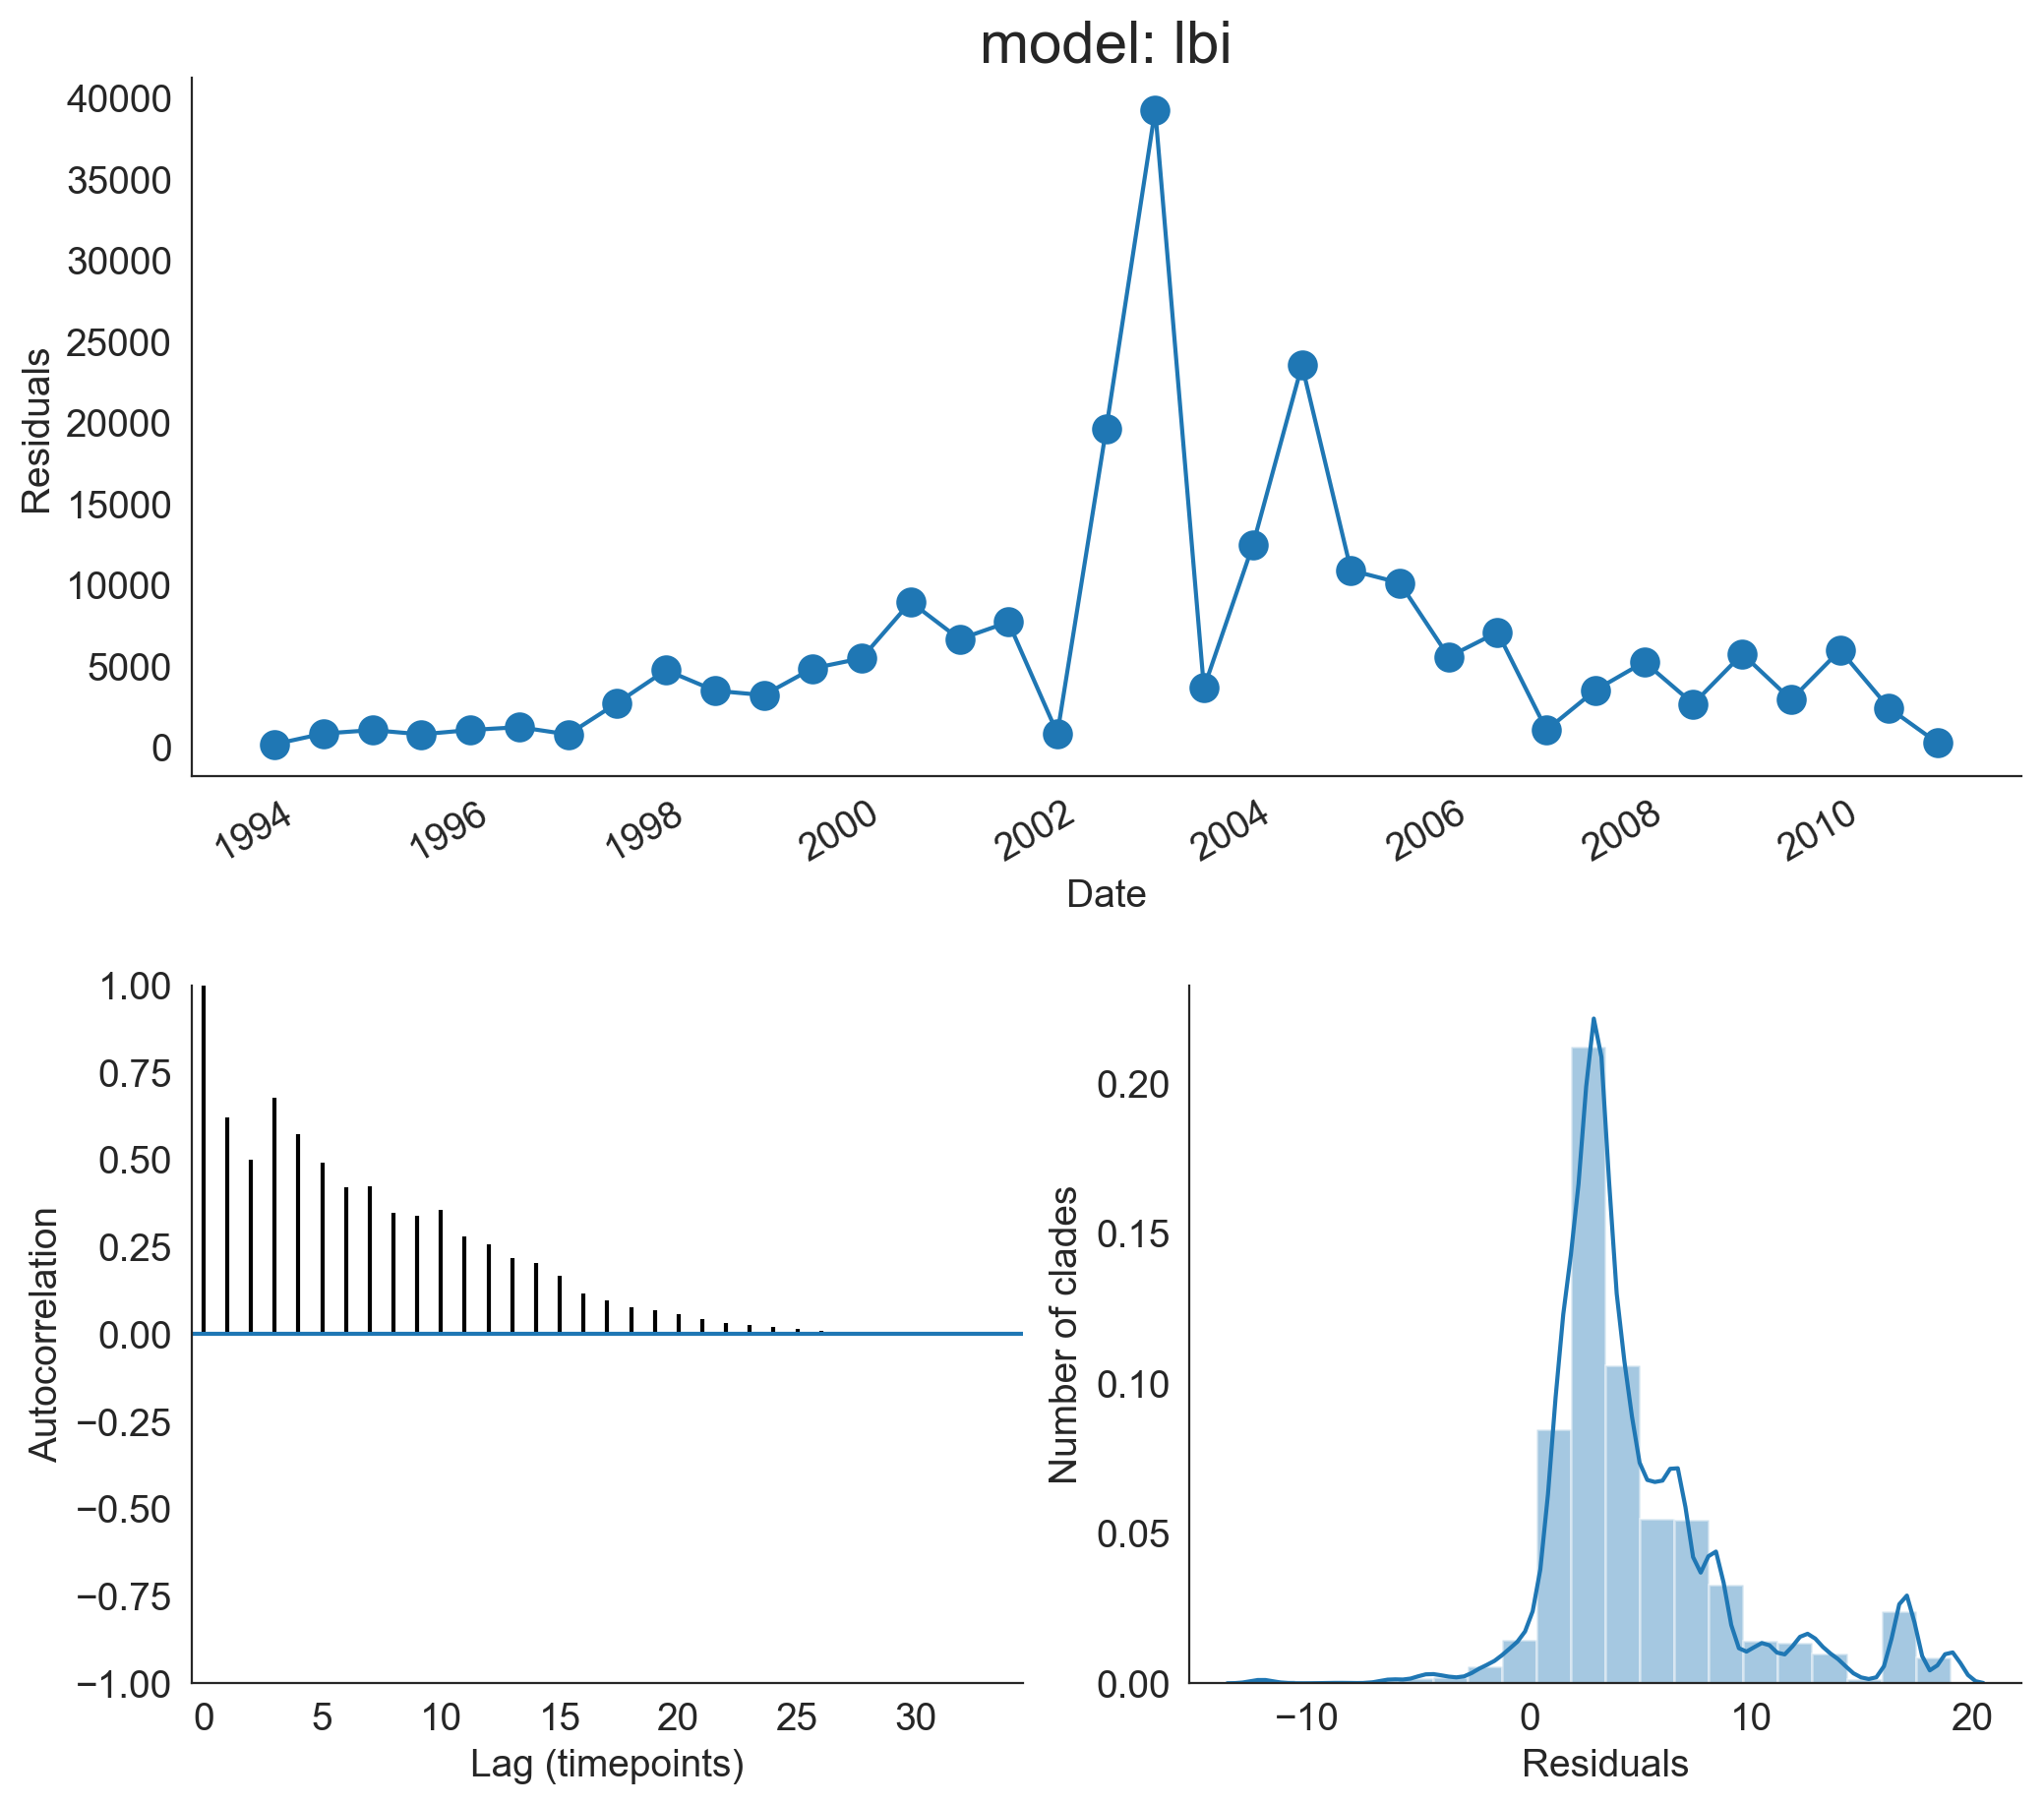

In [63]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3)

ax1 = plt.subplot(gs[0, :])
ax1.plot(model_residuals_by_timepoint["timepoint"], model_residuals_by_timepoint["residual"], "o-", markersize=10)
ax1.set_xlabel("Date")
ax1.set_ylabel("Residuals")
ax1.set_title("model: %s" % model_name)
plt.gcf().autofmt_xdate()

ax2 = plt.subplot(gs[1, :-1])
max_lags = len(model_residuals_by_timepoint["residual"]) - 1
lags, autocorrelation, lines, horizonal_lines = ax2.acorr(
    model_residuals_by_timepoint["residual"],
    maxlags=max_lags
)
ax2.set_xlabel("Lag (timepoints)")
ax2.set_ylabel("Autocorrelation")
ax2.set_xlim(-0.5, max_lags + 0.5)
ax2.set_ylim(-1, 1)

ax3 = plt.subplot(gs[1:, -1])
sns.distplot(residual_df.loc[residual_df["predictors"] == model_name, "residual"], ax=ax3, bins=20)
ax3.set_xlabel("Residuals")
ax3.set_ylabel("Number of clades")

### Residuals by predictor

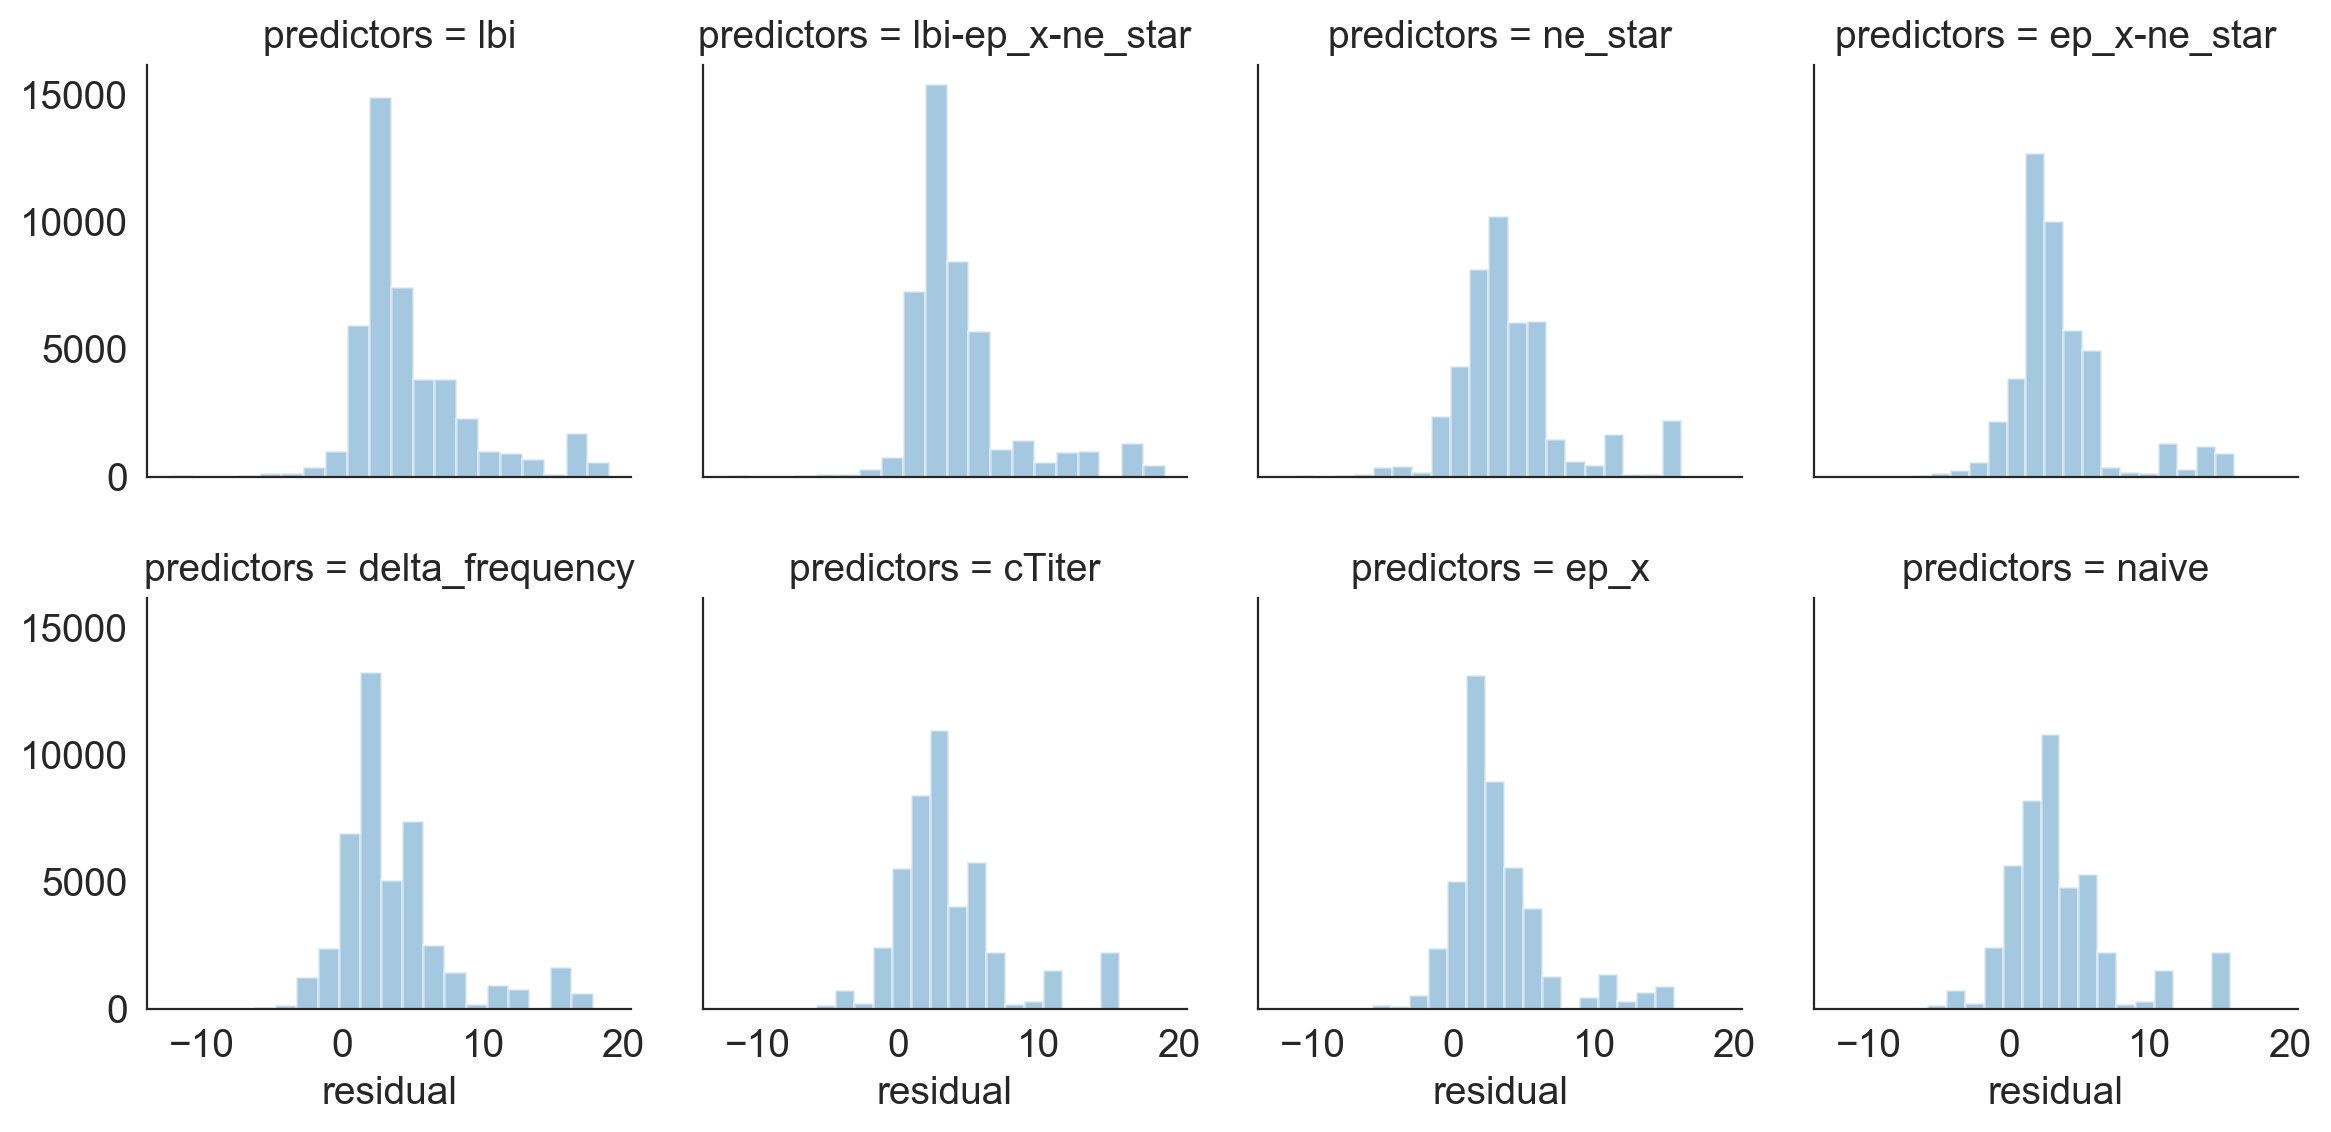

In [64]:
g = sns.FacetGrid(residual_df, col="predictors", col_wrap=4)
g.map(sns.distplot, "residual", bins=20, kde=False)

In [65]:
residual_df.groupby("predictors")["residual"].median().sort_values()

predictors
ep_x                2.360762
delta_frequency     2.470095
cTiter              2.692257
naive               2.692258
ep_x-ne_star        2.849781
lbi-ep_x-ne_star    3.303351
ne_star             3.334486
lbi                 3.407954
Name: residual, dtype: float64

In [66]:
residual_df.groupby("predictors")["residual"].count()

predictors
cTiter              45211
delta_frequency     45211
ep_x                45211
ep_x-ne_star        45211
lbi                 45211
lbi-ep_x-ne_star    45211
naive               45211
ne_star             45211
Name: residual, dtype: int64

In [67]:
(residual_df["residual"] < -0.01).sum()

28800

### Residuals by timepoint

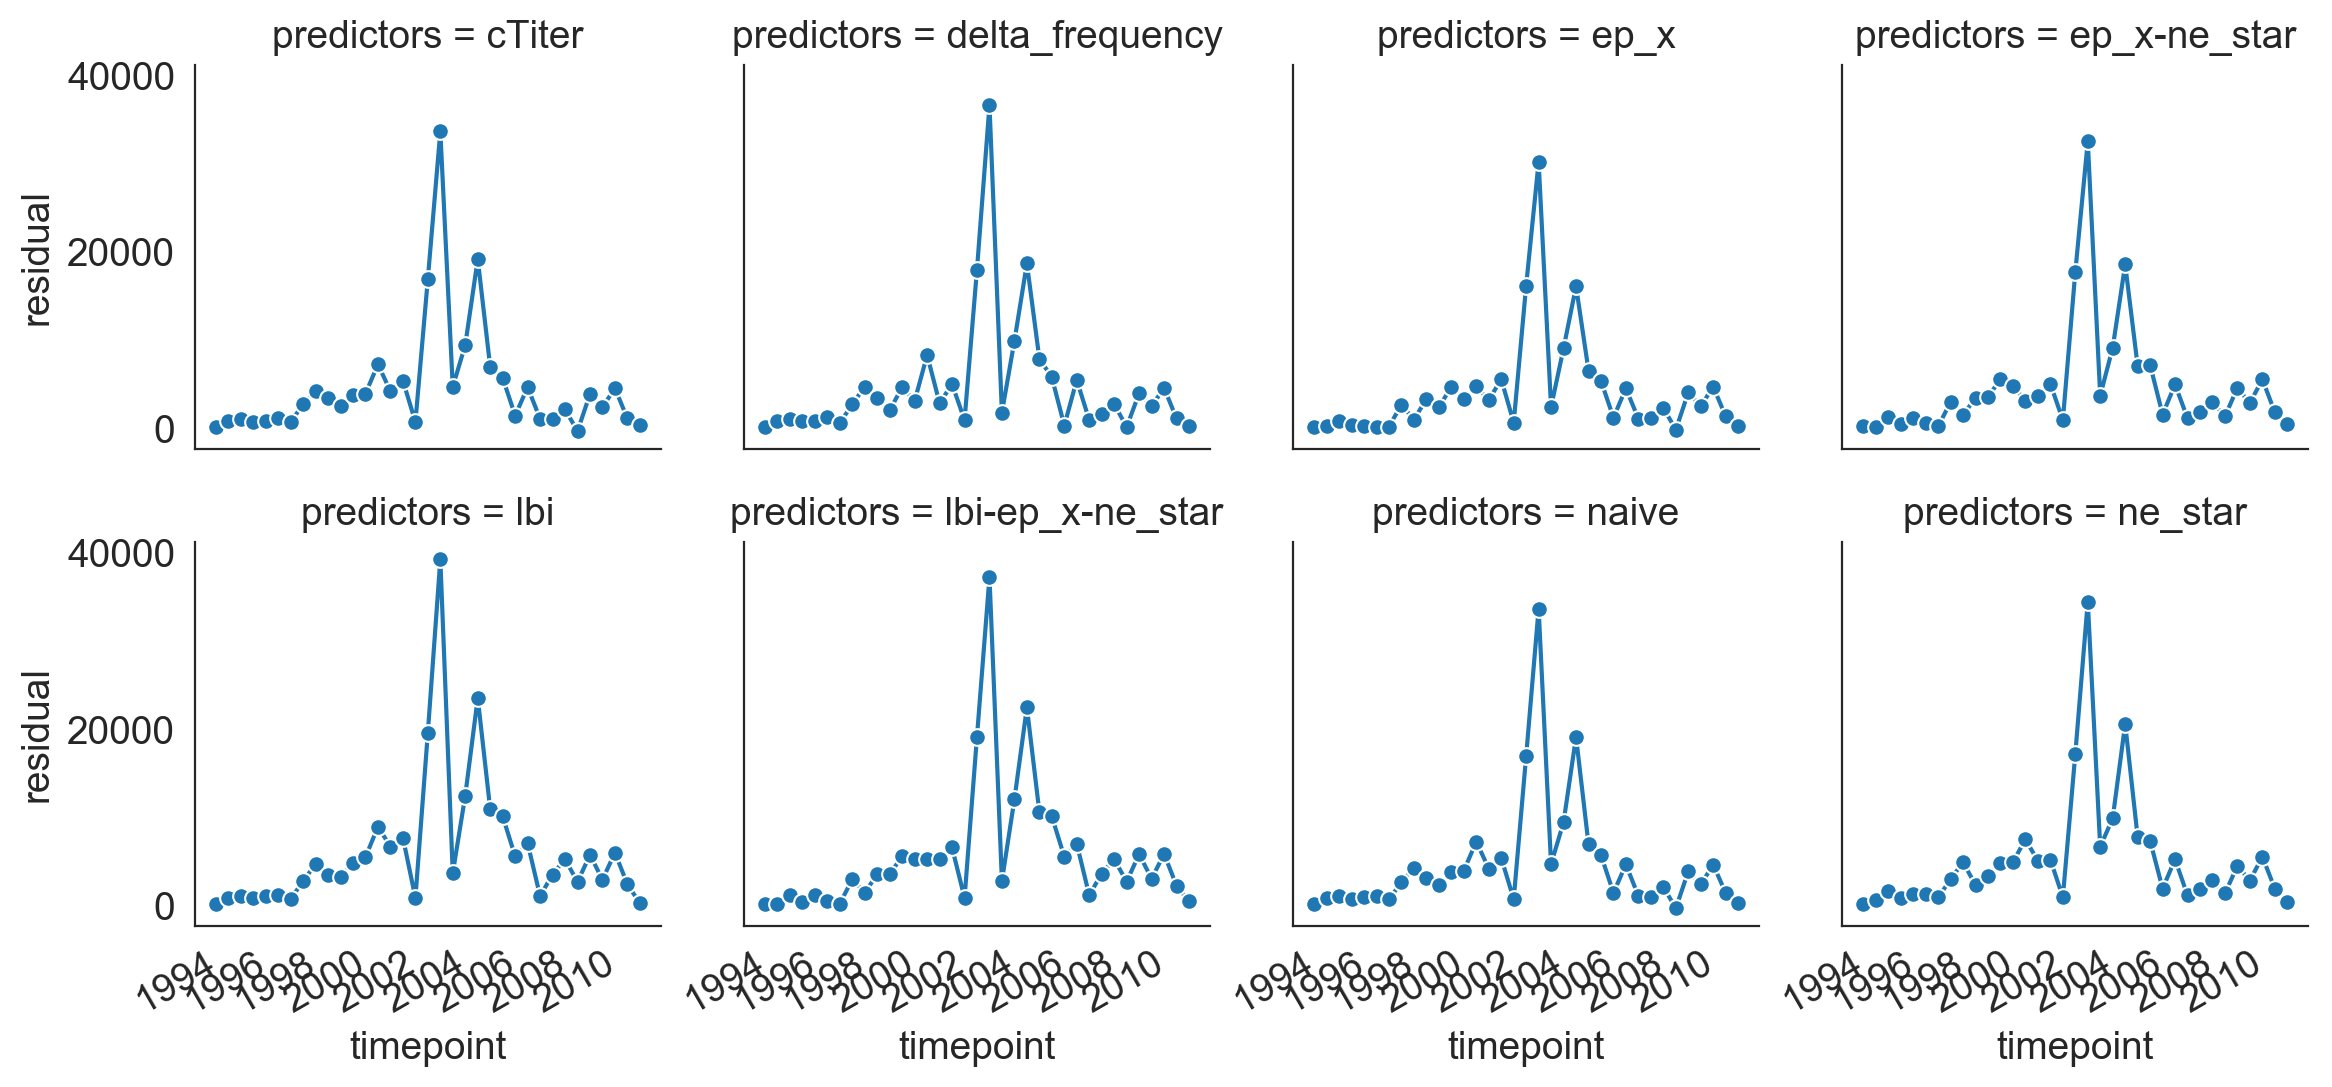

In [68]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(sns.lineplot, "timepoint", "residual", marker="o", linestyle="")
plt.gcf().autofmt_xdate()

In [69]:
np.abs(residuals_by_timepoint[residuals_by_timepoint["predictors"] == "lbi"]["residual"].values - residuals_by_timepoint[residuals_by_timepoint["predictors"] == "naive"]["residual"].values)

array([  31.00926564,   32.02521104,   37.50092078,   41.84794405,
         97.87795667,  108.24126396,  100.28930645,   74.5452688 ,
        515.32074596,  393.75922126,  860.88103128, 1030.55533861,
       1541.0540733 , 1712.8386133 , 2472.19906491, 2299.08985185,
        141.05359301, 2662.12427061, 5590.21197429, 1040.61824394,
       3027.08908407, 4412.44562372, 3977.05326237, 4410.51866408,
       4138.58428341, 2429.77809414,   10.03037751, 2502.37906689,
       3115.99943011, 3003.68894204, 1871.59803365,  532.19368012,
       1361.82157269,  991.38770572,   23.3782118 ])

### Autocorrelation of residuals

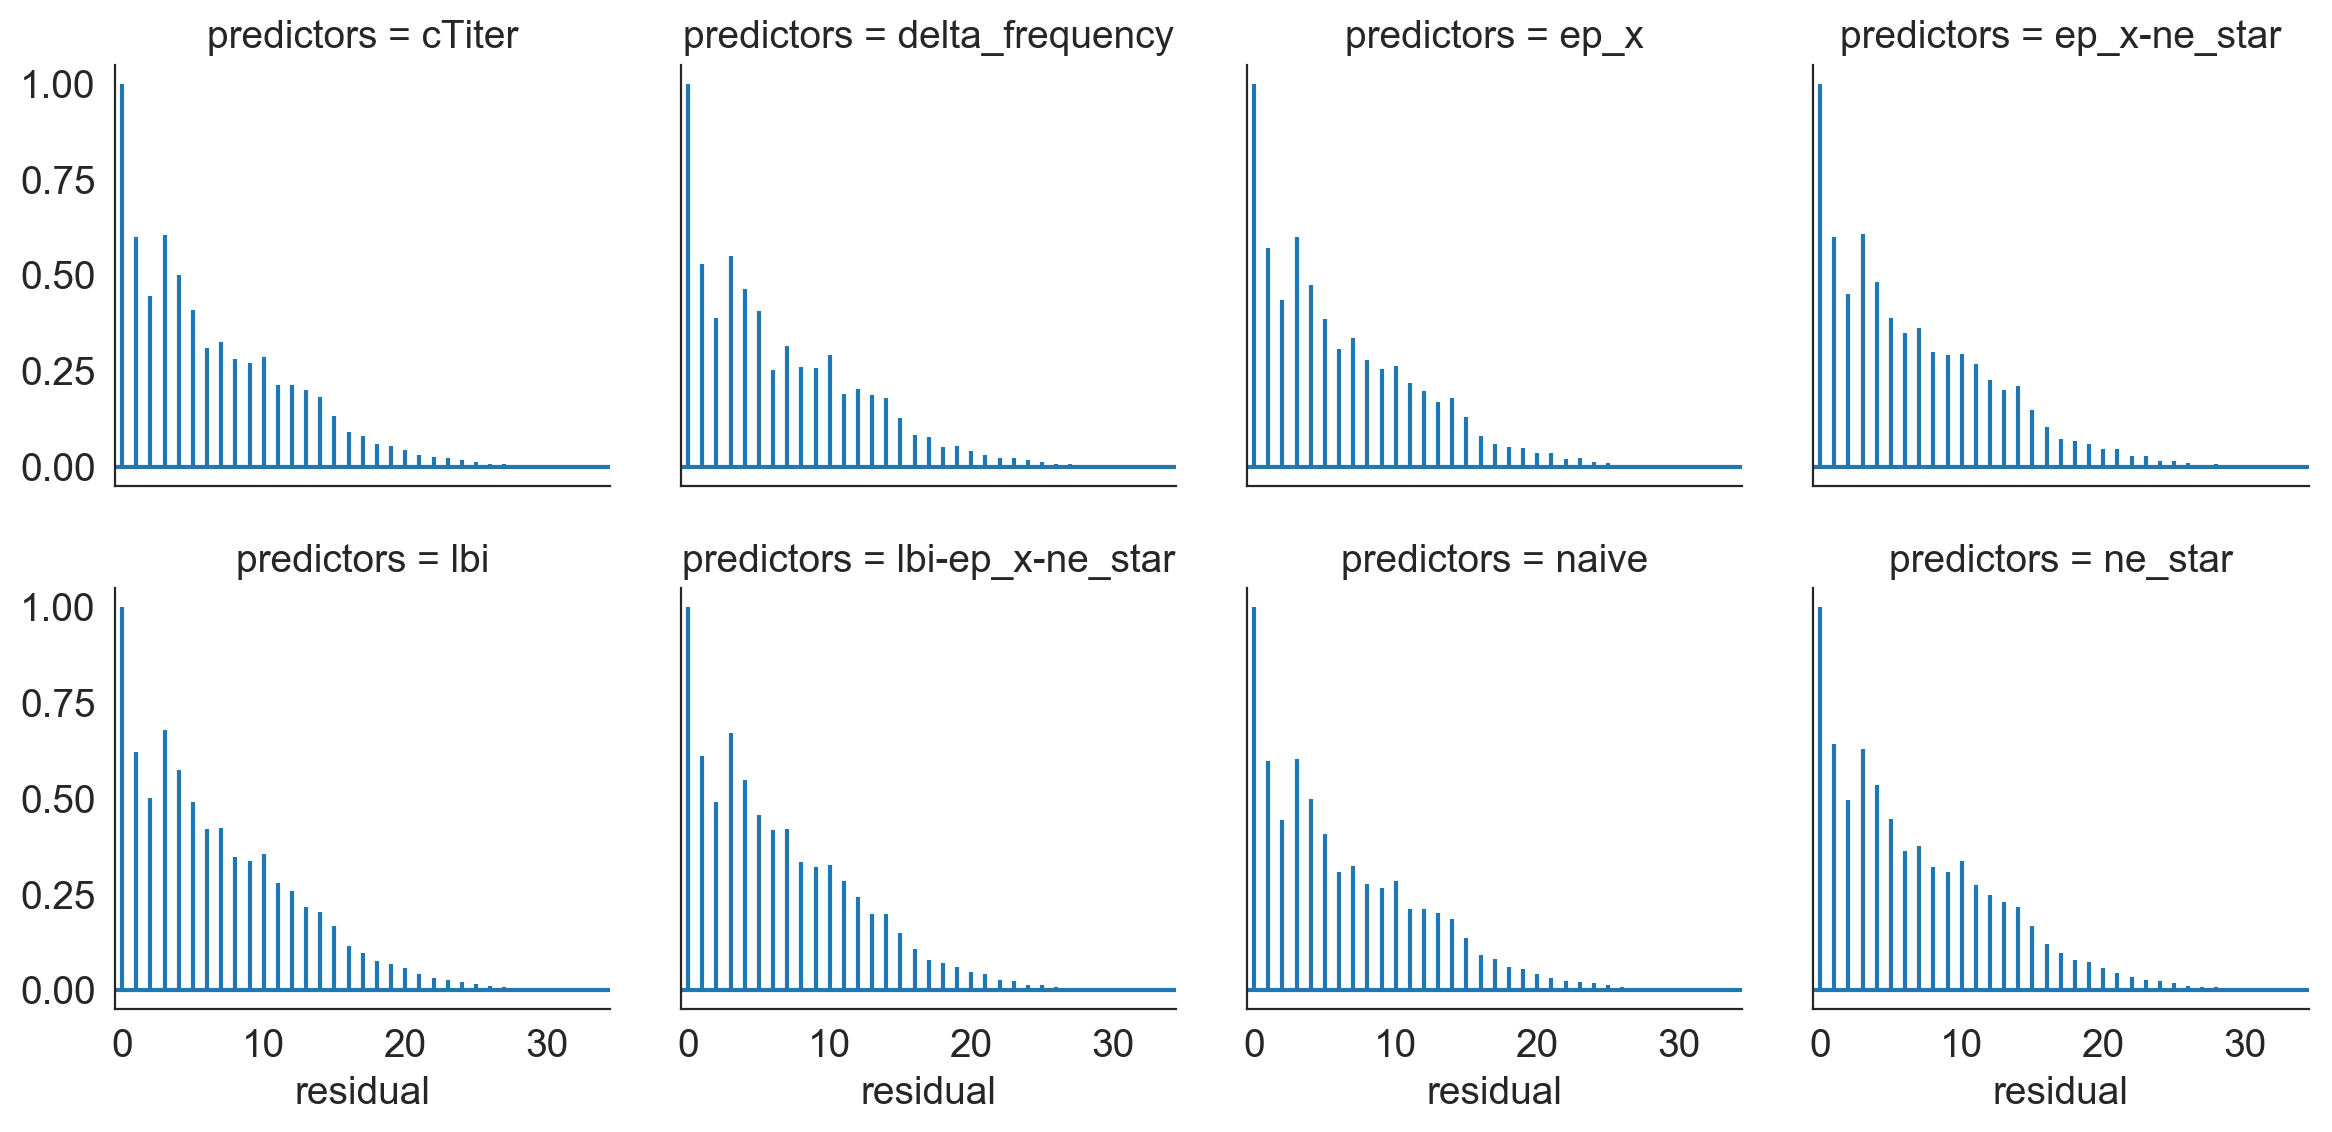

In [70]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(plt.acorr, "residual", maxlags=max_lags)

for ax in g.axes.flatten():
    ax.set_xlim(-0.5, max_lags + 0.5)

## Summarize observed and predicted distances
[back to top](#Summarize-models)

$$
d_{i}(x(t)) = \sum_{j}x_{j}d_{ij}
$$

$$
u = t + \Delta{t}
$$

$$
\hat{x}_{i}(t, u) = x_{i}(t)e^{(f_{i}(t)(u - t))}
$$

$$
y = x_{i}(t)d_{i}(x(u))
$$

$$
\hat{y} = x_{i}(t)d_{i}(\hat{x}(t, u))
$$

$$
D(x(t), x(u)) = \sum_{i}x_{i}d_{i}(u)
$$

$$
D(\hat{x}(t, u), x(u)) = \sum_{i}x_{i}e^{(f_{i}(t)(u - t))}d_{i}(u)
$$

$$
L = \sum_{t}D(\hat{x}(t, u), x(u))
$$

In [71]:
frequency_df[frequency_df["predictors"] == "lbi"].head()

fitness  frequency  projected_frequency               strain  timepoint  \
0 -0.244386   0.001225             0.001403  A/Auckland/583/2000 2000-10-01   
1 -0.285982   0.012312             0.013526  A/Auckland/588/2000 2000-10-01   
2 -0.280390   0.011459             0.012659  A/Auckland/589/2000 2000-10-01   
3 -0.373630   0.013150             0.013234  A/Auckland/599/2000 2000-10-01   
4 -0.334326   0.019185             0.020082  A/Auckland/600/2000 2000-10-01   

   weighted_distance_to_future_hat  weighted_distance_to_present     y_hat  \
0                        11.072537                      8.429604  8.602049   
1                         8.839685                      6.470370  5.950296   
2                         7.839685                      5.494997  4.977348   
3                         8.839685                      6.468194  5.949811   
4                        11.072537                      8.253836  8.436600   

   weighted_distance_to_future          y  residual validation_timepoint  \
0                    11.072537  11.072537  2.470488           2000-10-01   
1                     8.839685   8.839685  2.889389           2000-10-01   
2                     7.839685   7.839685  2.862337           2000-10-01   
3                     8.839685   8.839685  2.889874           2000-10-01   
4                    11.072537  11.072537  2.635937           2000-10-01   

  predictors  
0        lbi  
1        lbi  
2        lbi  
3        lbi  
4        lbi

In [72]:
frequency_df["observed_rank"] = frequency_df["y"] # / frequency_df["frequency"]
frequency_df["estimated_rank"] = frequency_df["y_hat"] # / frequency_df["frequency"]

In [73]:
data_to_plot = frequency_df[frequency_df["predictors"] == "lbi"]

In [74]:
minimum_observed_distance = data_to_plot.groupby("validation_timepoint")["observed_rank"].min().reset_index()

In [75]:
minimum_estimated_distance = data_to_plot.groupby("validation_timepoint")["estimated_rank"].min().reset_index()

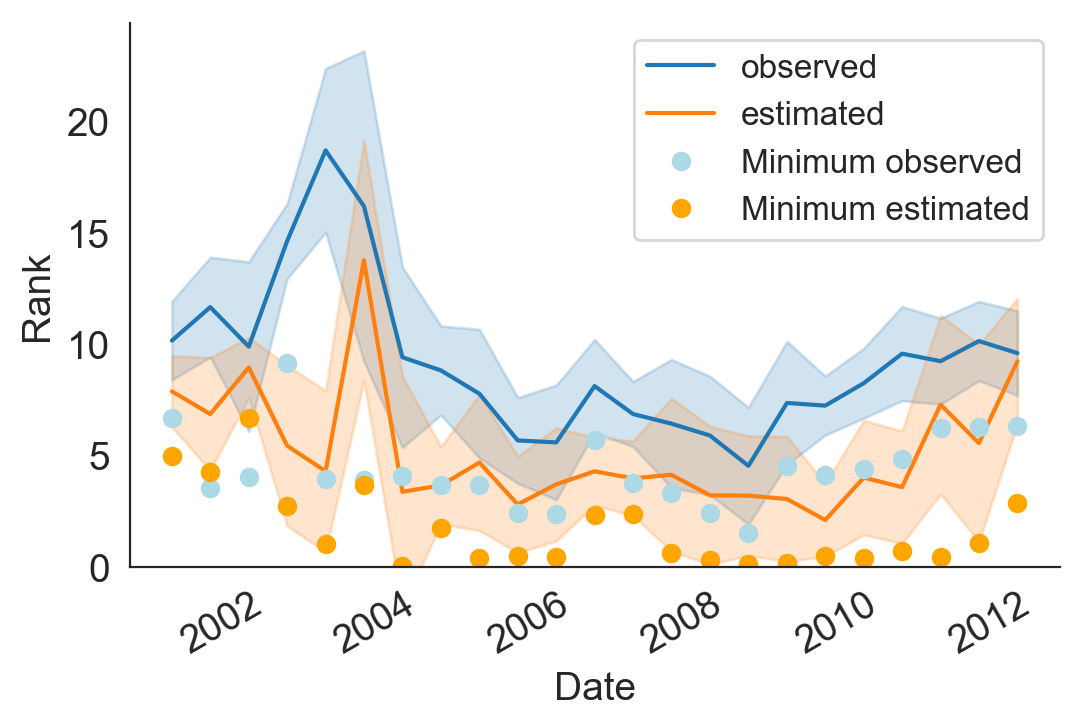

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax = sns.lineplot(
    "validation_timepoint",
    "observed_rank",
    data=data_to_plot,
    ci="sd",
    label="observed",
    ax=ax
)

ax = sns.lineplot(
    "validation_timepoint",
    "estimated_rank",
    data=data_to_plot,
    ci="sd",
    label="estimated",
    ax=ax
)

ax.plot(
    minimum_observed_distance["validation_timepoint"],
    minimum_observed_distance["observed_rank"],
    "o",
    color="lightblue",
    label="Minimum observed"
)

ax.plot(
    minimum_estimated_distance["validation_timepoint"],
    minimum_estimated_distance["estimated_rank"],
    "o",
    color="orange",
    label="Minimum estimated"
)

ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Rank")
ax.set_ylim(bottom=0)
plt.gcf().autofmt_xdate()

In [77]:
vaccine_strains = [
    "A/Wisconsin/67/2005",
    "A/Brisbane/10/2007",
    "A/Perth/16/2009",
    "A/Victoria/361/2011",
    "A/Texas/50/2012",
    "A/Switzerland/9715293/2013",
    "A/HongKong/4801/2014"
]

In [78]:
vaccine_strain_data_to_plot = data_to_plot.loc[data_to_plot["strain"].isin(vaccine_strains),
                                               ["strain", "validation_timepoint", "observed_rank", "estimated_rank"]]

In [79]:
vaccine_strain_data_to_plot

strain validation_timepoint  observed_rank  estimated_rank
3798  A/Perth/16/2009           2009-10-01        7.84205         2.35199

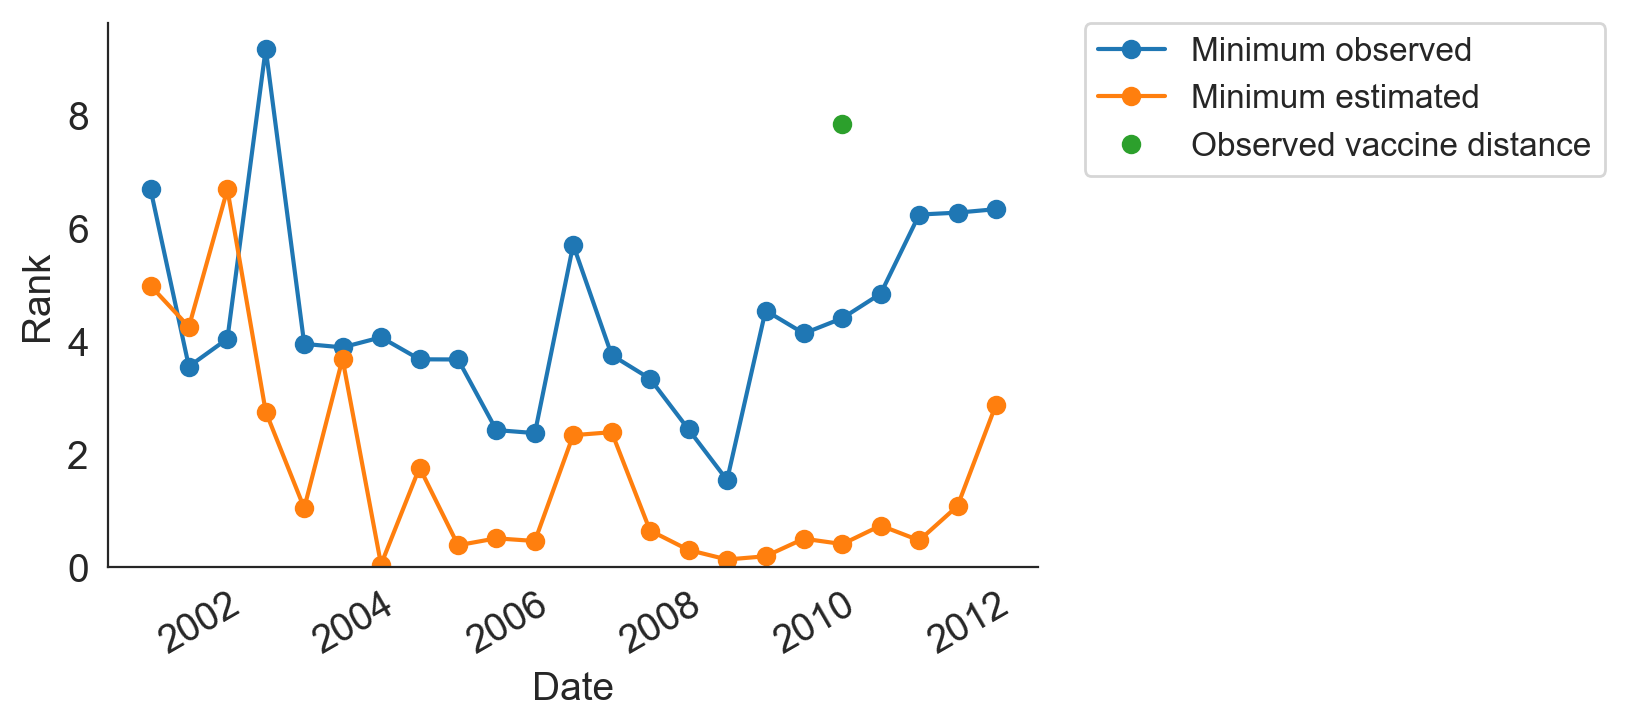

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(
    minimum_observed_distance["validation_timepoint"],
    minimum_observed_distance["observed_rank"],
    "o-",
    label="Minimum observed"
)

ax.plot(
    minimum_estimated_distance["validation_timepoint"],
    minimum_estimated_distance["estimated_rank"],
    "o-",
    label="Minimum estimated"
)

ax.plot(
    vaccine_strain_data_to_plot["validation_timepoint"],
    vaccine_strain_data_to_plot["observed_rank"],
    "o",
    label="Observed vaccine distance"
)

ax.set_xlabel("Date")
ax.set_ylabel("Rank")
ax.set_ylim(bottom=0)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.gcf().autofmt_xdate()

In [81]:
regressions = []
for predictors, group_df in frequency_df.groupby(["predictors"]):
    slope, intercept, r_value, p_value, std_err = linregress(
        group_df["y"],
        group_df["y_hat"]
    )
    
    regressions.append({
        "predictors": predictors,
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "r_2": r_value ** 2,
        "p_value": p_value
    })

regressions = pd.DataFrame(regressions).sort_values(by="r_2", ascending=False)

In [82]:
regressions

intercept        p_value        predictors       r_2   r_value     slope
2   2.123871   0.000000e+00              ep_x  0.432539  0.657677  0.511410
5   0.327894   0.000000e+00  lbi-ep_x-ne_star  0.365321  0.604418  0.561507
6   2.279286   0.000000e+00             naive  0.323282  0.568579  0.412770
3   2.169240   0.000000e+00      ep_x-ne_star  0.322981  0.568314  0.439367
0   2.289642   0.000000e+00            cTiter  0.294931  0.543076  0.404030
4   0.288577   0.000000e+00               lbi  0.293953  0.542175  0.526294
1   1.815561   0.000000e+00   delta_frequency  0.288060  0.536712  0.463709
7   2.841917  1.100358e-229           ne_star  0.182765  0.427510  0.287571

In [83]:
regressions_order = regressions["predictors"].values

In [84]:
regressions_order

array(['ep_x', 'lbi-ep_x-ne_star', 'naive', 'ep_x-ne_star', 'cTiter',
       'lbi', 'delta_frequency', 'ne_star'], dtype=object)

In [85]:
final_frequency_df = frequency_df[frequency_df["predictors"].isin(best_models)].copy()

In [86]:
final_frequency_df["predictors_name"] = final_frequency_df["predictors"].map(dict(zip(best_models, best_predictor_names)))

In [87]:
final_frequency_df.head()

fitness  frequency  projected_frequency               strain  timepoint  \
0 -0.244386   0.001225             0.001403  A/Auckland/583/2000 2000-10-01   
1 -0.285982   0.012312             0.013526  A/Auckland/588/2000 2000-10-01   
2 -0.280390   0.011459             0.012659  A/Auckland/589/2000 2000-10-01   
3 -0.373630   0.013150             0.013234  A/Auckland/599/2000 2000-10-01   
4 -0.334326   0.019185             0.020082  A/Auckland/600/2000 2000-10-01   

   weighted_distance_to_future_hat  weighted_distance_to_present     y_hat  \
0                        11.072537                      8.429604  8.602049   
1                         8.839685                      6.470370  5.950296   
2                         7.839685                      5.494997  4.977348   
3                         8.839685                      6.468194  5.949811   
4                        11.072537                      8.253836  8.436600   

   weighted_distance_to_future          y  residual validation_timepoint  \
0                    11.072537  11.072537  2.470488           2000-10-01   
1                     8.839685   8.839685  2.889389           2000-10-01   
2                     7.839685   7.839685  2.862337           2000-10-01   
3                     8.839685   8.839685  2.889874           2000-10-01   
4                    11.072537  11.072537  2.635937           2000-10-01   

  predictors  observed_rank  estimated_rank predictors_name  
0        lbi      11.072537        8.602049             LBI  
1        lbi       8.839685        5.950296             LBI  
2        lbi       7.839685        4.977348             LBI  
3        lbi       8.839685        5.949811             LBI  
4        lbi      11.072537        8.436600             LBI

IndexError: index 0 is out of bounds for axis 0 with size 0

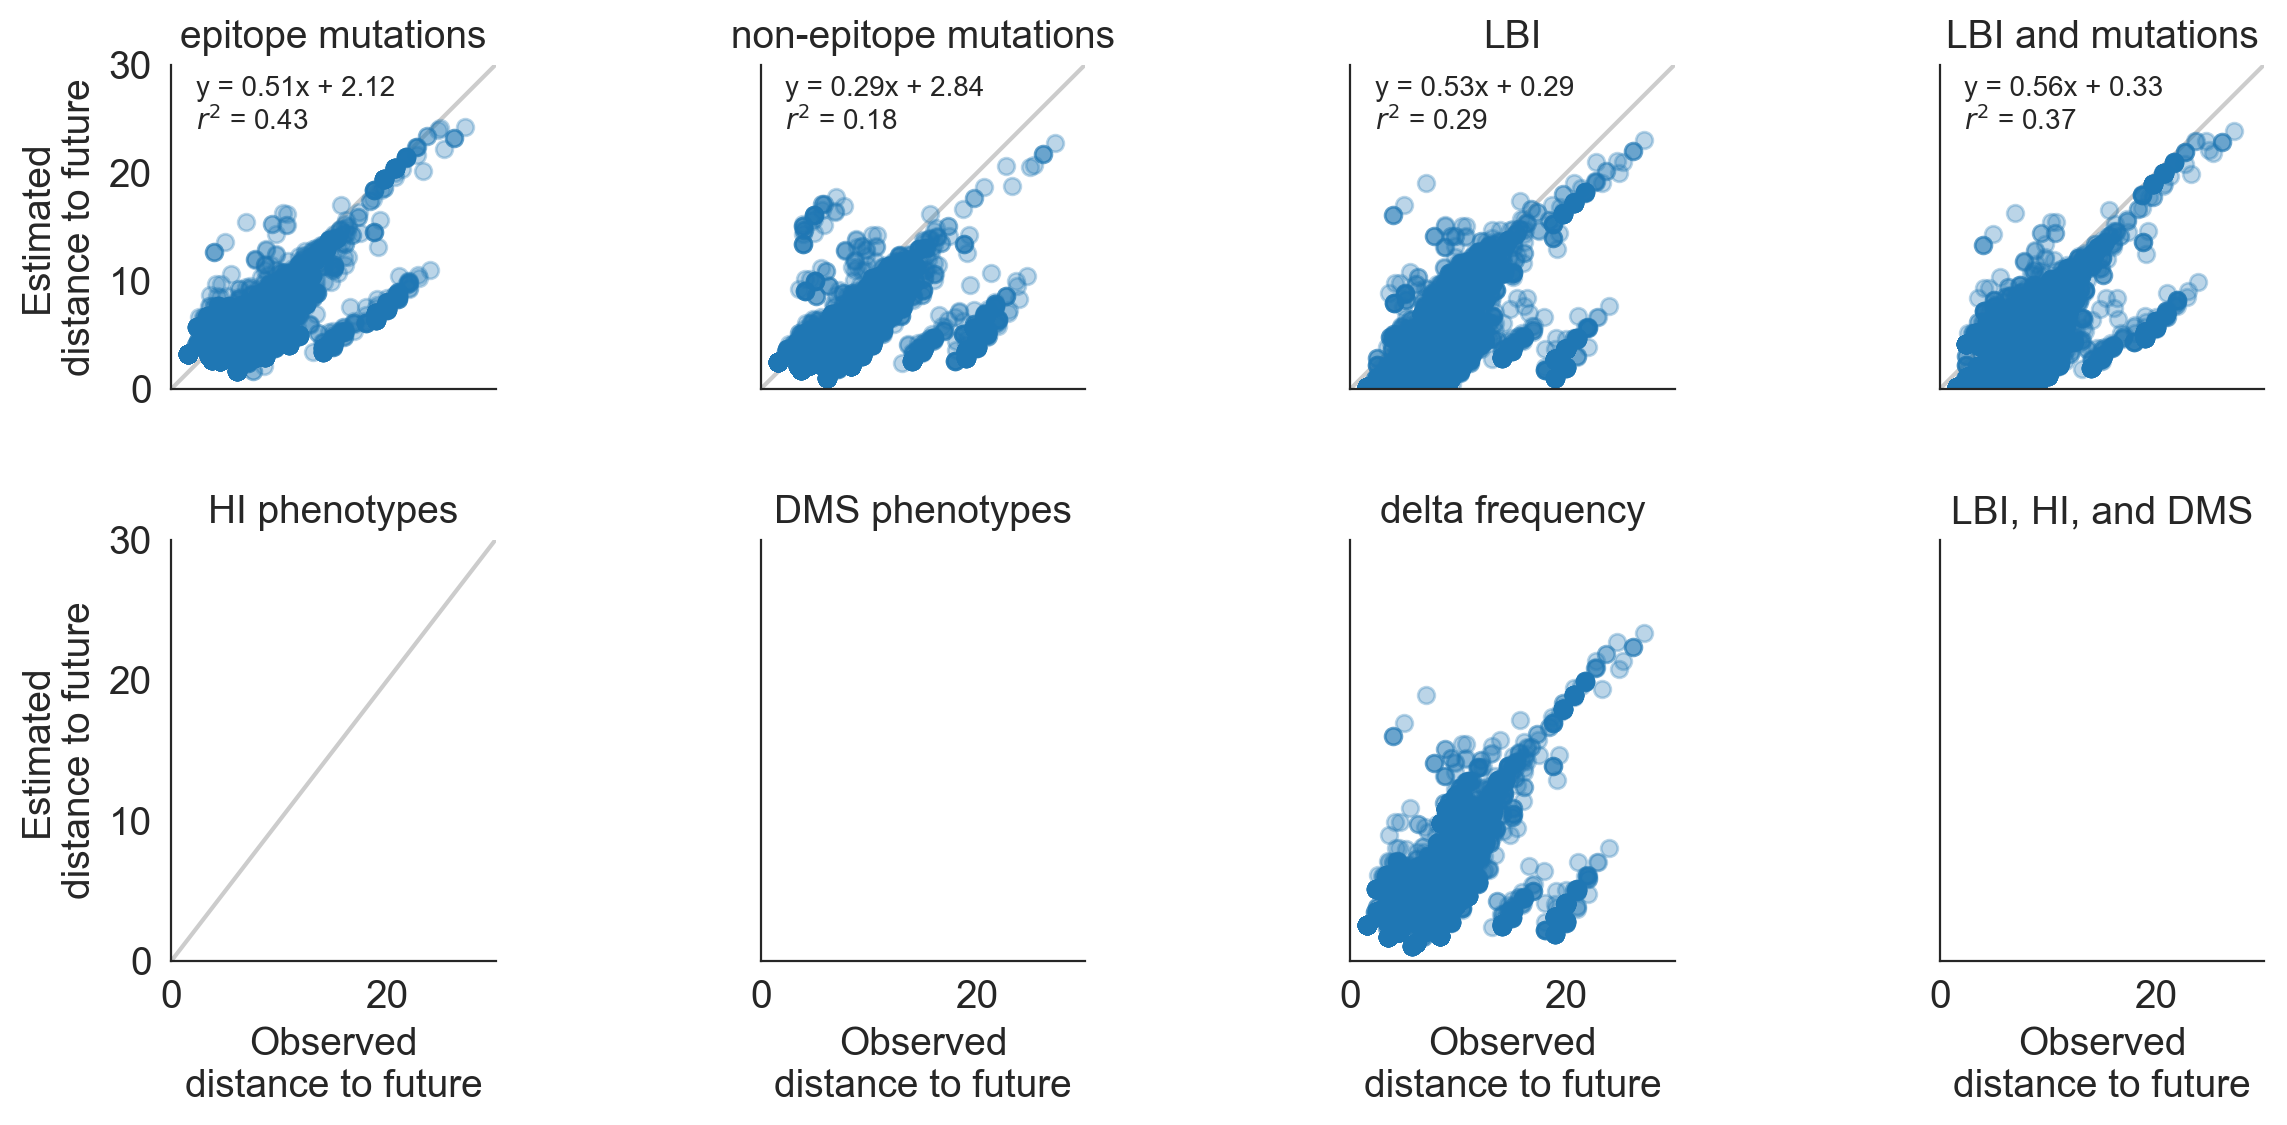

In [88]:
max_y = 30
x = y = np.linspace(0, max_y, 10)

g = sns.FacetGrid(final_frequency_df, col="predictors_name", col_wrap=4, col_order=best_predictor_names)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{col_name}")
g.set_axis_labels("Observed\ndistance to future", "Estimated\ndistance to future")

for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    ax.plot(x, y, color="#cccccc", zorder=-10)
    
    slope, intercept, r_value, p_value = regressions.loc[
        regressions["predictors"] == facet_df["predictors"].unique()[0],
        ["slope", "intercept", "r_value", "p_value"]
    ].values[0]
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    if intercept < 0:
        intercept_operator = "-"
        intercept = -intercept
    else:
        intercept_operator = "+"
    
    ax.text(
        0.075,
        0.8,
        "y = %.2fx %s %.2f\n$r^2$ = %.2f%s" % (slope, intercept_operator, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=10
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, max_y)
    ax.set_ylim(0, max_y)
    
plt.suptitle(
    "Model correlations compared to naive $r^2 = %.2f$" % regressions.loc[regressions["predictors"] == "naive", "r_2"].values[0],
    fontsize=12,
    y=1.0
)
plt.subplots_adjust(hspace=0.75, top=0.75, wspace=0.05)
plt.tight_layout()

In [ ]:
max_y = 30
x = y = np.linspace(0, max_y, 10)

g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4, col_order=regressions_order)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{col_name}")

for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value = regressions.loc[
        regressions["predictors"] == facet_df["predictors"].unique()[0],
        ["slope", "intercept", "r_value", "p_value"]
    ].values[0]
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    ax.plot(x, y, color="#cccccc", zorder=-10)
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=10
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, max_y)
    ax.set_ylim(0, max_y)

In [ ]:
ax = frequency_df[frequency_df["predictors"] == "naive"]["y"].hist(bins=30)
ax.set_xlabel("weighted distance to the future")
ax.set_ylabel("number of strains")

mean_y = frequency_df[frequency_df["predictors"] == "naive"]["y"].mean()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.35,
    0.75,
    "mean = %.2f" % (mean_y,),
    transform=ax.transAxes,
    fontsize=12
)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"], bins=10)
ax.set_xlabel("weighted distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].mean()
std_y = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-natural-populations-between-timepoints.png")

In [ ]:
best_models = [
    "naive",
    "lbi-dms_star-cTiterSub_x",
    "lbi-delta_frequency",
    "lbi",
    "lbi-ep_x-ne_star"
]

In [ ]:
max_y = 30
x = y = np.linspace(0, max_y, 10)

g = sns.FacetGrid(frequency_df[frequency_df["predictors"].isin(best_models)], col="predictors", col_wrap=4)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{col_name}")

for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value, std_err = linregress(
        facet_df["y"],
        facet_df["y_hat"]
    )
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    ax.plot(x, y, color="#cccccc", zorder=-10)
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=10
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, max_y)
    ax.set_ylim(0, max_y)

In [ ]:
frequency_df["year_month"] = frequency_df["validation_timepoint"].dt.strftime("%Y-%m")
frequency_df["year"] = frequency_df["validation_timepoint"].dt.strftime("%Y")

In [ ]:
max_y = 30
x = y = np.linspace(0, max_y, 10)

g = sns.FacetGrid(frequency_df[frequency_df["predictors"].isin(best_models)], row="predictors", col="year", height=4)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{row_name}, {col_name}")

regressions_by_time = []
for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value, std_err = linregress(
        facet_df["y"],
        facet_df["y_hat"]
    )
    
    regressions_by_time.append({
        "predictors": facet_df["predictors"].unique()[0],
        "timepoint": facet_df["timepoint"].unique()[0],
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "p_value": p_value
    })
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    ax.plot(x, y, color="#cccccc", zorder=-10)
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=12
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, max_y)
    ax.set_ylim(0, max_y)
    
plt.tight_layout()

In [ ]:
frequency_df.head()

In [ ]:
regressions_by_time = []
for (predictors, timepoint), group_df in frequency_df.groupby(["predictors", "timepoint"]):
    slope, intercept, r_value, p_value, std_err = linregress(
        group_df["y"],
        group_df["y_hat"]
    )
    
    regressions_by_time.append({
        "predictors": predictors,
        "timepoint": timepoint,
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "p_value": p_value
    })

regressions_by_time = pd.DataFrame(regressions_by_time)

In [ ]:
regressions_by_time.head()

In [ ]:
naive_regressions_by_time = regressions_by_time[regressions_by_time["predictors"] == "naive"]
non_naive_regressions_by_time = regressions_by_time[regressions_by_time["predictors"] != "naive"]

In [ ]:
"""
max_y = 25
x = y = np.linspace(0, max_y, 10)

g = sns.FacetGrid(frequency_df, row="predictors", col="year_month", height=4)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{row_name}, {col_name}")

regressions_by_time = []
for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value, std_err = linregress(
        facet_df["y"],
        facet_df["y_hat"]
    )
    
    regressions_by_time.append({
        "predictors": facet_df["predictors"].unique()[0],
        "timepoint": facet_df["timepoint"].unique()[0],
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "p_value": p_value
    })
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    ax.plot(x, y, color="#cccccc", zorder=-10)
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=12
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, max_y)
    ax.set_ylim(0, max_y)
    
plt.tight_layout()"""

## Summarize model forecasting error
[back to top](#Summarize-models)

### Earth mover's distances

Training and validation errors are reported as [earth mover's distances](https://en.wikipedia.org/wiki/Earth_mover%27s_distance). These values minimize the distance between observed and projected frequencies of tips at each timepoint with Hamming distance between amino acid sequences providing the ground distance between each pair of tips in respective timepoints.

In [89]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0        lbi          0.035306           141           2000-10-01
1        lbi          0.606493            89           2001-04-01
2        lbi          0.411306            60           2001-10-01
3        lbi          0.276685           142           2002-04-01
4        lbi          0.834474           200           2002-10-01

In [90]:
distance_df = errors_by_time_df.groupby("predictors")["validation_error"].aggregate([
    "sum",
    "mean",
    "median"
]).sort_values(by="sum").reset_index()

In [91]:
distance_df

predictors       sum      mean    median
0               lbi  3.795920  0.165040  0.150347
1  lbi-ep_x-ne_star  3.938537  0.171241  0.092239
2   delta_frequency  5.946592  0.258547  0.201773
3      ep_x-ne_star  6.599297  0.286926  0.268354
4           ne_star  6.797410  0.295540  0.225375
5             naive  6.976116  0.303309  0.256728
6            cTiter  7.133111  0.310135  0.270160
7              ep_x  7.340673  0.319160  0.313109

In [92]:
distance_df.loc[distance_df["predictors"] == "naive", "sum"].values[0]

6.9761157341443925

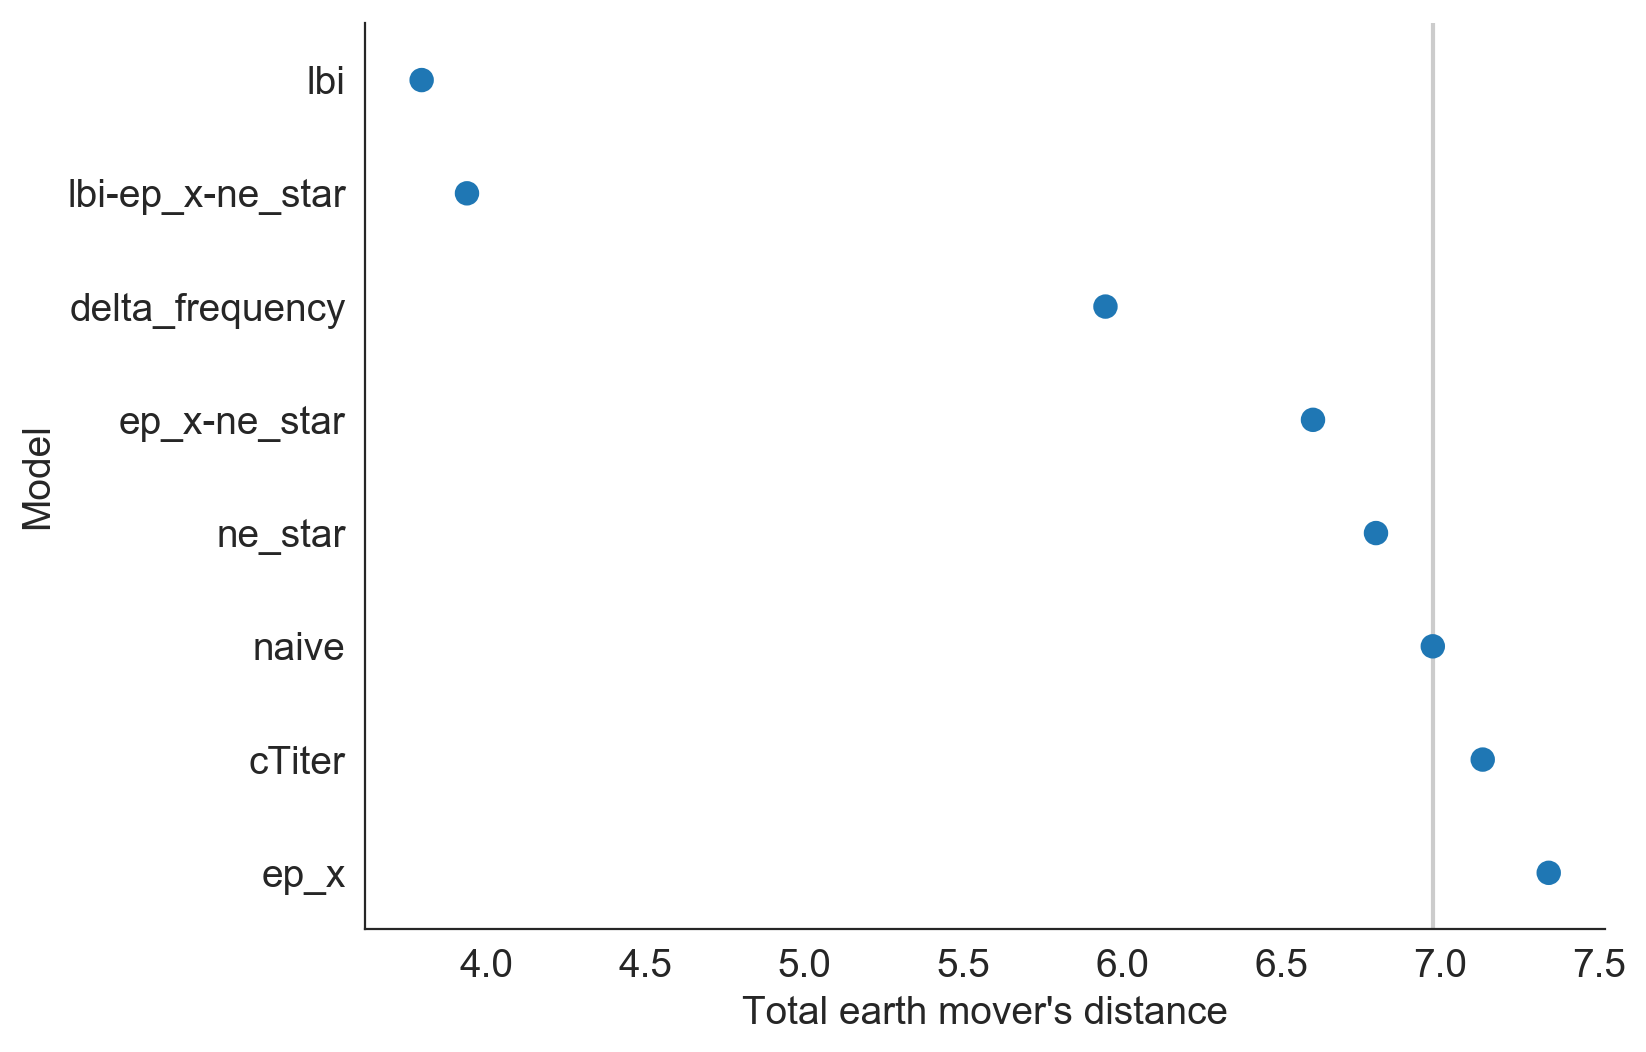

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="sum",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax
)

ax.set_xlabel("Total earth mover's distance")
ax.set_ylabel("Model")
ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "sum"].values[0],
    color="#cccccc",
    zorder=-10
)

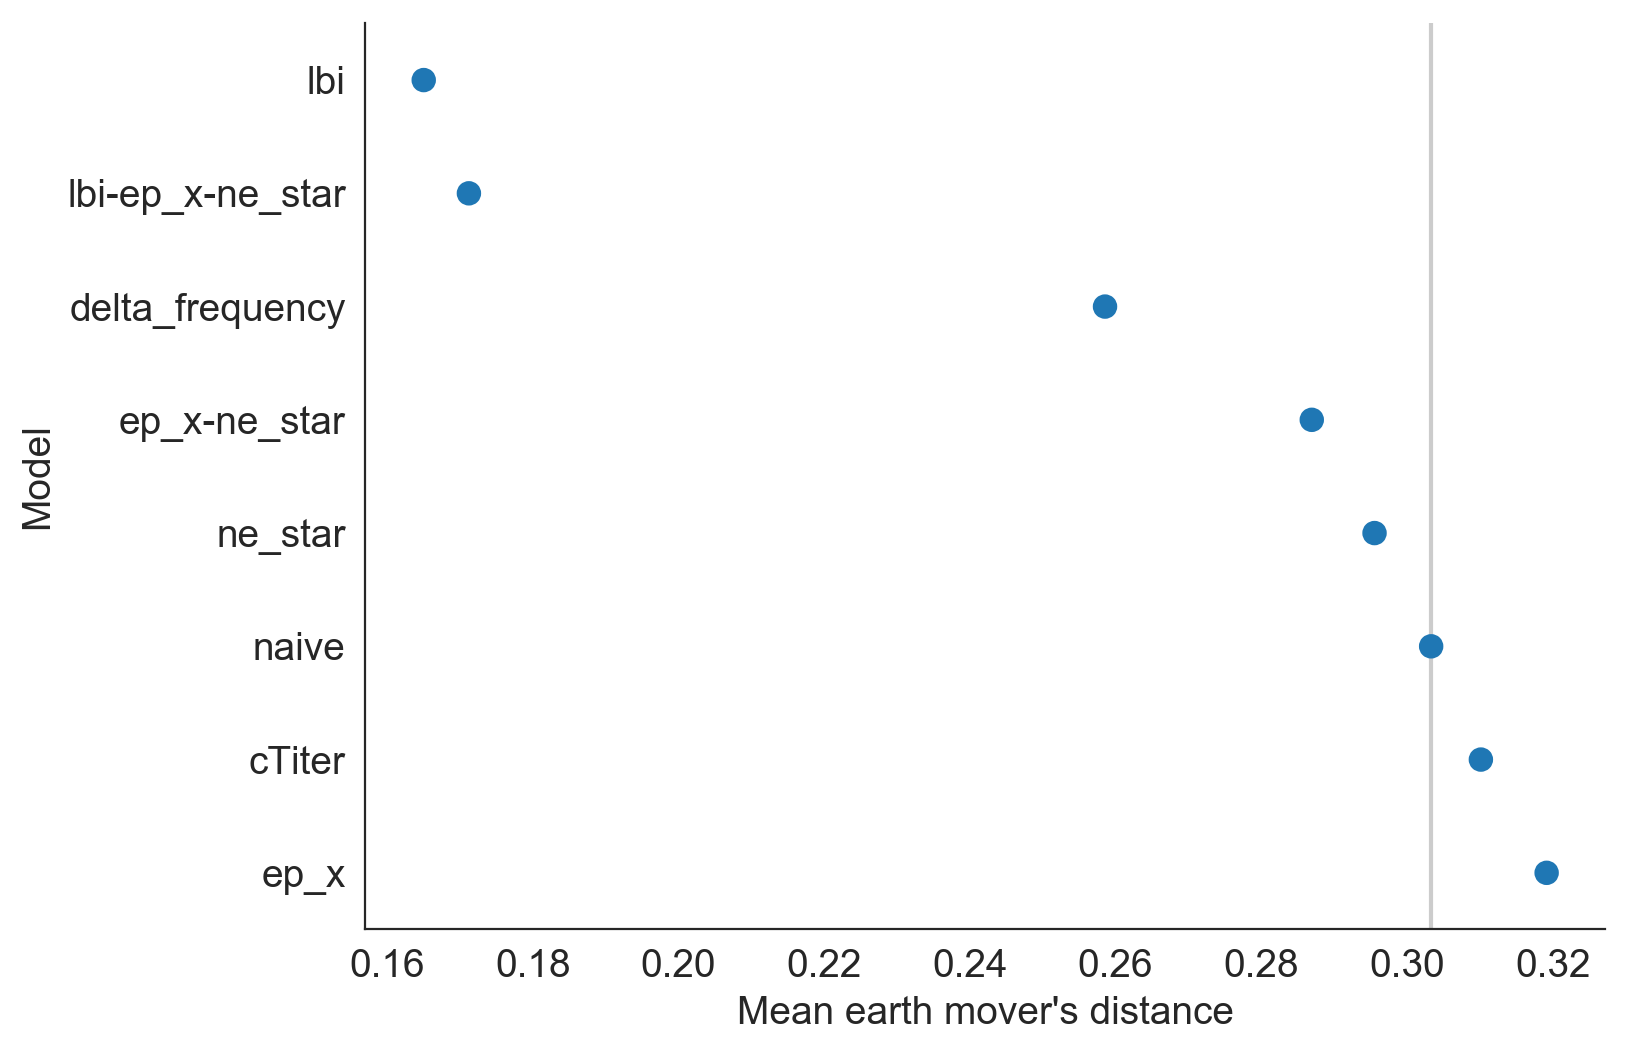

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mean",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax
)

ax.set_xlabel("Mean earth mover's distance")
ax.set_ylabel("Model")

ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "mean"].values[0],
    color="#cccccc",
    zorder=-10
)

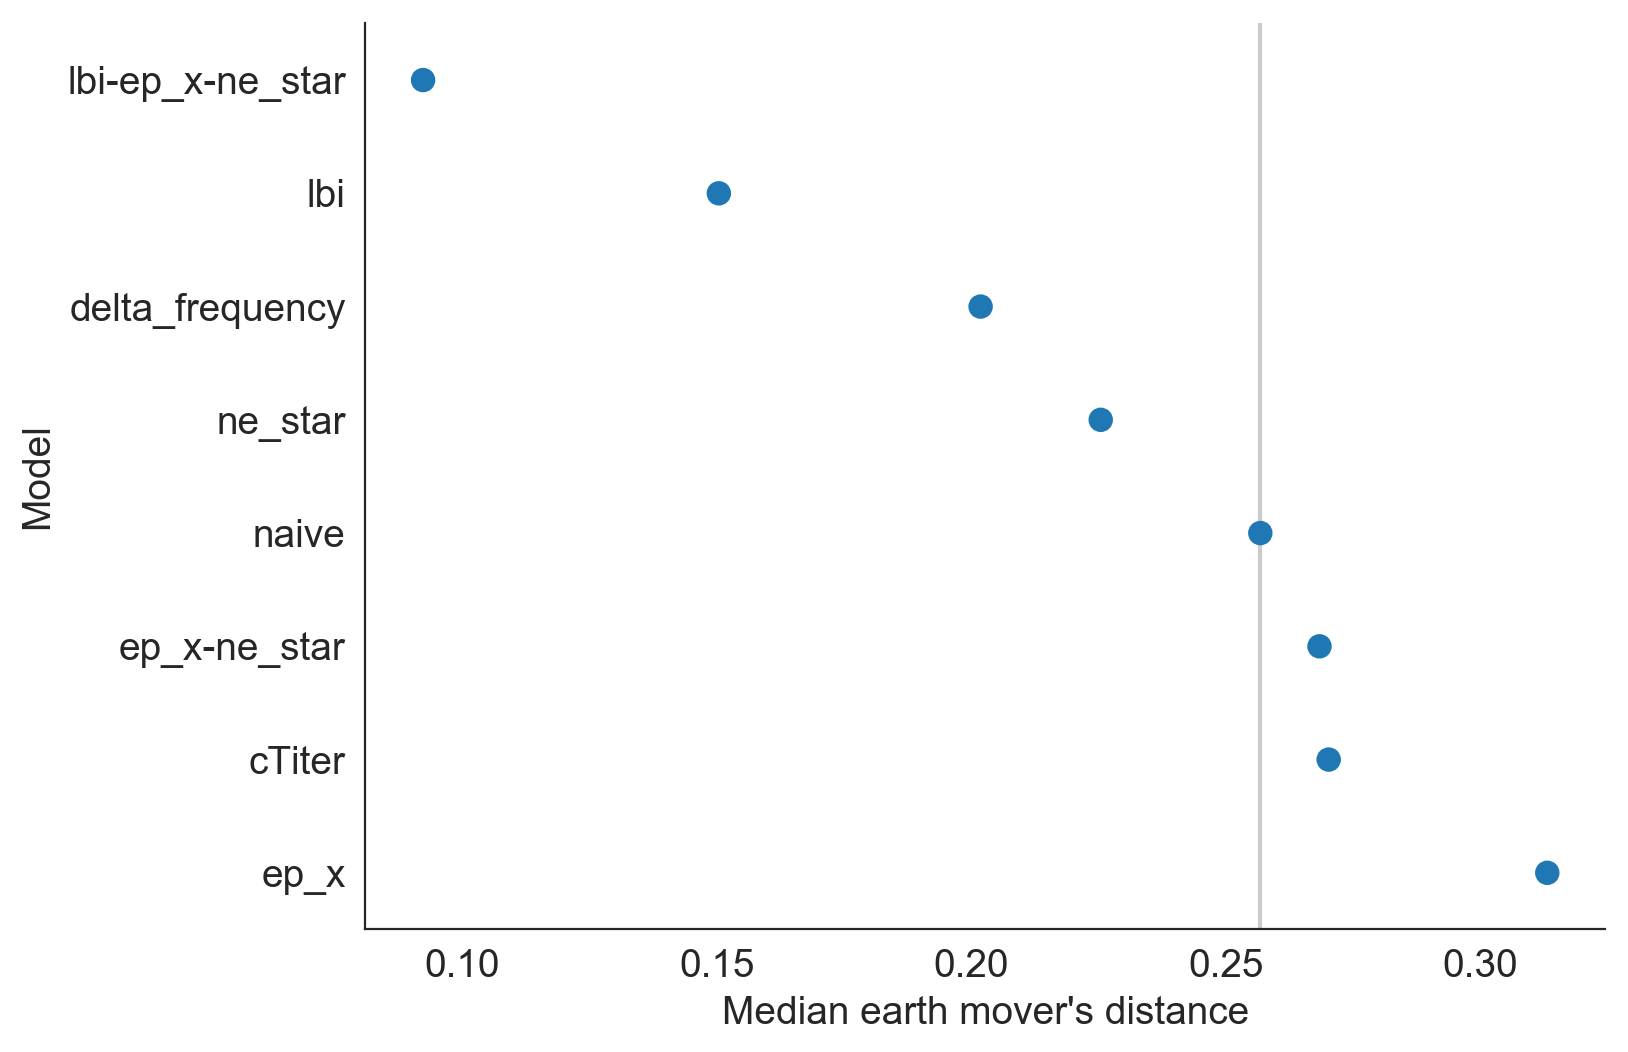

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="median",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax,
    order=distance_df.sort_values("median").loc[:, "predictors"]
)

ax.set_xlabel("Median earth mover's distance")
ax.set_ylabel("Model")

ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "median"].values[0],
    color="#cccccc",
    zorder=-10
)

In [96]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0        lbi          0.035306           141           2000-10-01
1        lbi          0.606493            89           2001-04-01
2        lbi          0.411306            60           2001-10-01
3        lbi          0.276685           142           2002-04-01
4        lbi          0.834474           200           2002-10-01

In [101]:
predictor_type_order = [
    "naive",
    "cTiter",
    "ep_x",
    "ne_star",
    "lbi",
    "delta_frequency"
]

In [102]:
predictor_names = [
    "null",
    "HI phenotypes",
    "epitope cross-immunity",
    "non-epitope mutations",
    "LBI",
    "delta frequency"
]

In [103]:
"""
predictor_type_order = [
    "naive",
    "lbi"
]
predictor_names = predictor_type_order
"""

'\npredictor_type_order = [\n    "naive",\n    "lbi"\n]\npredictor_names = predictor_type_order\n'

In [104]:
predictor_name_by_id = dict(zip(predictor_type_order, predictor_names))

In [105]:
predictor_name_by_id

{'naive': 'null',
 'cTiter': 'HI phenotypes',
 'ep_x': 'epitope cross-immunity',
 'ne_star': 'non-epitope mutations',
 'lbi': 'LBI',
 'delta_frequency': 'delta frequency'}

In [106]:
errors_by_time_df["predictors_name"] = errors_by_time_df["predictors"].map(predictor_name_by_id)

In [107]:
errors_by_time_df[errors_by_time_df["predictors"] == "naive"]

predictors  validation_error  validation_n validation_timepoint  \
161      naive          0.040975           141           2000-10-01   
162      naive          0.607478            89           2001-04-01   
163      naive          0.411306            60           2001-10-01   
164      naive          0.276685           142           2002-04-01   
165      naive          0.790331           200           2002-10-01   
166      naive          0.553486           116           2003-04-01   
167      naive          0.481018           158           2003-10-01   
168      naive          0.542399           338           2004-04-01   
169      naive          0.242697           256           2004-10-01   
170      naive          0.214406           281           2005-04-01   
171      naive          0.256728           250           2005-10-01   
172      naive          0.230694           154           2006-04-01   
173      naive          0.386035            42           2006-10-01   
174      naive          0.270160           181           2007-04-01   
175      naive          0.192591           270           2007-10-01   
176      naive          0.342177           330           2008-04-01   
177      naive          0.315737           267           2008-10-01   
178      naive          0.095303           143           2009-04-01   
179      naive          0.155832           463           2009-10-01   
180      naive          0.215392           201           2010-04-01   
181      naive          0.167149           142           2010-10-01   
182      naive          0.214975           498           2011-04-01   
183      naive         -0.027438           468           2011-10-01   

    predictors_name  
161            null  
162            null  
163            null  
164            null  
165            null  
166            null  
167            null  
168            null  
169            null  
170            null  
171            null  
172            null  
173            null  
174            null  
175            null  
176            null  
177            null  
178            null  
179            null  
180            null  
181            null  
182            null  
183            null

In [108]:
predictor_type_order

['naive', 'cTiter', 'ep_x', 'ne_star', 'lbi', 'delta_frequency']

In [109]:
individual_median_errors = []
for predictor in predictor_type_order:
    individual_median_errors.append(
        distance_df.loc[distance_df["predictors"] == predictor, "median"].values[0]
    )

In [110]:
median_error = errors_by_time_df.groupby("predictors")["validation_error"].median().reset_index().sort_values(by="validation_error")
median_error_order = median_error["predictors"].values

In [111]:
#median_error_order = [predictor for predictor in median_error_order if "-" not in predictor]

(0, 1.3041685123592686)

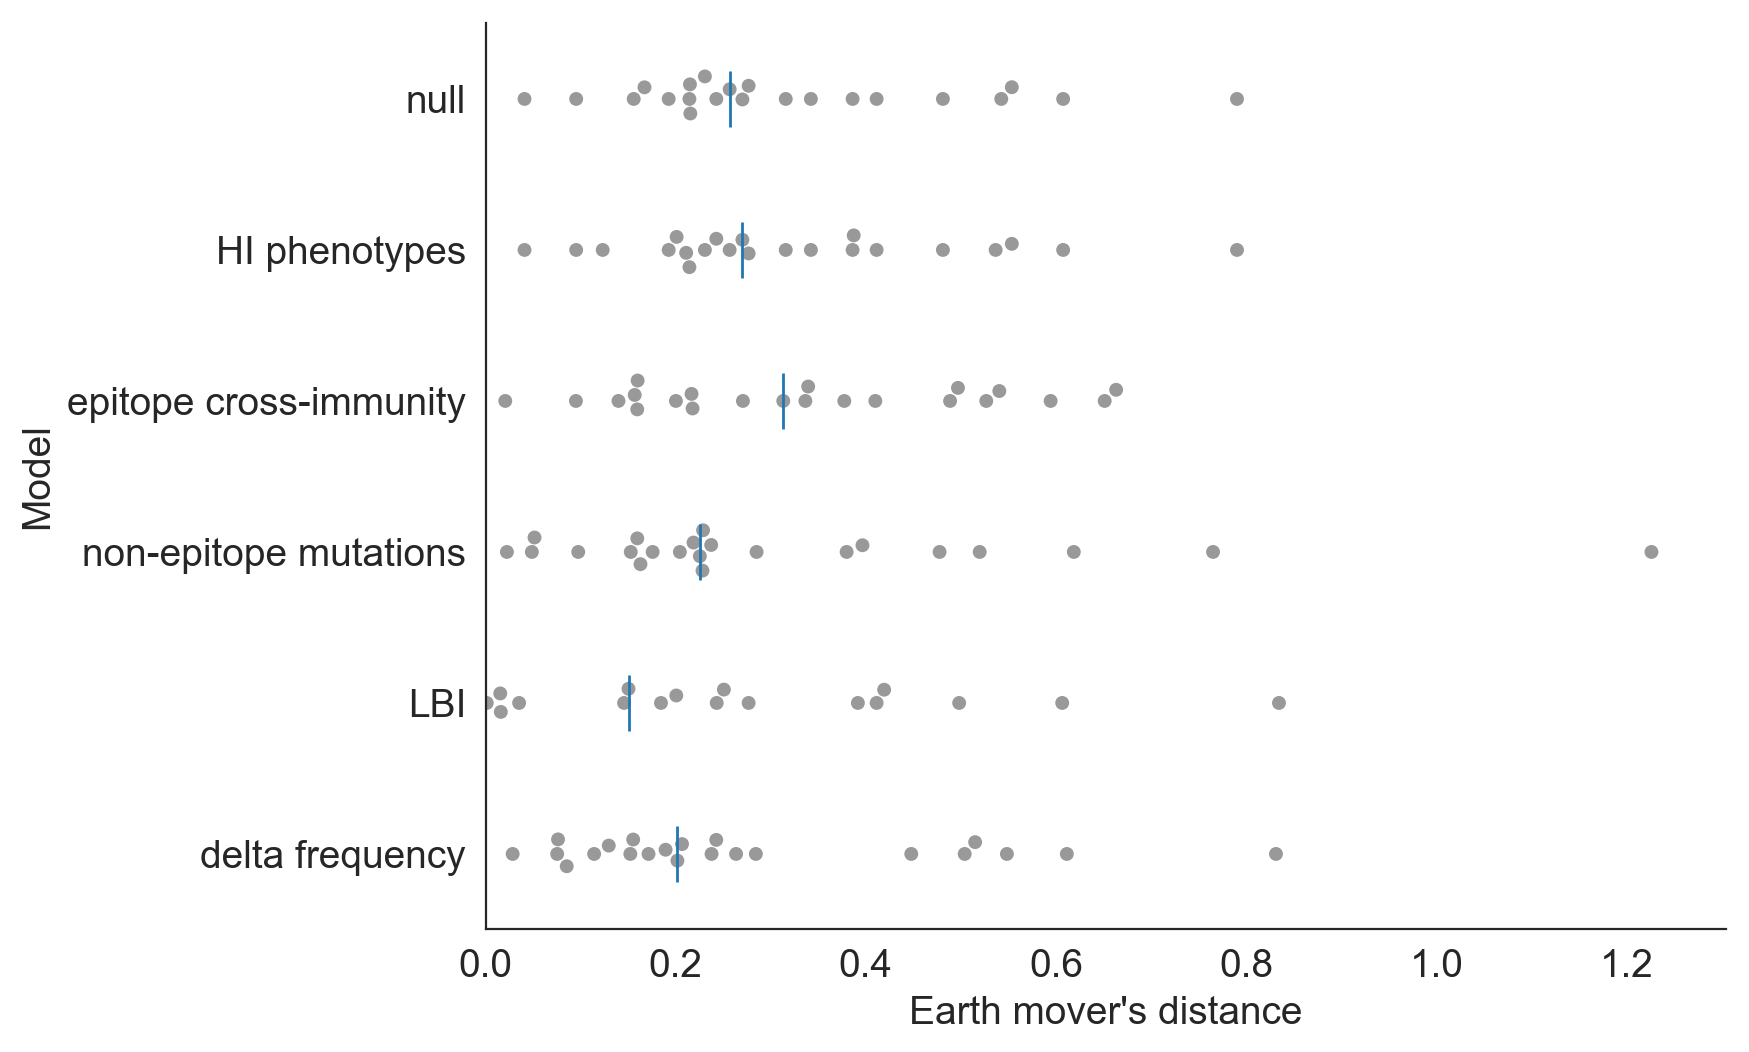

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(
    individual_median_errors,
    predictor_type_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax = sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=predictor_type_order,
    color="#999999",
    zorder=-10
)

ax.set_yticklabels(predictor_names)

ax.set_xlabel("Earth mover's distance")
ax.set_ylabel("Model")
ax.set_xlim(left=0)

Text(0,0.5,'Model')

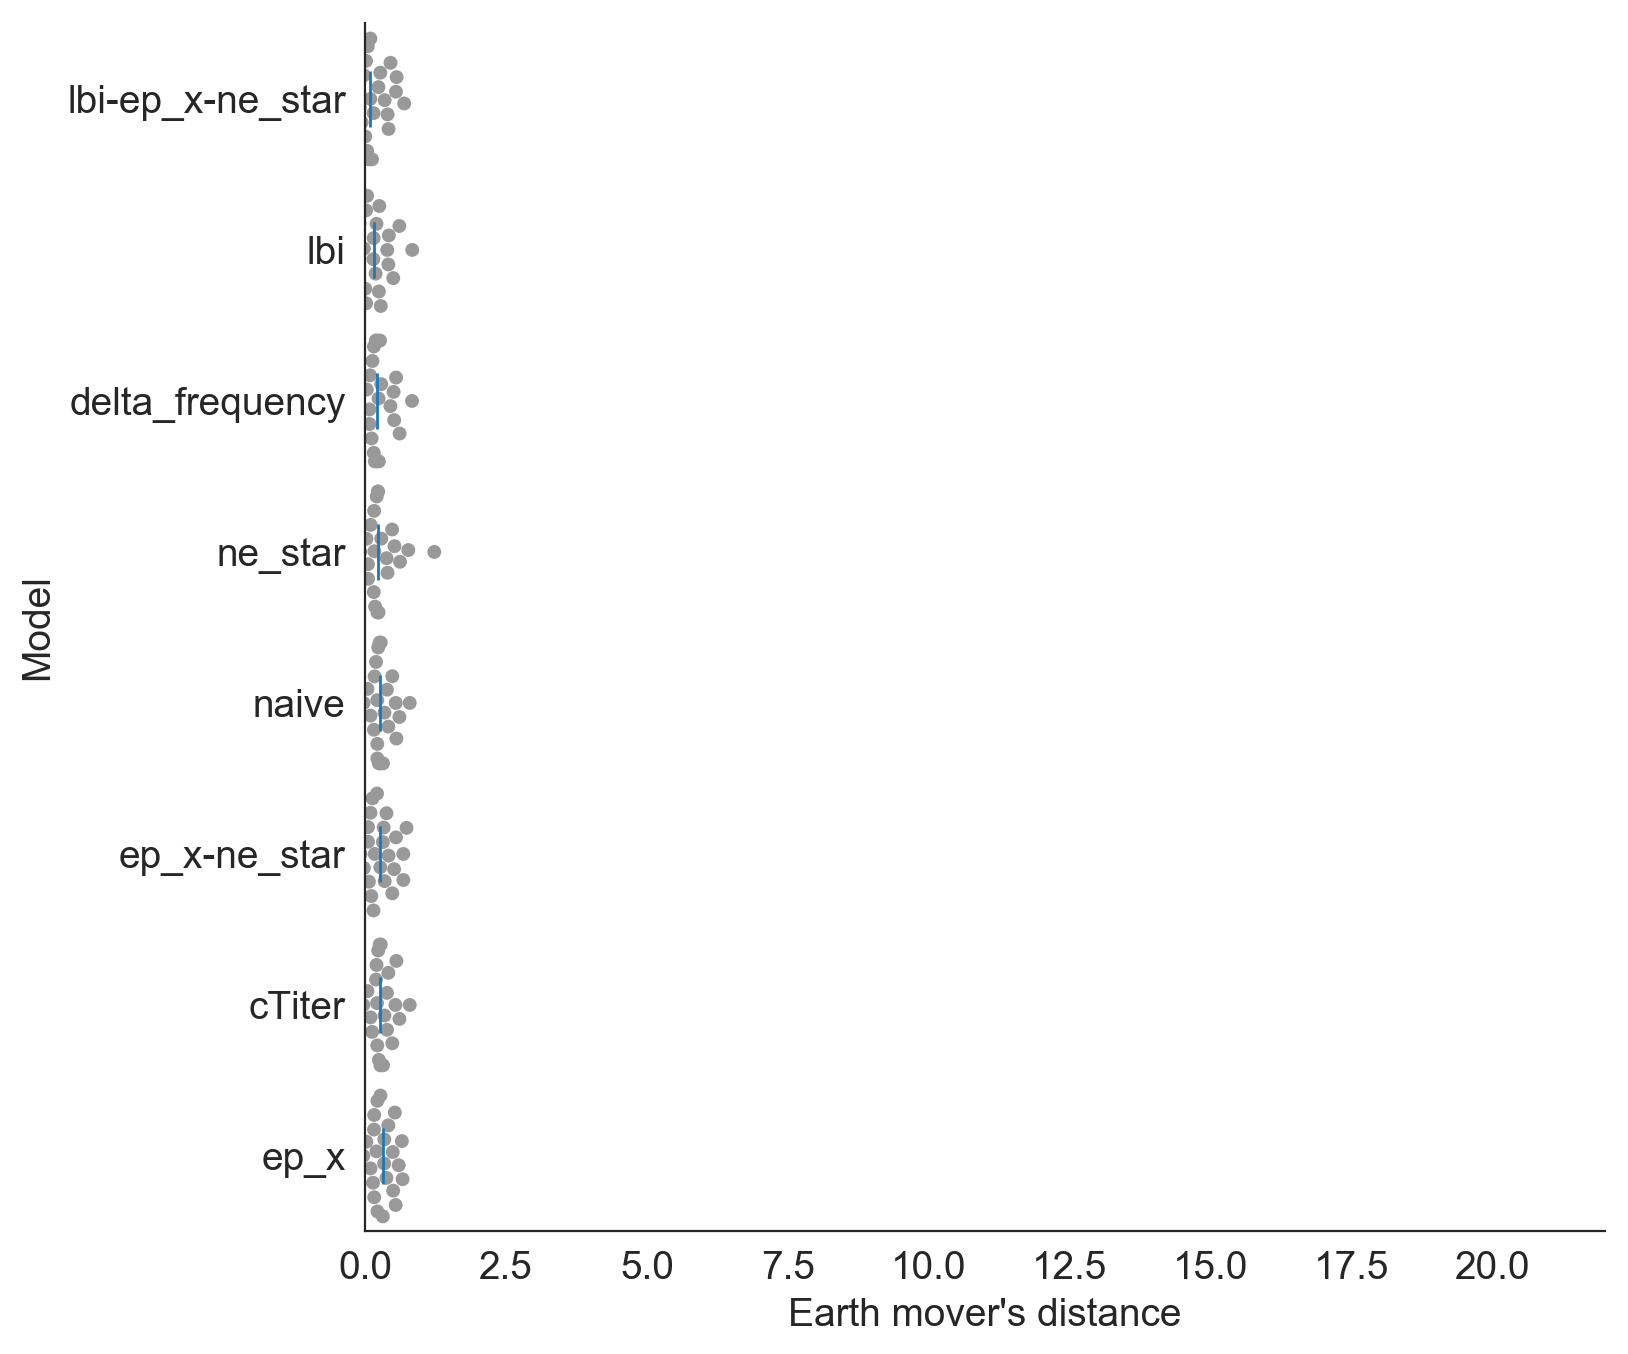

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_xlim(0, 22)

ax = sns.swarmplot(
    x="validation_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=median_error_order,
    color="#999999",
    zorder=-10
)

ax.plot(
    median_error["validation_error"],
    median_error_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax.set_xlabel("Earth mover's distance")
ax.set_ylabel("Model")

In [ ]:
errors_by_time_df.sort_values(by=["predictors", "validation_timepoint"], ascending=False).head()

In [ ]:
errors_by_time_df[errors_by_time_df["predictors"].str.contains("-")]["predictors"].unique()

In [ ]:
composite_predictors_order = [
    "lbi",
    "delta_frequency",
    "cTiterSub_x",
    "lbi-delta_frequency",
    "lbi-cTiterSub_x",
    "lbi-dms_star-cTiterSub_x",
    "lbi-ep_x-ne_star"
]

In [ ]:
composite_predictor_names = [
    "LBI",
    "delta frequency",
    "HI cross.",
    "LBI, delta frequency",
    "LBI, HI cross.",
    "LBI, DMS, HI cross.",
    "Luksza and Lassig"
]

In [ ]:
distance_df.head()

In [ ]:
"lbi" in distance_df["predictors"].values

In [ ]:
median_errors = []
for predictor in composite_predictors_order:
    if predictor in distance_df["predictors"].values:
        median_errors.append(distance_df.loc[distance_df["predictors"] == predictor, "median"].values[0])

In [ ]:
composite_predictors_order = [
    "lbi",
    "delta_frequency",
    "cTiterSub_x",
    "lbi-delta_frequency",
    "lbi-cTiterSub_x",
    "lbi-dms_star-cTiterSub_x",
    "lbi-ep_x-ne_star"
]

composite_predictor_names = [
    "LBI",
    "delta frequency",
    "HI phenotypes",
    "LBI, delta frequency",
    "LBI, HI phenotypes",
    "LBI, DMS, HI phenotypes",
    "Luksza and Lassig"
]

In [ ]:
median_errors

In [ ]:
"""
if len(median_errors) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    ax.set_xlim(0, 22)
    ax = sns.swarmplot(
        x="validation_error",
        y="predictors",
        data=errors_by_time_df,
        ax=ax,
        color="#999999",
        order=composite_predictors_order
    )

    ax.plot(
        median_errors,
        composite_predictors_order,
        marker="|",
        markersize=20,
        linestyle="",
        zorder=10
    )

    ax.set_yticklabels(composite_predictor_names)

    #labels = ax.get_yticklabels()
    #output = plt.setp(labels, rotation=30)

    ax.set_xlabel("Earth mover's distance")
    ax.set_ylabel("Model")
    ax.axvline(x=0.0, color="#cccccc", zorder=-20, alpha=0.25)

    plt.tight_layout()
"""

In [ ]:
errors_by_time_df.loc[pd.isnull(errors_by_time_df["predictors_name"]), "predictors_name"] = errors_by_time_df.loc[
    pd.isnull(errors_by_time_df["predictors_name"]), "predictors"
]

In [ ]:
g = facet_time_plot(
    errors_by_time_df,
    "validation_error",
    "Earth mover's distance",
    timepoint_column="validation_timepoint",
    col_wrap=2,
    markersize=7
)

In [ ]:
predictor_type_order

In [ ]:
antigenic_predictors = predictor_type_order[1:5]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(antigenic_predictors)],
    "validation_error",
    "Earth mover's distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in antigenic_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)

In [ ]:
predictor_type_order

In [ ]:
functional_predictors = predictor_type_order[5:7]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(functional_predictors)],
    "validation_error",
    "Earth mover's distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in functional_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)


In [ ]:
growth_predictors = predictor_type_order[7:]
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"].isin(growth_predictors)],
    "validation_error",
    "Earth mover's distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_wrap=2,
    height=6,
    aspect=1.,
    col_order=[predictor_name_by_id[predictor] for predictor in growth_predictors]
)
g.set_titles("{col_name}")
g.fig.subplots_adjust(hspace=0.2)

In [ ]:
errors_by_time_df["predictors"].unique()

In [ ]:
errors_by_time_df[errors_by_time_df["predictors"] == "naive"]

In [ ]:
g = facet_time_plot(
    errors_by_time_df[errors_by_time_df["predictors"] == "naive"],
    "validation_error",
    "Earth mover's distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    height=6,
    aspect=1
)
#g.set_titles("{col_name}")
#g.fig.subplots_adjust(hspace=0.2)

In [ ]:
errors_by_time_df.head()

### Adjusted earth mover's distance (relative to naive model)

In [114]:
naive_error = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].values
for predictor in errors_by_time_df["predictors"].drop_duplicates().values:
    #adjusted_error = ((errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "validation_error"] - naive_error) / naive_error) * 100
    adjusted_error = errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "validation_error"] - naive_error
    errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "adjusted_error"] = adjusted_error

In [115]:
naive_error

array([ 0.0409753 ,  0.60747803,  0.4113064 ,  0.27668473,  0.79033087,
        0.55348621,  0.48101833,  0.54239865,  0.2426971 ,  0.21440559,
        0.25672764,  0.23069387,  0.38603529,  0.27015981,  0.19259103,
        0.34217662,  0.31573698,  0.09530306,  0.15583199,  0.21539245,
        0.16714887,  0.21497478, -0.02743786])

In [116]:
median_adjusted_error = errors_by_time_df.groupby("predictors")["adjusted_error"].median().reset_index().sort_values(by="adjusted_error")
median_adjusted_error_order = median_adjusted_error["predictors"].values

In [117]:
errors_by_time_df["adjusted_error"].min()

-0.6336633023850007

In [118]:
errors_by_time_df["adjusted_error"].max()

0.6727583127504639

In [119]:
median_adjusted_error_order

array(['lbi-ep_x-ne_star', 'ep_x-ne_star', 'lbi', 'ne_star',
       'delta_frequency', 'cTiter', 'naive', 'ep_x'], dtype=object)

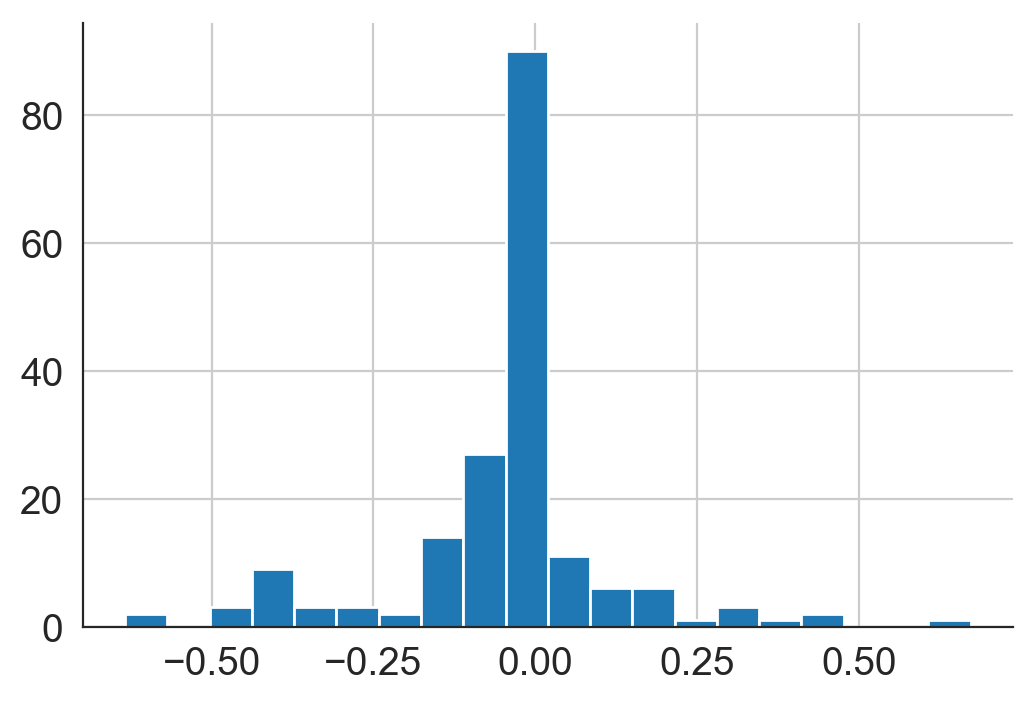

In [120]:
errors_by_time_df["adjusted_error"].hist(bins=20)

Text(0,0.5,'Model')

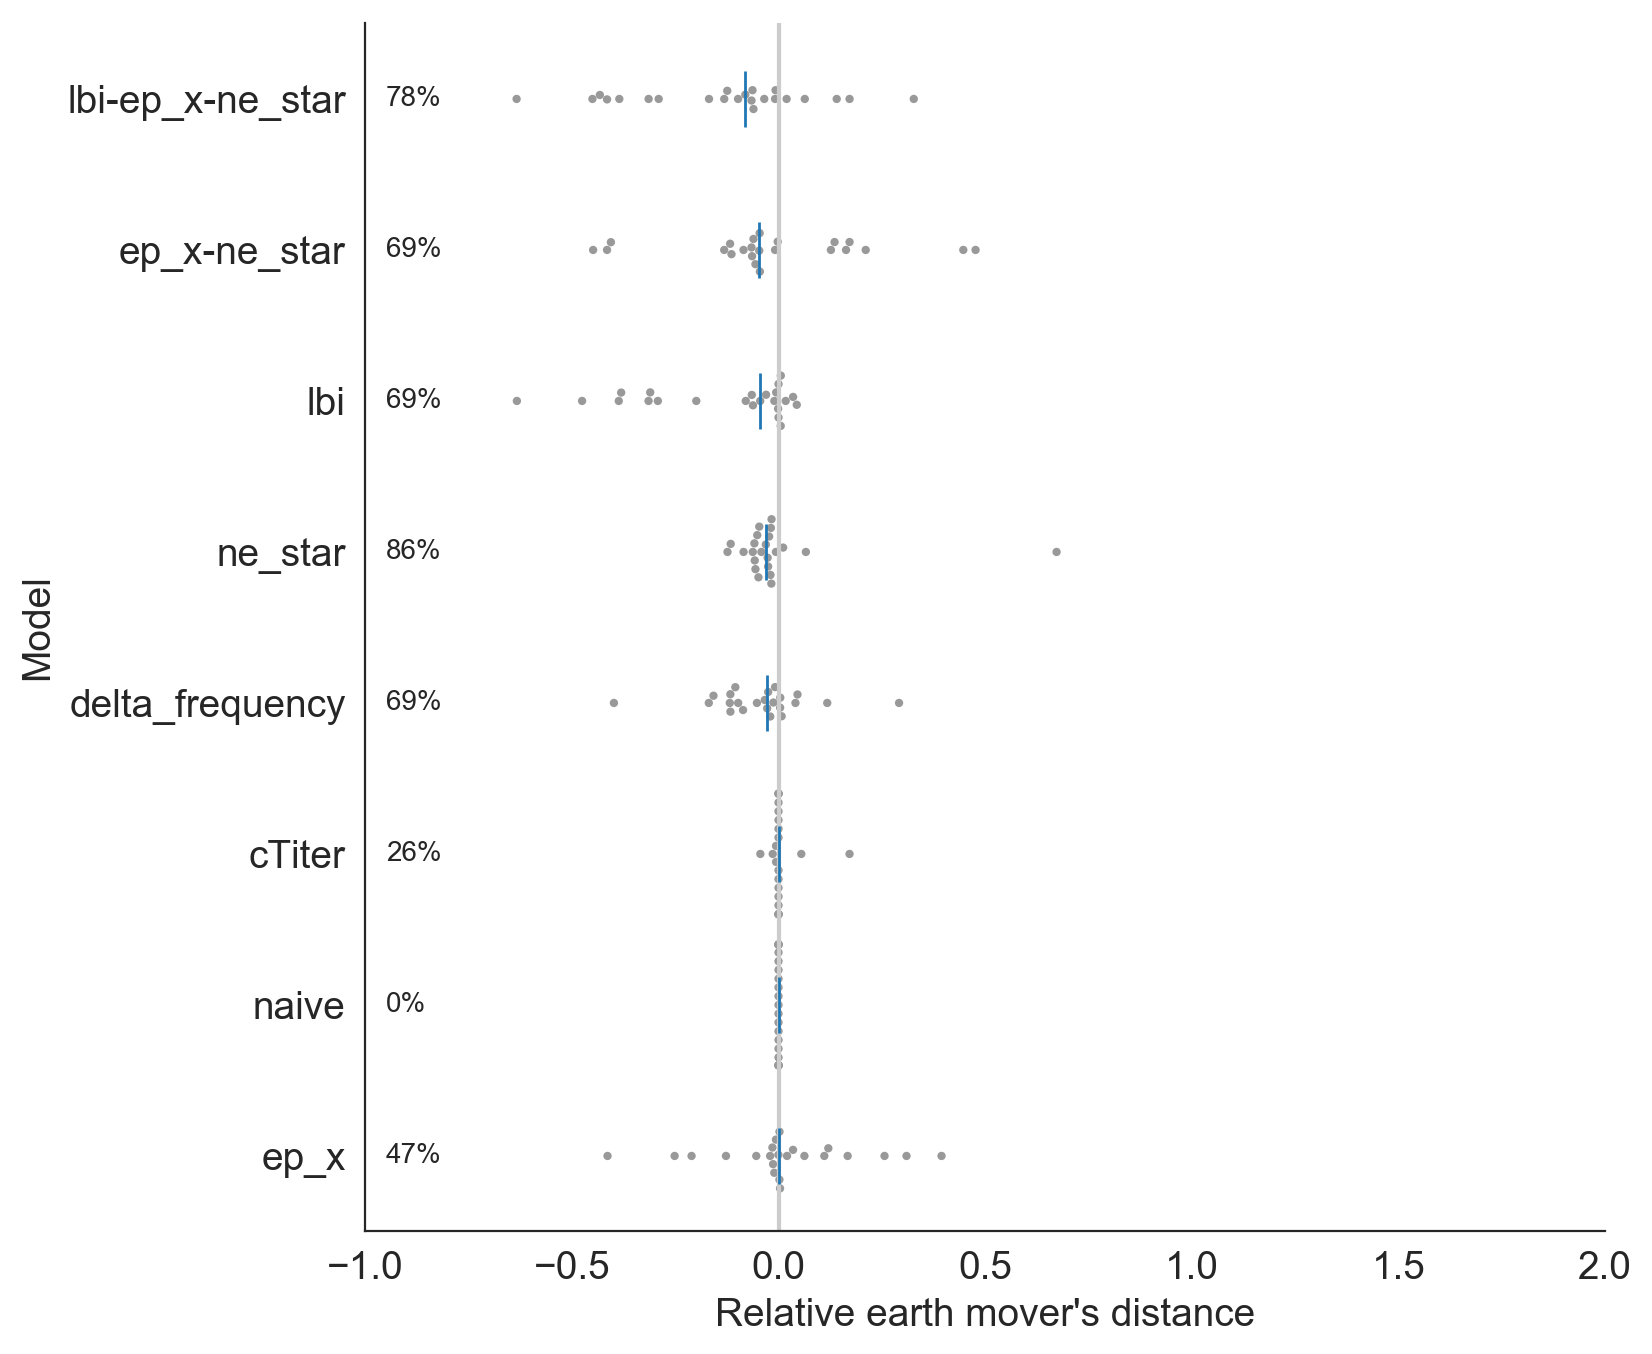

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_xlim(-1, 2)

ax = sns.swarmplot(
    x="adjusted_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=median_adjusted_error_order,
    color="#999999",
    zorder=-10,
    size=3
)

ax.plot(
    median_adjusted_error["adjusted_error"],
    median_adjusted_error_order,
    marker="|",
    markersize=20,
    linestyle=""
)


#ax.text(0.5, 0, "test")
for i, predictor in enumerate(median_adjusted_error_order):
    predictor_errors = errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "adjusted_error"]
    
    ax.text(
        -0.95,
        i,
        "%i%%" % (((predictor_errors < 0).sum() / float(predictor_errors.shape[0])) * 100),
        horizontalalignment='left',
        verticalalignment='center',
        fontsize=10
    )

ax.axvline(x=0, color="#cccccc", zorder=-10)

ax.set_xlabel("Relative earth mover's distance")
ax.set_ylabel("Model")

In [122]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint  \
0        lbi          0.035306           141           2000-10-01   
1        lbi          0.606493            89           2001-04-01   
2        lbi          0.411306            60           2001-10-01   
3        lbi          0.276685           142           2002-04-01   
4        lbi          0.834474           200           2002-10-01   

  predictors_name  adjusted_error  
0             LBI   -5.669500e-03  
1             LBI   -9.847841e-04  
2             LBI    0.000000e+00  
3             LBI    1.110223e-16  
4             LBI    4.414324e-02

In [123]:
coefficients_by_time_df.head()

coefficient predictor predictors validation_timepoint
0  4.730719e-01       lbi        lbi           2000-10-01
1  5.427943e-02       lbi        lbi           2001-04-01
2 -6.938894e-18       lbi        lbi           2001-10-01
3 -5.273559e-16       lbi        lbi           2002-04-01
4  1.155711e+00       lbi        lbi           2002-10-01

In [124]:
errors_and_coefficients_by_time = coefficients_by_time_df.merge(
    errors_by_time_df,
    on=["predictors", "validation_timepoint"]
)

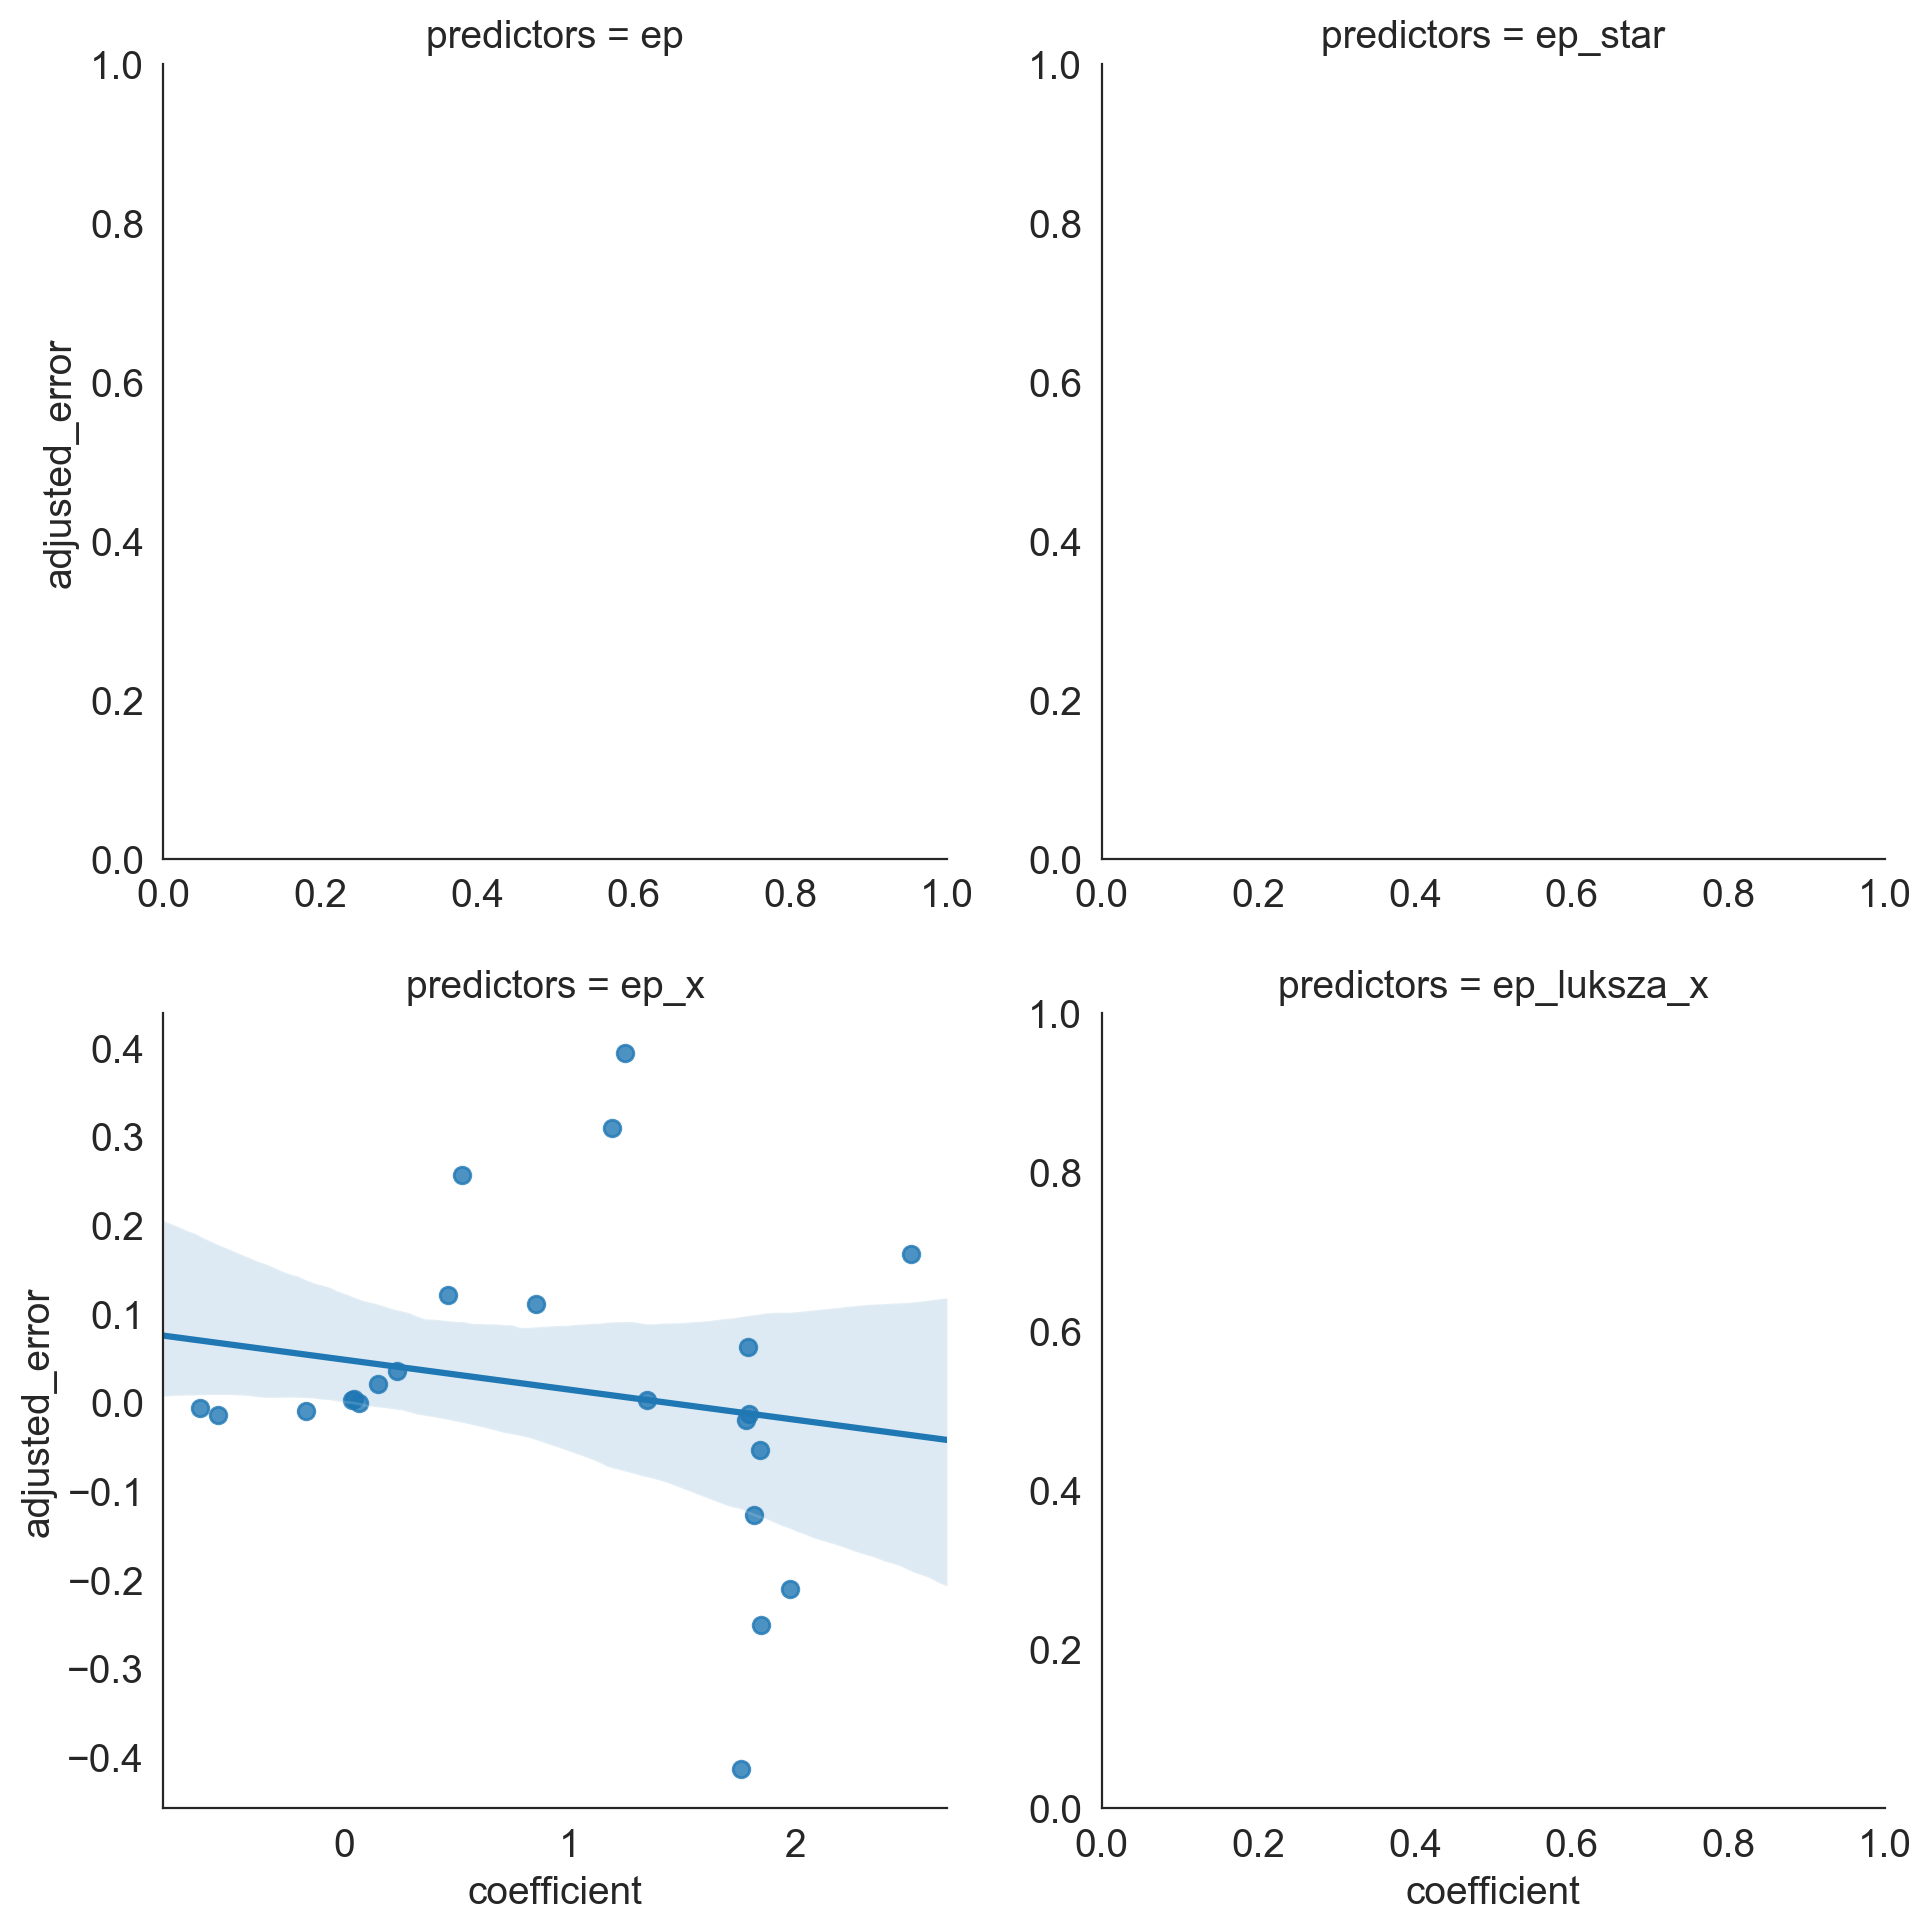

In [125]:
sns.lmplot(
    "coefficient",
    "adjusted_error",
    errors_and_coefficients_by_time,
    col="predictors",
    col_wrap=2,
    sharex=False,
    sharey=False,
    col_order=["ep", "ep_star", "ep_x", "ep_luksza_x"]
)

In [126]:
predictor_errors.shape[0]

23

Text(0,0.5,'Model')

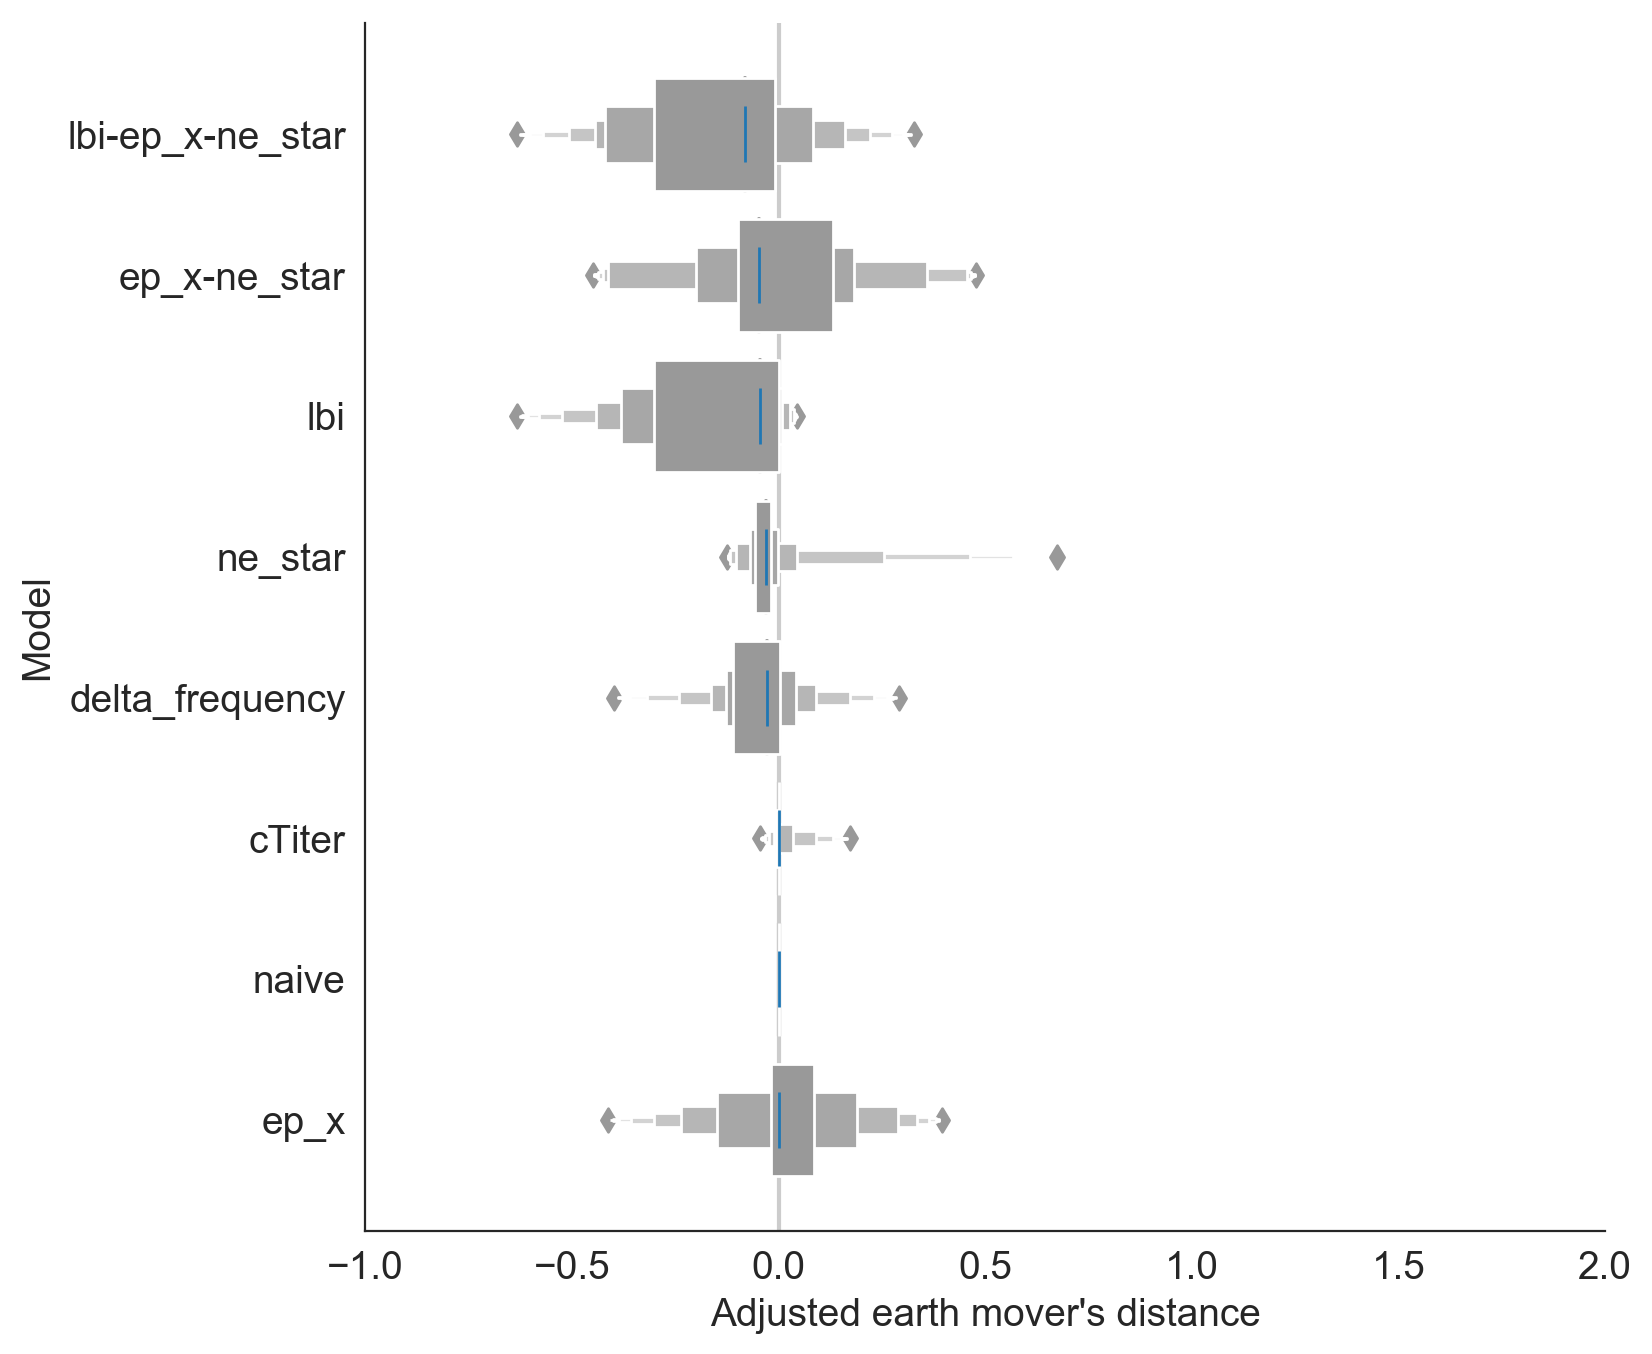

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_xlim(-1, 2)

"""
ax = sns.swarmplot(
    x="adjusted_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=median_adjusted_error_order,
    color="#999999",
    zorder=-10
)
"""

ax = sns.boxenplot(
    x="adjusted_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=median_adjusted_error_order,
    color="#999999",
    zorder=-10
)

ax.plot(
    median_adjusted_error["adjusted_error"],
    median_adjusted_error_order,
    marker="|",
    markersize=20,
    linestyle=""
)

ax.axvline(x=0, color="#cccccc", zorder=-10)

ax.set_xlabel("Adjusted earth mover's distance")
ax.set_ylabel("Model")

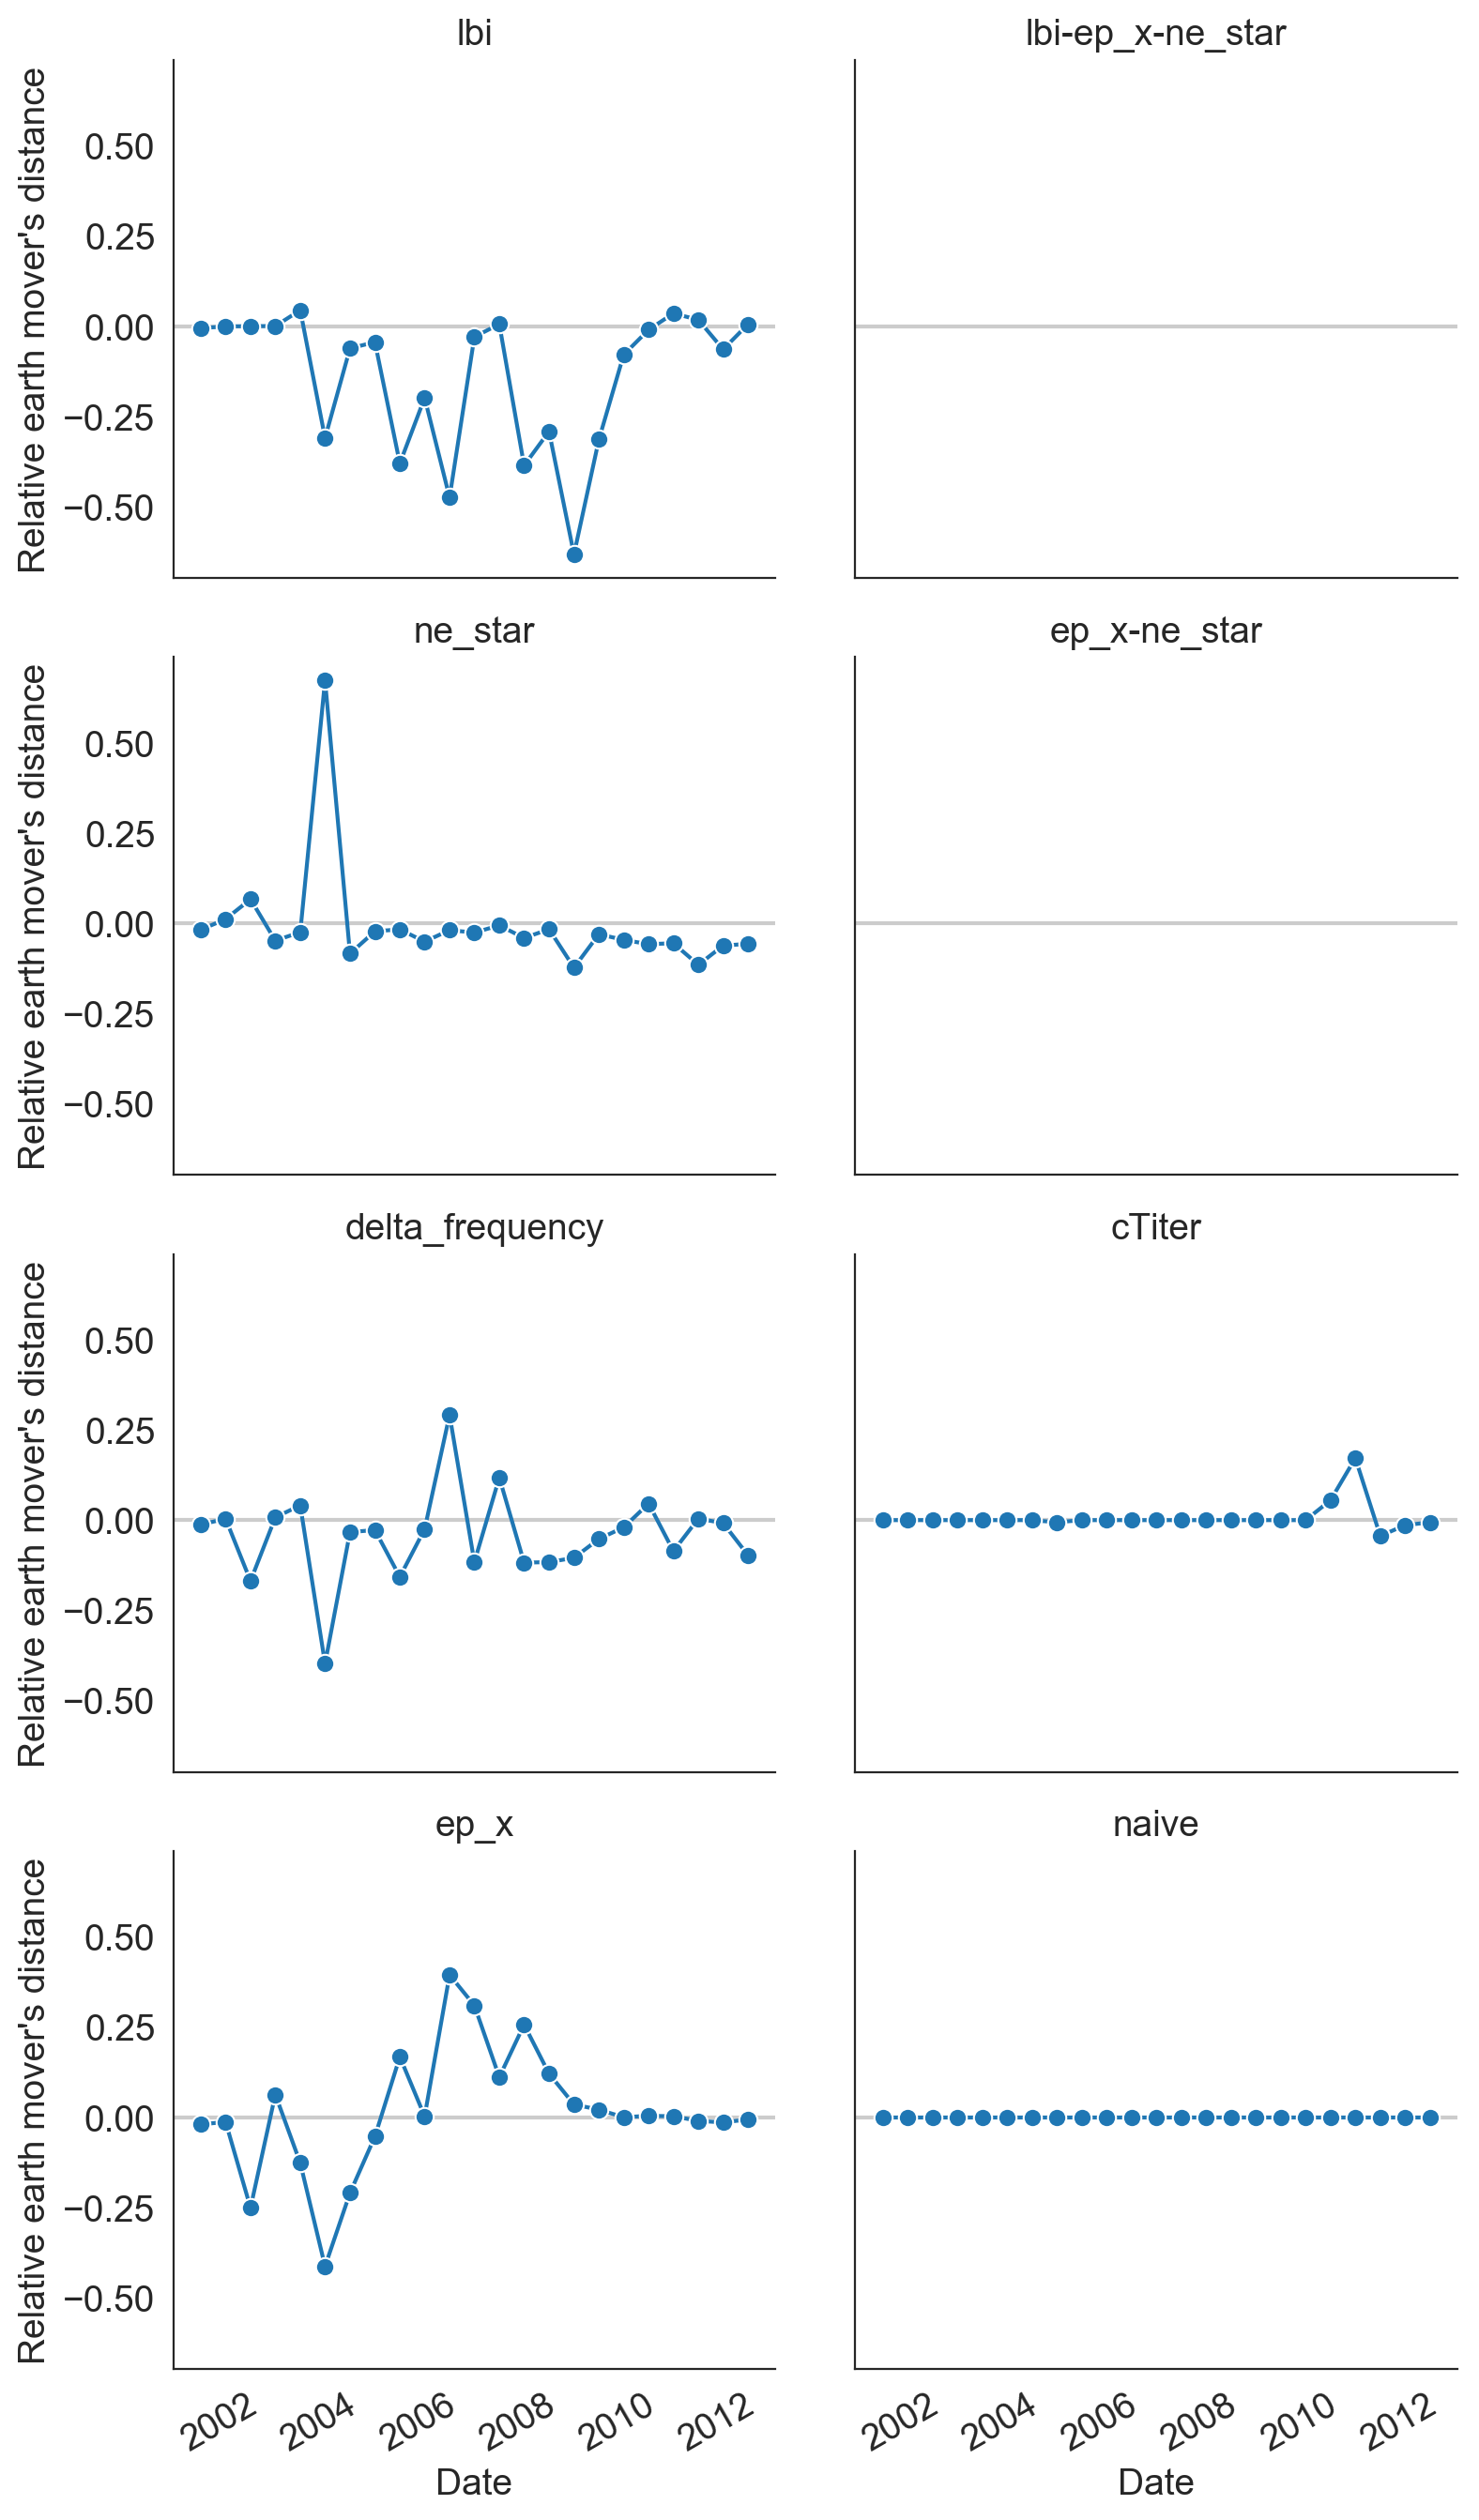

In [128]:
g = facet_time_plot(errors_by_time_df, "adjusted_error", "Relative earth mover's distance", timepoint_column="validation_timepoint",
                    col_wrap=2, markersize=7)
g.set_titles("{col_name}")

#for ax in g.axes.flatten():
#    ax.set_ylim(-5, 5)

In [ ]:
individual_predictor_names_order

In [ ]:
errors_by_time_df.head()

In [ ]:
errors_by_time_df["validation_timepoint_float"] = mdates.date2num(pd.to_datetime(errors_by_time_df["validation_timepoint"]))

In [ ]:
def facet_time_plot_with_labels(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors", hue=None,
                    height=4, aspect=1, col_order=None, col_wrap=4, markersize=15, grid_kwargs=None):
    if grid_kwargs is None:
        grid_kwargs = {}
        
    g = sns.FacetGrid(data, col=predictors_column, col_order=col_order, col_wrap=col_wrap, hue=hue,
                      height=height, aspect=aspect, **grid_kwargs)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column, markersize=markersize)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc", zorder=-10)

        ax.xaxis.set_major_locator(mdates.YearLocator())
        #ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

        #ax.fmt_xdata = mdates.DateFormatter('%Y')
        
        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate(rotation=45)
    return g

In [ ]:
mpl.__version__

In [ ]:
best_models = [
    "ep_x",
    "ne_star",
    "lbi",
    "lbi-ep_x-ne_star",
    "cTiterSub_x",
    "dms_star",
    "delta_frequency",
    "lbi-cTiterSub_x-dms_star"
]

best_predictor_names = [
    "epitope mutations",
    "non-epitope mutations",
    "LBI",
    "LBI and mutations",
    "HI phenotypes",
    "DMS phenotypes",
    "delta frequency",
    "LBI, HI, and DMS"
]

In [ ]:
final_models_by_time_df = errors_by_time_df[errors_by_time_df["predictors"].isin(best_models)].copy()

In [ ]:
final_models_by_time_df["predictors_name"] = final_models_by_time_df["predictors"].map(dict(zip(best_models, best_predictor_names)))

In [ ]:
g = facet_time_plot_with_labels(
    final_models_by_time_df,
    "adjusted_error",
    "Relative earth mover's distance",
    predictors_column="predictors_name",
    timepoint_column="validation_timepoint_float",
    col_wrap=4,
    markersize=7,
    col_order=best_predictor_names
)
g.set_titles("{col_name}")

for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    #ax.set_ylim(-5, 5)
    
    proportion_better_than_naive = int(round(sum(facet_df["adjusted_error"] < 0) / float(facet_df.shape[0]) * 100))
    ax.text(
        0.9,
        0.85,
        "Median = %.2f\nBetter than naive %i%% of timepoints" % (facet_df["adjusted_error"].median(), proportion_better_than_naive),
        transform=ax.transAxes,
        fontsize=10,
        horizontalalignment='right'
    )

## Summarize model coefficients

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.set_xlim(-20, 20)
sns.boxenplot(
    y="predictors",
    x="coefficient",
    hue="predictor",
    data=coefficients_by_time_df,
    width=2.0,
    ax=ax,
    order=predictor_names_order
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()

In [ ]:
overall_coefficients_df

In [ ]:
coefficients_by_time_df.head()

In [ ]:
final_coefficients_by_time = coefficients_by_time_df[coefficients_by_time_df["predictors"].isin(best_models)].copy()

In [ ]:
final_coefficients_by_time["predictors_name"] = final_coefficients_by_time["predictors"].map(dict(zip(best_models, best_predictor_names)))

In [ ]:
final_coefficients_by_time["validation_timepoint_float"] = mdates.date2num(pd.to_datetime(final_coefficients_by_time["validation_timepoint"]))

In [ ]:
final_coefficients_by_time.head()

In [ ]:
coefficients_by_time_df["predictors_name"] = coefficients_by_time_df["predictors"].map(predictor_name_by_id)

In [ ]:
coefficients_by_time_df.loc[pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors_name"] = coefficients_by_time_df.loc[
    pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors"
]

In [ ]:
coefficients_by_time_df["predictors_name"].unique().shape

In [ ]:
g = facet_time_plot_with_labels(
    final_coefficients_by_time,
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint_float",
    predictors_column="predictors_name",
    hue="predictor",
    col_order=best_predictor_names,
    col_wrap=4,
    markersize=7
)
g.set_titles("{col_name}")
g.add_legend()

for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    ax.set_ylim(-5, 5)

In [ ]:
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"] != "naive"],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    hue="predictor",
    markersize=7
)
g.set_titles("{col_name}")

for ax in g.axes.flatten():
    ax.set_ylim(-11, 11)

In [ ]:
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"] != "naive"],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_order=[predictor_name_by_id[predictor] for predictor in predictor_type_order[1:]],
    hue="predictor",
    markersize=7
)
g.set_titles("{col_name}")

for ax in g.axes.flatten():
    ax.set_ylim(-11, 11)

In [ ]:
composite_predictors_order

In [ ]:
lbi_dfreq_order = ["lbi", "delta_frequency", "lbi-delta_frequency"]
lbi_dfreq_names = ["LBI", "delta frequency", "LBI, delta frequency"]
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"].isin(lbi_dfreq_order)],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    hue="predictor",
    col_order=lbi_dfreq_order,
    markersize=7
)

#g.set_titles("{col_name}")

for ci, ax in enumerate(g.axes.flatten()):
    ax.set_title(lbi_dfreq_names[ci], fontsize=12)
    #ax.set_ylim(-2., 2.)

In [ ]:
lbi_dfreq_order = ["lbi", "cTiterSub_x", "lbi-cTiterSub_x"]
lbi_dfreq_names = ["LBI", "HI cross-immunity", "LBI, HI cross-immunity"]
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"].isin(lbi_dfreq_order)],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    hue="predictor",
    col_order=lbi_dfreq_order,
    markersize=7
)

#g.set_titles("{col_name}")

for ci, ax in enumerate(g.axes.flatten()):
    ax.set_title(lbi_dfreq_names[ci], fontsize=12)
    #ax.set_ylim(-2., 2.)

## Figure 3: Summary of models for natural populations

In [129]:
colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']

In [130]:
colors.reverse()

In [131]:
colors

['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']

In [132]:
dict(zip(individual_predictor_names_order, colors))

{'ep_x': '#4575b4',
 'cTiter': '#91bfdb',
 'ne_star': '#e0f3f8',
 'delta_frequency': '#fee090',
 'lbi': '#fc8d59'}

In [133]:
nrows = len(individual_predictor_names_order)
ncols = 2
color_by_predictor = {
    'ep': '#4575b4',
    'ep_star': '#4575b4',
    'ep_x': '#4575b4',
    'cTiter': '#91bfdb',
    'cTiterSub': '#91bfdb',
    'cTiterSub_star': '#91bfdb',
    'cTiterSub_x': '#91bfdb',
    'ne_star': '#999999',
    'dms_star': '#fee090',
    'lbi': '#fc8d59',
    'delta_frequency': '#d73027'
}

name_by_predictor = {
    "ep": "epitope mutations",
    "ep_star": "epitope ancestor",
    "ep_x": "cross-immunity",
    "cTiter": "linear HI tree phenotypes",
    "cTiterSub": "linear HI mutation phenotypes",
    "cTiterSub_star": "ancestral HI mutation phenotypes",
    "cTiterSub_x": "HI phenotypes",
    "ne_star": "non-epitope mutations",
    "dms_star": "DMS phenotypes",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

In [134]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint  \
0        lbi          0.035306           141           2000-10-01   
1        lbi          0.606493            89           2001-04-01   
2        lbi          0.411306            60           2001-10-01   
3        lbi          0.276685           142           2002-04-01   
4        lbi          0.834474           200           2002-10-01   

  predictors_name  adjusted_error  
0             LBI   -5.669500e-03  
1             LBI   -9.847841e-04  
2             LBI    0.000000e+00  
3             LBI    1.110223e-16  
4             LBI    4.414324e-02

In [135]:
min_error = errors_by_time_df["adjusted_error"].min()
max_error = errors_by_time_df["adjusted_error"].max()

min_normal_error = errors_by_time_df["validation_error"].min()
max_normal_error = errors_by_time_df["validation_error"].max()

min_coefficient = coefficients_by_time_df["coefficient"].min()
max_coefficient = coefficients_by_time_df["coefficient"].max()

min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)

In [136]:
individual_predictor_names_order

['ep_x', 'cTiter', 'ne_star', 'delta_frequency', 'lbi']

In [137]:
individual_predictor_names_order = [
    'ep_x',
    "cTiter",
    'ne_star',
    'delta_frequency',
    'lbi'
]

In [138]:
nrows = len(individual_predictor_names_order)

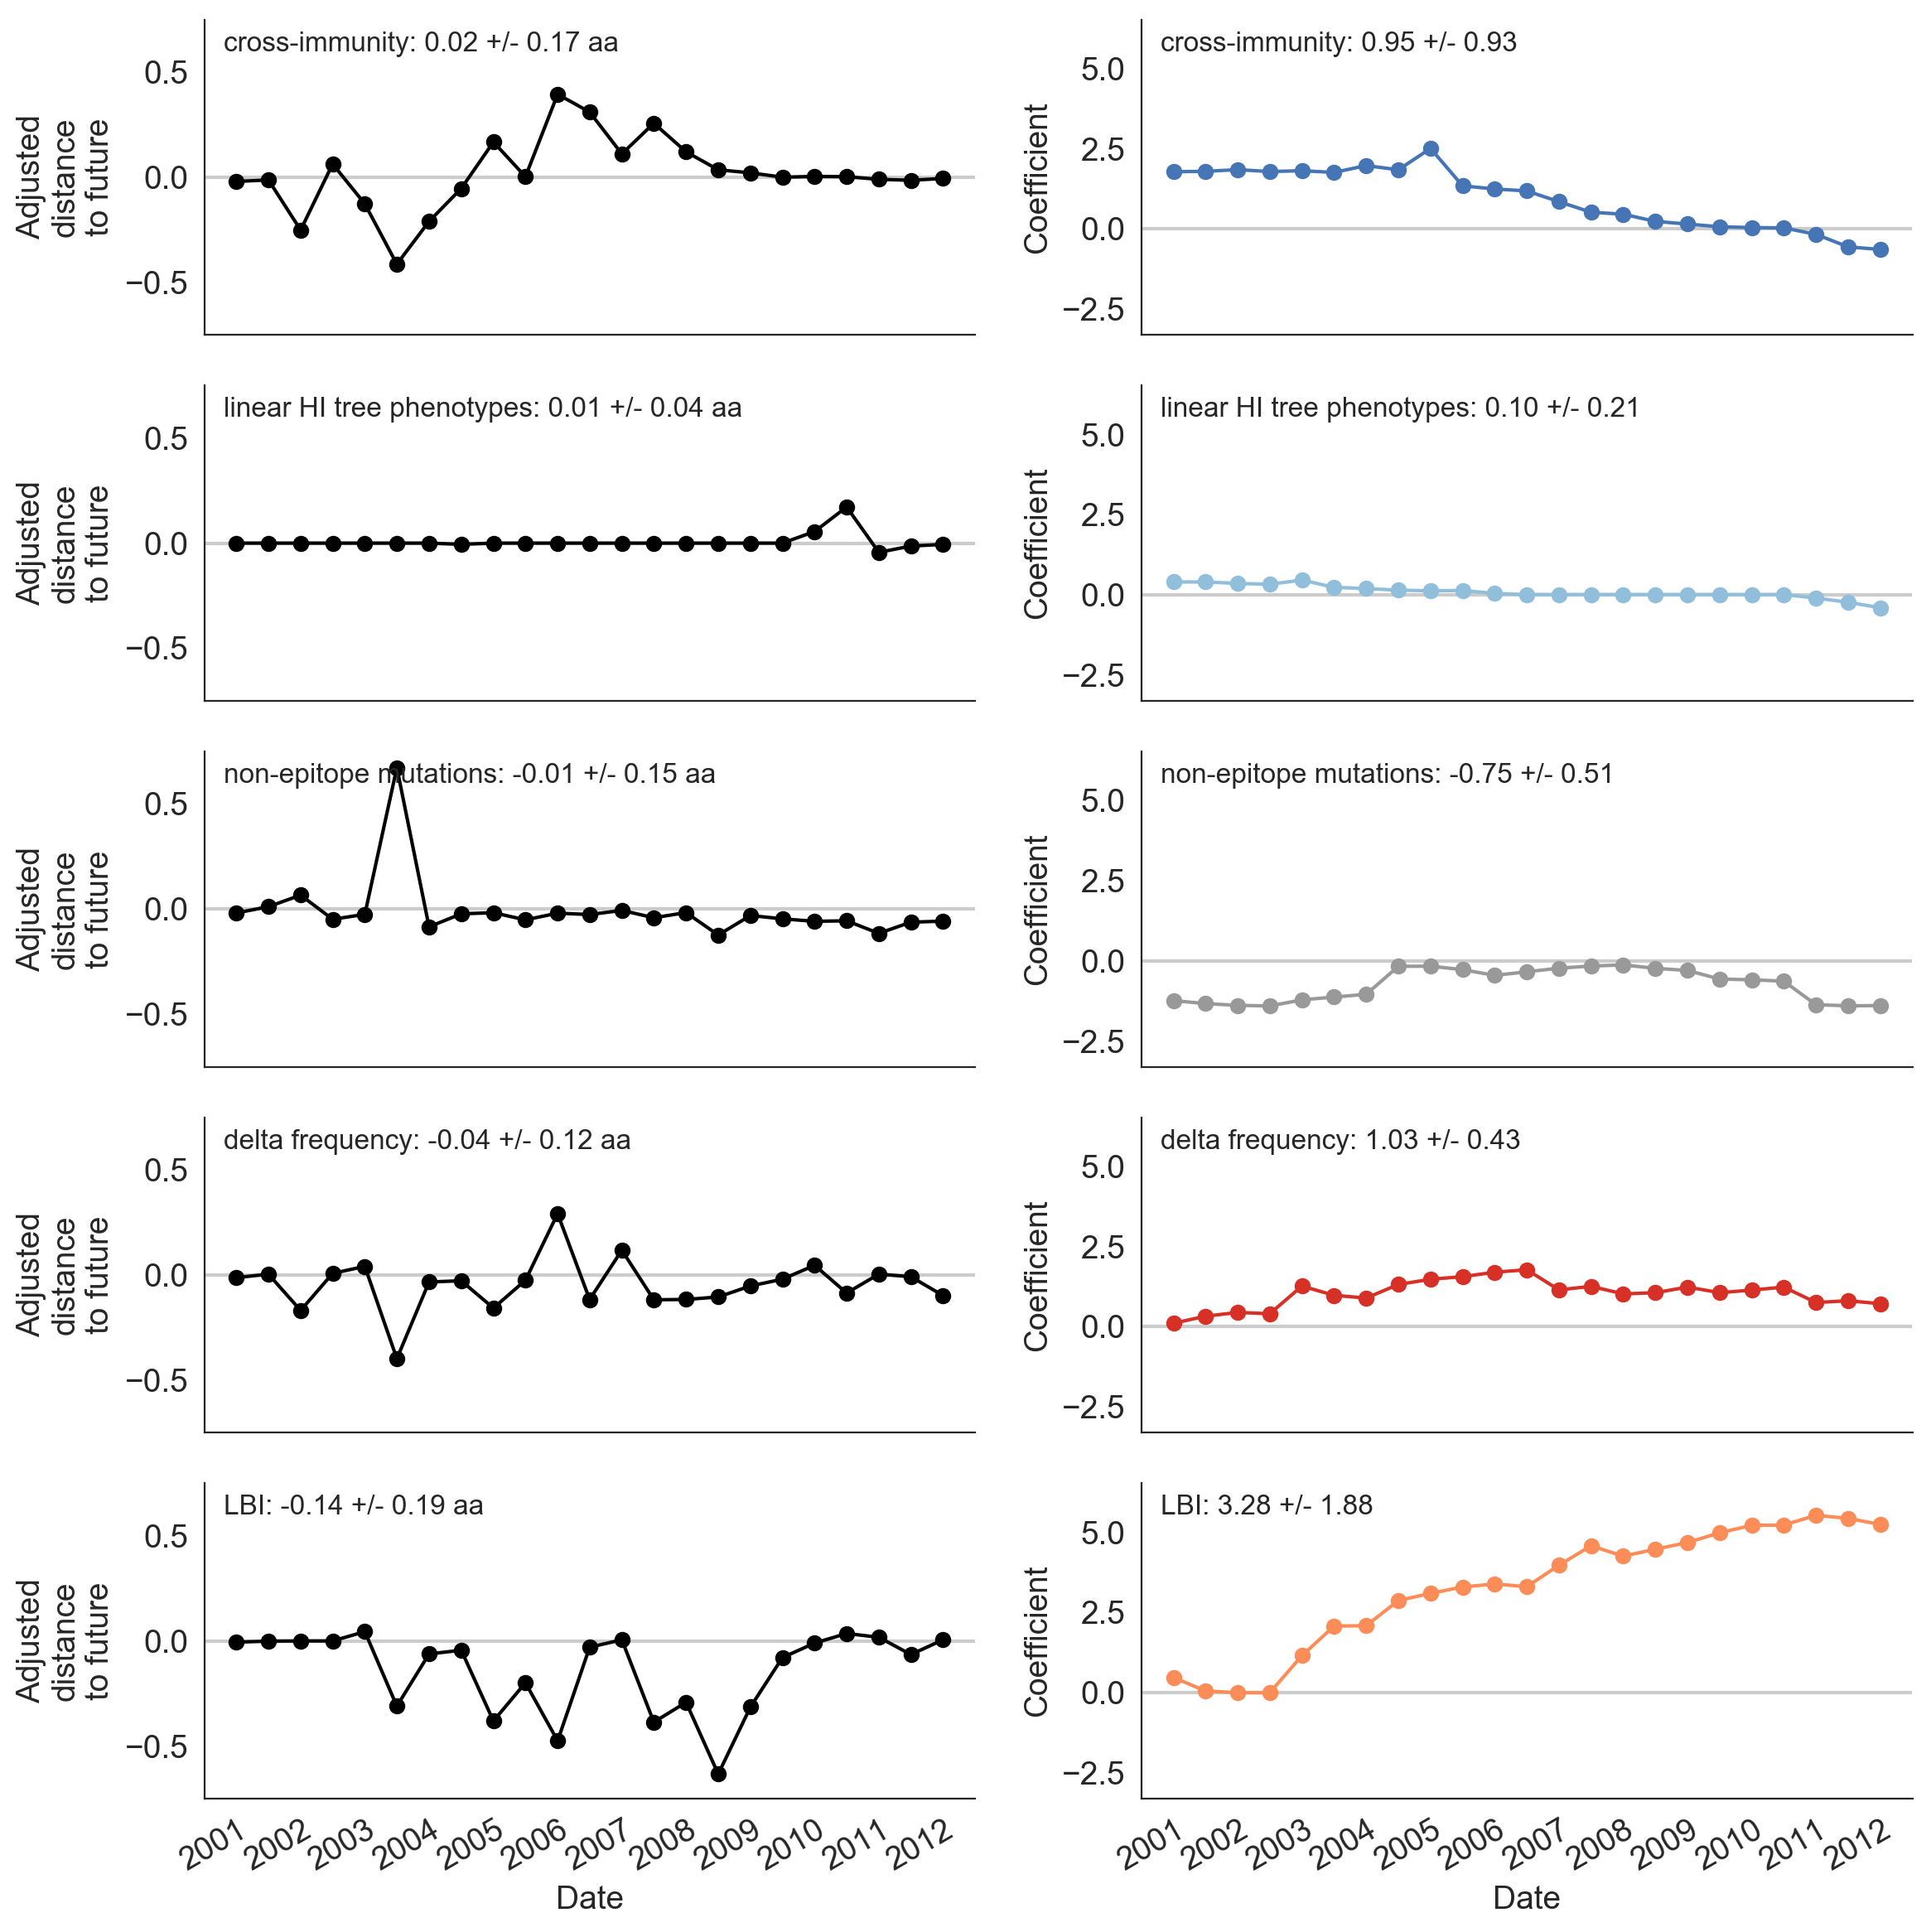

In [140]:
fig, axes = plt.subplots(figsize=(12, 12), facecolor='w')
gs = gridspec.GridSpec(
    nrows=nrows,
    ncols=ncols,
    hspace=0.05,
    wspace=0.2
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

for i, predictor in enumerate(individual_predictor_names_order):
    error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
    coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()

    distance_ax = plt.subplot(gs[i, 0])    
    distance_ax.set_xlabel("Date")
    distance_ax.set_ylabel("Adjusted\ndistance\nto future")
    distance_ax.set_ylim(-0.75, 0.75)
    distance_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f aa" % (name_by_predictor[predictor], error_df["adjusted_error"].mean(), error_df["adjusted_error"].std()),
        fontdict={"fontsize": 12},
        transform=distance_ax.transAxes
    )
    
    distance_ax.axhline(
        y=0.0,
        color="#cccccc"
    )
    
    distance_ax.plot(
        pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
        error_df["adjusted_error"],
        "o-",
        color="#000000"
    )
    
    distance_ax.set_xlim(min_date, max_date)
    distance_ax.xaxis.set_major_locator(years)
    distance_ax.xaxis.set_major_formatter(years_fmt)
    distance_ax.xaxis.set_minor_locator(months)
    distance_ax.format_xdata = mdates.DateFormatter('%Y-%m')
        
    coefficient_ax = plt.subplot(gs[i, 1])
    coefficient_ax.set_xlabel("Date")
    coefficient_ax.set_ylabel("Coefficient")
    coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 1)

    coefficient_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f" % (name_by_predictor[predictor], coefficient_df["coefficient"].mean(), coefficient_df["coefficient"].std()),
        fontdict={"fontsize": 12},
        transform=coefficient_ax.transAxes
    )
    
    coefficient_ax.axhline(
        y=0.0,
        color="#cccccc"
    )

    coefficient_ax.plot(
        coefficient_df["validation_timepoint"],
        coefficient_df["coefficient"],
        "o-",
        color=color_by_predictor[predictor]
    )
    
    coefficient_ax.set_xlim(min_date, max_date)
    coefficient_ax.xaxis.set_major_locator(years)
    coefficient_ax.xaxis.set_major_formatter(years_fmt)
    coefficient_ax.xaxis.set_minor_locator(months)
    coefficient_ax.format_xdata = mdates.DateFormatter('%Y-%m')
    
fig.autofmt_xdate()

gs.tight_layout(fig)
plt.savefig("../manuscript/figures/model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

# show x-axis tick lines

In [141]:
nrows

5

In [142]:
individual_predictor_names_order

['ep_x', 'cTiter', 'ne_star', 'delta_frequency', 'lbi']

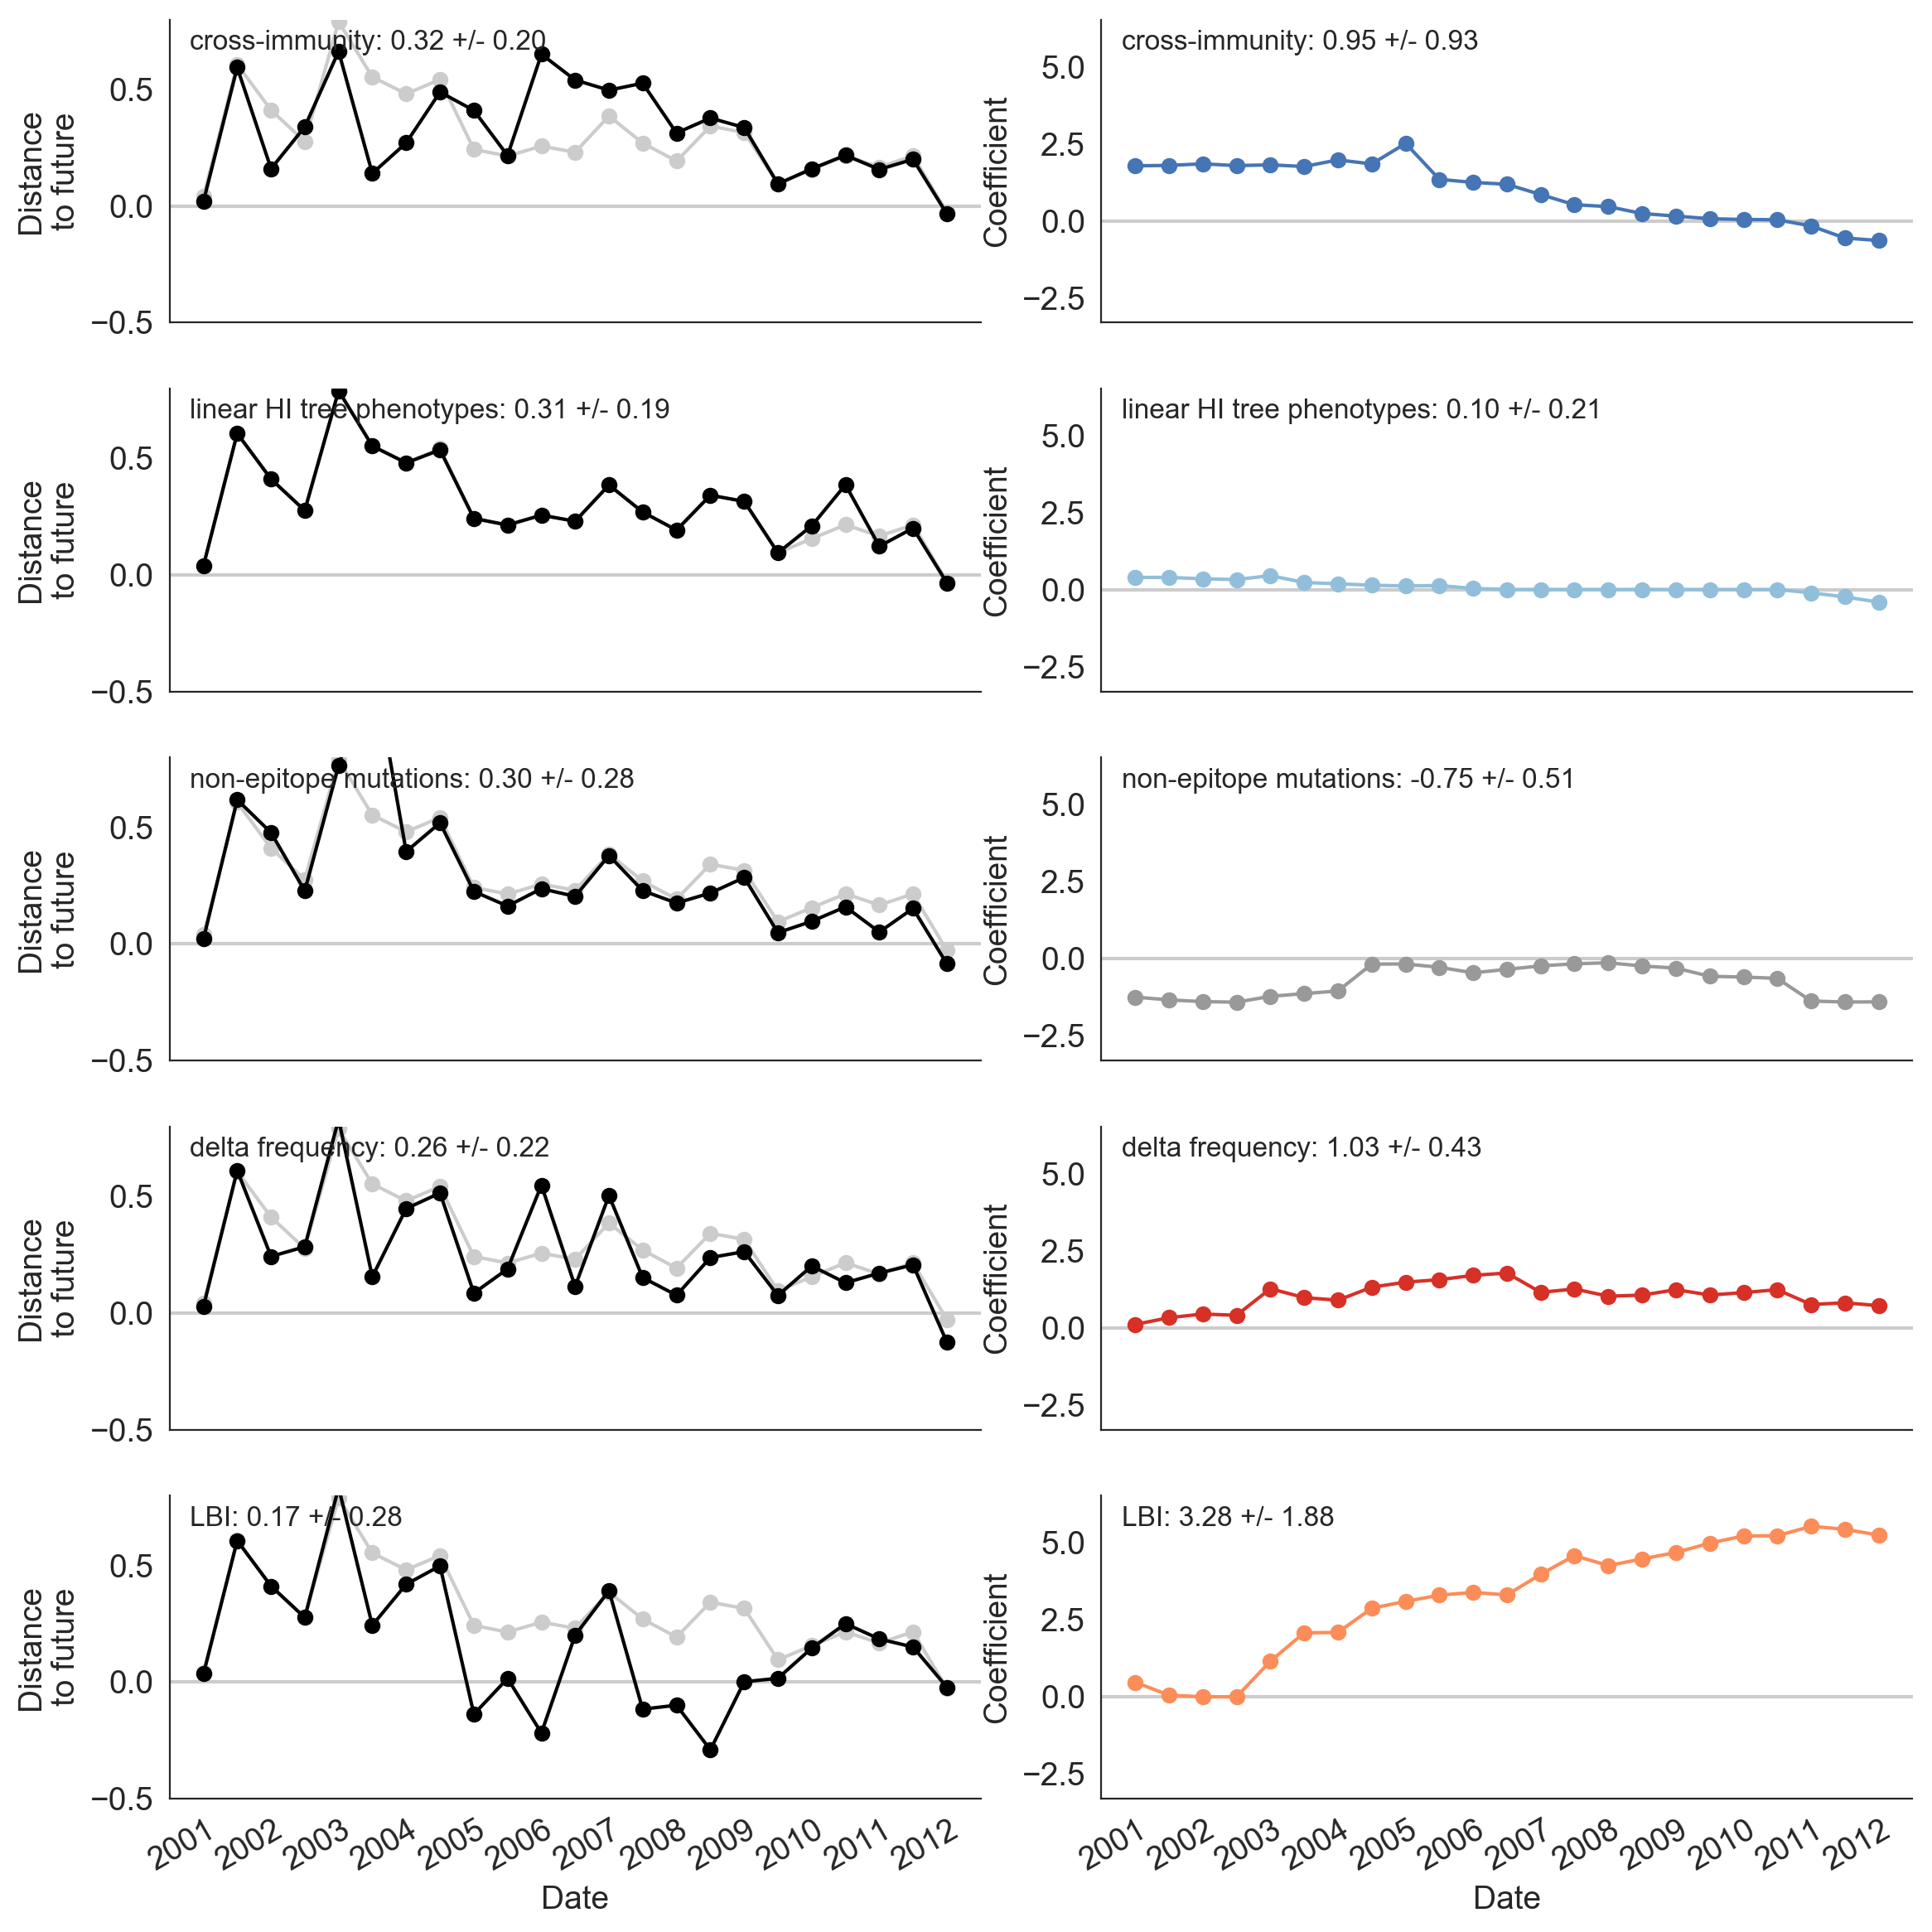

In [144]:
fig, axes = plt.subplots(figsize=(12, 12), facecolor='w')
gs = gridspec.GridSpec(
    nrows=nrows,
    ncols=ncols,
    hspace=0.1,
    wspace=0.2
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

for i, predictor in enumerate(individual_predictor_names_order):
    error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
    coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()

    distance_ax = plt.subplot(gs[i, 0])    
    distance_ax.set_xlabel("Date")
    distance_ax.set_ylabel("Distance\nto future")
    distance_ax.set_ylim(-0.5, 0.8)
    distance_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f" % (name_by_predictor[predictor], error_df["validation_error"].mean(), error_df["validation_error"].std()),
        fontdict={"fontsize": 12},
        transform=distance_ax.transAxes
    )
    
    distance_ax.axhline(
        y=0.0,
        color="#cccccc"
    )
    
    distance_ax.plot(
        pd.to_datetime(naive_error_df["validation_timepoint"]).astype(np.datetime64),
        naive_error_df["validation_error"],
        "o-",
        color="#cccccc",
        zorder=-10
    )
    
    distance_ax.plot(
        pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
        error_df["validation_error"],
        "o-",
        color="#000000"
    )
    
    distance_ax.set_xlim(min_date, max_date)
    distance_ax.xaxis.set_major_locator(years)
    distance_ax.xaxis.set_major_formatter(years_fmt)
    distance_ax.xaxis.set_minor_locator(months)
    distance_ax.format_xdata = mdates.DateFormatter('%Y-%m')
        
    coefficient_ax = plt.subplot(gs[i, 1])
    coefficient_ax.set_xlabel("Date")
    coefficient_ax.set_ylabel("Coefficient")
    coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 1)

    coefficient_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f" % (name_by_predictor[predictor], coefficient_df["coefficient"].mean(), coefficient_df["coefficient"].std()),
        fontdict={"fontsize": 12},
        transform=coefficient_ax.transAxes
    )
    
    coefficient_ax.axhline(
        y=0.0,
        color="#cccccc"
    )

    coefficient_ax.plot(
        coefficient_df["validation_timepoint"],
        coefficient_df["coefficient"],
        "o-",
        color=color_by_predictor[predictor]
    )
    
    coefficient_ax.set_xlim(min_date, max_date)
    coefficient_ax.xaxis.set_major_locator(years)
    coefficient_ax.xaxis.set_major_formatter(years_fmt)
    coefficient_ax.xaxis.set_minor_locator(months)
    coefficient_ax.format_xdata = mdates.DateFormatter('%Y-%m')
    
fig.autofmt_xdate()

gs.tight_layout(fig)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

# show x-axis tick lines

In [145]:
coefficients_by_time_df[coefficients_by_time_df["predictors"] == "ep_x"]

coefficient predictor predictors validation_timepoint
207     1.784321      ep_x       ep_x           2000-10-01
208     1.797157      ep_x       ep_x           2001-04-01
209     1.849094      ep_x       ep_x           2001-10-01
210     1.789996      ep_x       ep_x           2002-04-01
211     1.816407      ep_x       ep_x           2002-10-01
212     1.761993      ep_x       ep_x           2003-04-01
213     1.976463      ep_x       ep_x           2003-10-01
214     1.844887      ep_x       ep_x           2004-04-01
215     2.511842      ep_x       ep_x           2004-10-01
216     1.344060      ep_x       ep_x           2005-04-01
217     1.246771      ep_x       ep_x           2005-10-01
218     1.185775      ep_x       ep_x           2006-04-01
219     0.850655      ep_x       ep_x           2006-10-01
220     0.521868      ep_x       ep_x           2007-04-01
221     0.460377      ep_x       ep_x           2007-10-01
222     0.236170      ep_x       ep_x           2008-04-01
223     0.152054      ep_x       ep_x           2008-10-01
224     0.068338      ep_x       ep_x           2009-04-01
225     0.042520      ep_x       ep_x           2009-10-01
226     0.033309      ep_x       ep_x           2010-04-01
227    -0.167584      ep_x       ep_x           2010-10-01
228    -0.558426      ep_x       ep_x           2011-04-01
229    -0.639217      ep_x       ep_x           2011-10-01

In [146]:
composite_predictor_names_order = ["lbi", "ep_x", "ne_star"] + [
    predictor
    for predictor in predictor_names_order
    if "-" in predictor
]

In [147]:
composite_predictor_names_order

['lbi', 'ep_x', 'ne_star', 'ep_x-ne_star', 'lbi-ep_x-ne_star']

In [148]:
nrows_composite = len(composite_predictor_names_order)

In [149]:
errors_by_time_df["predictors"].unique()

array(['lbi', 'lbi-ep_x-ne_star', 'ne_star', 'ep_x-ne_star',
       'delta_frequency', 'cTiter', 'ep_x', 'naive'], dtype=object)

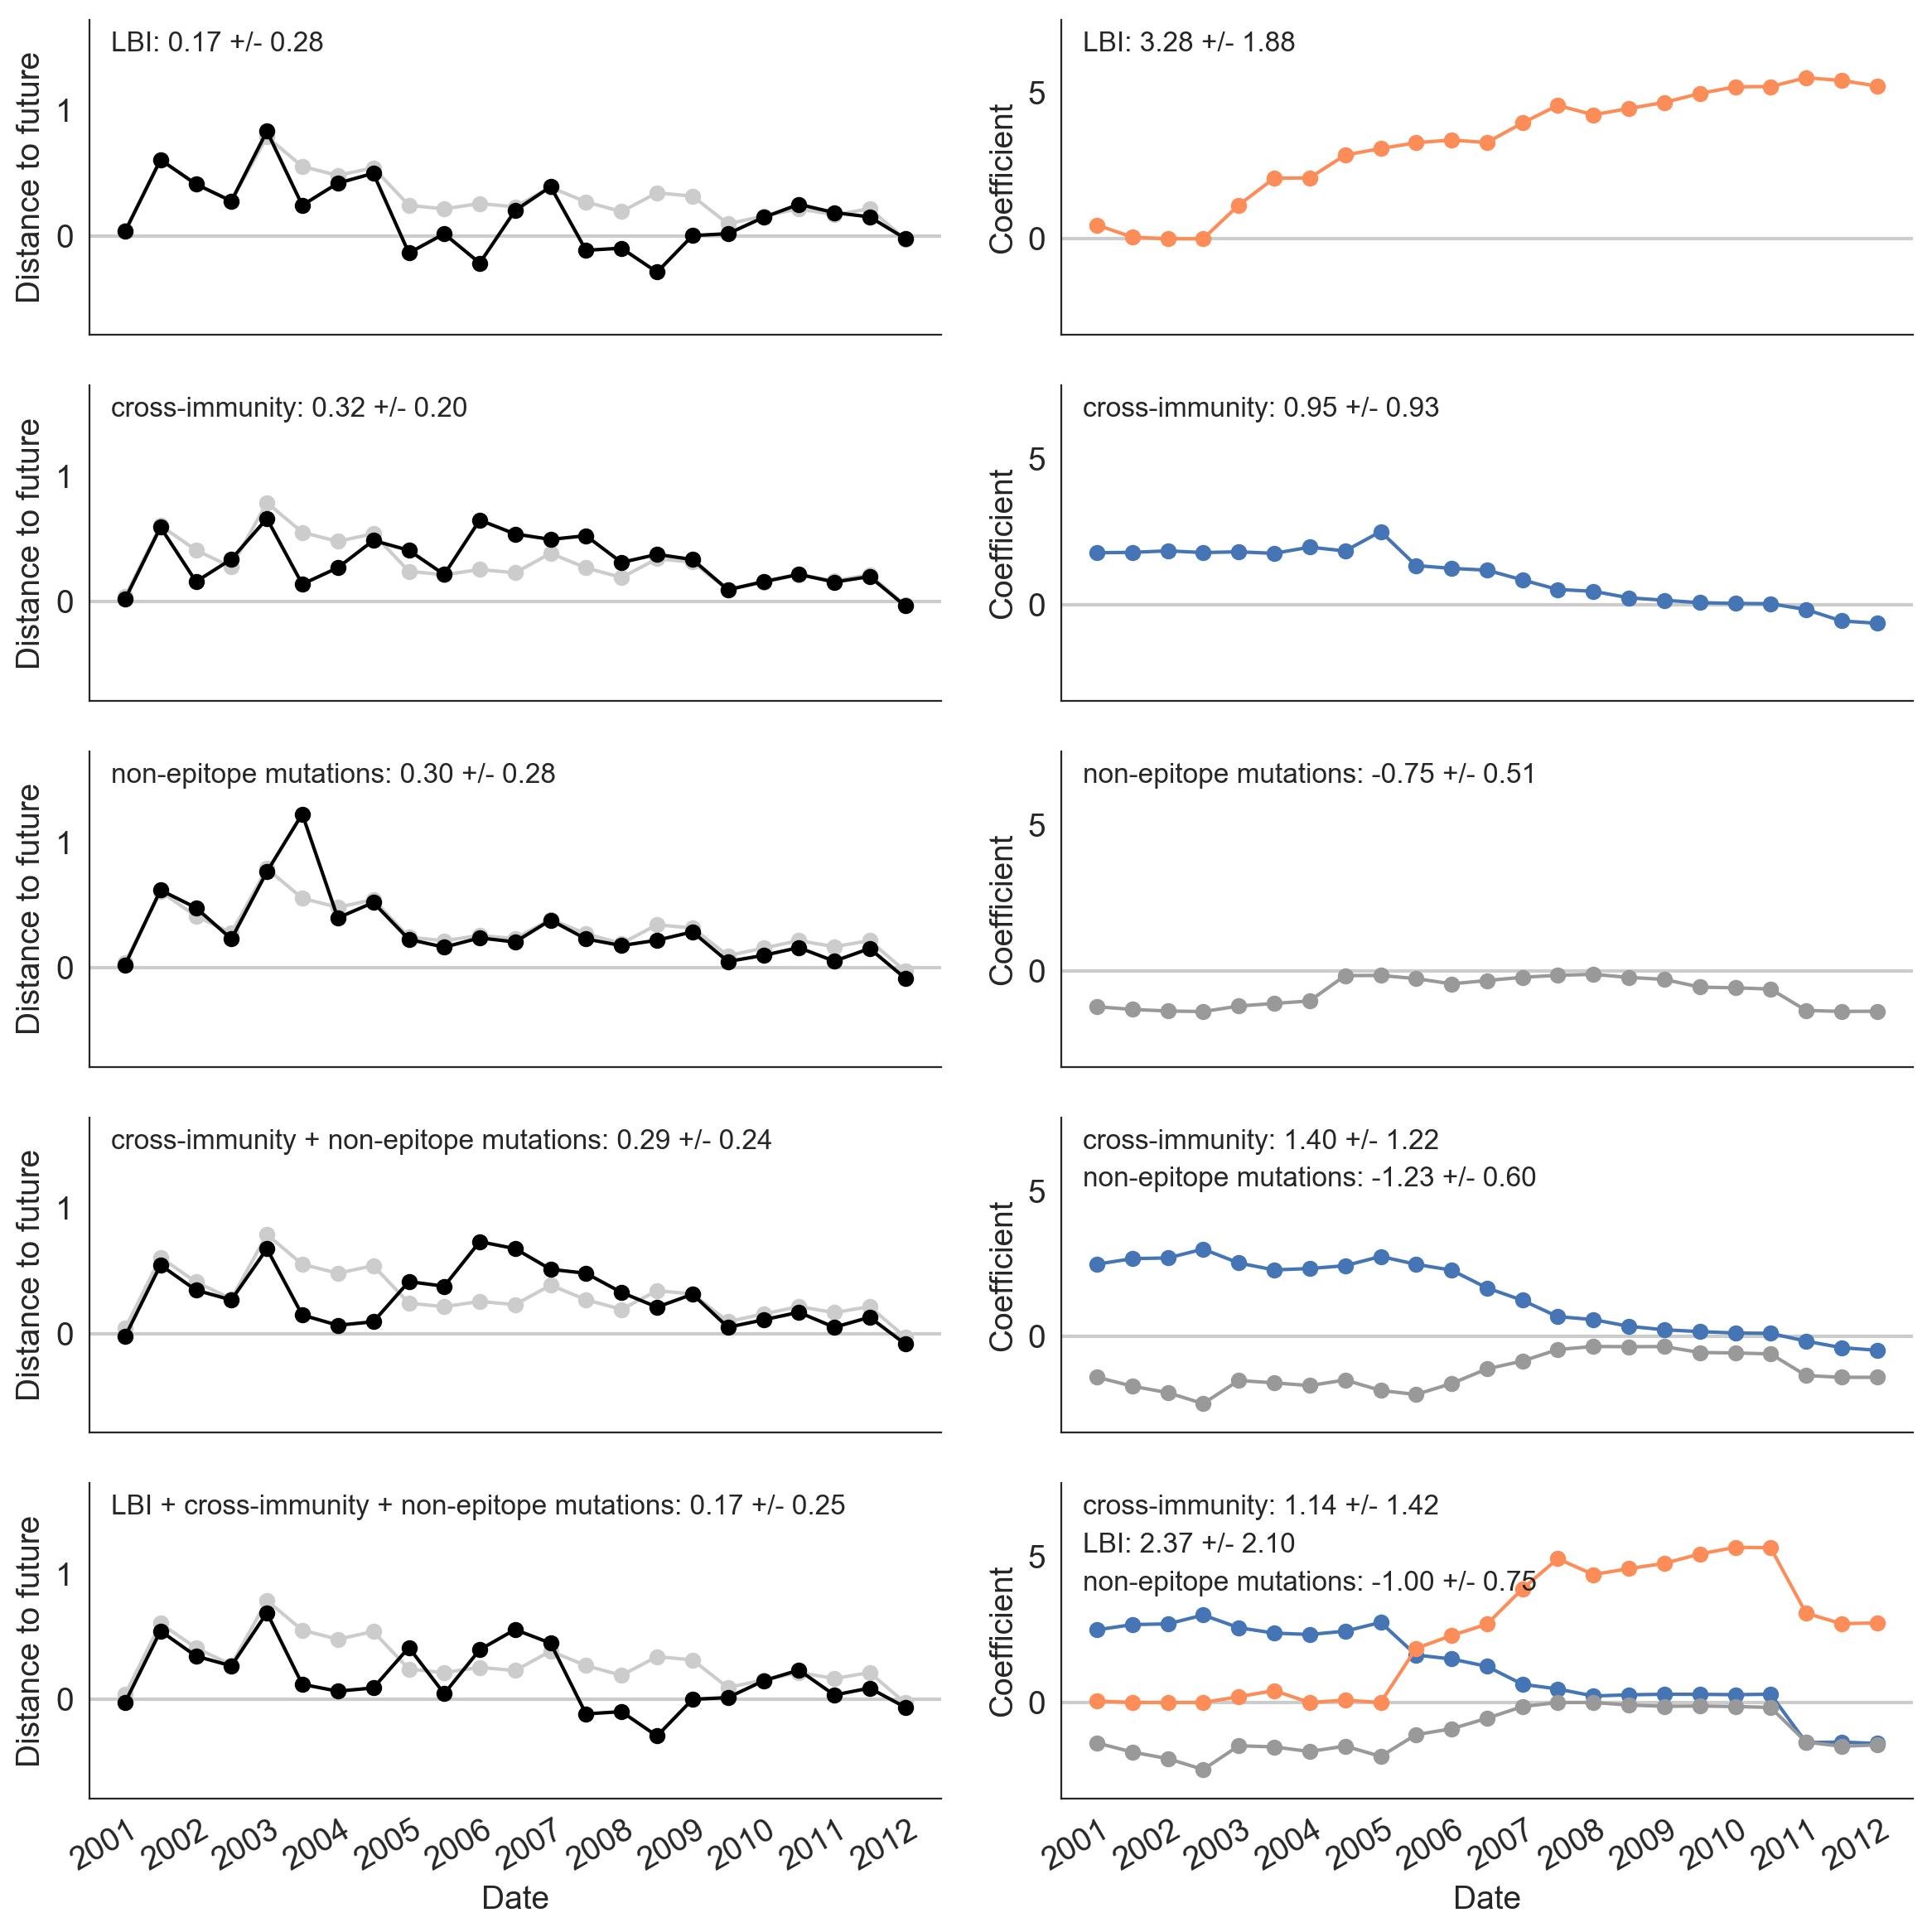

In [152]:
fig, axes = plt.subplots(figsize=(12, 12), facecolor='w')
gs = gridspec.GridSpec(
    nrows=nrows_composite,
    ncols=ncols,
    hspace=0.1,
    wspace=0.2
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

for i, predictor in enumerate(composite_predictor_names_order):
    error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
    coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
    composite_predictors = predictor.split("-")
    composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])

    distance_ax = plt.subplot(gs[i, 0])    
    distance_ax.set_xlabel("Date")
    distance_ax.set_ylabel("Distance to future")
    distance_ax.set_ylim(min_normal_error - 0.5, max_normal_error + 0.5)
    distance_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f" % (composite_predictors_name, error_df["validation_error"].mean(), error_df["validation_error"].std()),
        fontdict={"fontsize": 12},
        transform=distance_ax.transAxes
    )
    
    distance_ax.axhline(
        y=0.0,
        color="#cccccc"
    )
    
    distance_ax.plot(
        pd.to_datetime(naive_error_df["validation_timepoint"]).astype(np.datetime64),
        naive_error_df["validation_error"],
        "o-",
        color="#cccccc",
        zorder=-10
    )
    
    distance_ax.plot(
        pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
        error_df["validation_error"],
        "o-",
        color="#000000"
    )
    
    distance_ax.set_xlim(min_date, max_date)
    distance_ax.xaxis.set_major_locator(years)
    distance_ax.xaxis.set_major_formatter(years_fmt)
    distance_ax.xaxis.set_minor_locator(months)
    distance_ax.format_xdata = mdates.DateFormatter('%Y-%m')
        
    coefficient_ax = plt.subplot(gs[i, 1])
    coefficient_ax.set_xlabel("Date")
    coefficient_ax.set_ylabel("Coefficient")
    coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 2)

    offset = 0.9
    for individual_predictor, individual_predictor_df in coefficient_df.groupby("predictor"):
        coefficient_ax.text(
            0.025,
            offset,
            "%s: %.2f +/- %.2f" % (
                name_by_predictor[individual_predictor],
                individual_predictor_df["coefficient"].mean(),
                individual_predictor_df["coefficient"].std()
            ),
            fontdict={"fontsize": 12},
            transform=coefficient_ax.transAxes
        )
        offset = offset - 0.12
        
    coefficient_ax.axhline(
        y=0.0,
        color="#cccccc"
    )

    for predictor, predictor_coefficient_df in coefficient_df.groupby("predictor"):
        coefficient_ax.plot(
            predictor_coefficient_df["validation_timepoint"],
            predictor_coefficient_df["coefficient"],
            "o-",
            color=color_by_predictor[predictor]
        )
    
    coefficient_ax.set_xlim(min_date, max_date)
    coefficient_ax.xaxis.set_major_locator(years)
    coefficient_ax.xaxis.set_major_formatter(years_fmt)
    coefficient_ax.xaxis.set_minor_locator(months)
    coefficient_ax.format_xdata = mdates.DateFormatter('%Y-%m')
    
fig.autofmt_xdate()

gs.tight_layout(fig)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

# show x-axis tick lines